<a href="https://colab.research.google.com/github/Wan0213/CE5001-Building-Lane-changing-Model-in-the-Weaving-Section-Through-Machine-Learning/blob/main/updated_Single_model_small20_4_18_lr_%3D_0_00001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
#load the pre processed data
#LC_gap_LK = [DV1 DV2 DV3 Vlc G1 G2 G3 Dend LC_id_LK label_targetlane]
#LC_gap_LK = [0   1  2  3 4  5 6  7    8    9    ]
from google.colab import files
uploaded = files.upload()



Saving GapSimLKLCrandsmall_20.csv to GapSimLKLCrandsmall_20.csv
Saving GapSimLKLCrandsmall_20_10.csv to GapSimLKLCrandsmall_20_10.csv
Saving GapSimLKLCrandsmall_20_20.csv to GapSimLKLCrandsmall_20_20.csv
Saving GapSimLKLCrandsmall_20_30.csv to GapSimLKLCrandsmall_20_30.csv
Saving GapSimLKLCrandsmall_20_40.csv to GapSimLKLCrandsmall_20_40.csv
Saving GapSimLKLCrandsmall_20_60.csv to GapSimLKLCrandsmall_20_60.csv
Saving GapSimLKLCrandsmall_20_80.csv to GapSimLKLCrandsmall_20_80.csv
Saving GapSimLKLCrandsmall_20_90.csv to GapSimLKLCrandsmall_20_90.csv


In [ ]:
import torch.nn as nn

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(9, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import torch.nn as nn

class Deep1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import torch.nn as nn
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 60)
        self.act1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.LeakyReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt

def model_train(model, X_train, y_train, X_val, y_val, lr):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr)

    n_epochs = 250   # number of epochs to run
    batch_size = 25  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    # Lists to hold loss and accuracy values
    

    val_accs = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                #print(X_batch)
                #print(X_batch.shape)
                #print(y_batch)
                #print(y_batch.shape)
                # forward pass
                y_pred = model(X_batch)
                #print(y_pred.shape)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.requires_grad_(True)
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                # Append loss and accuracy values to lists
                

        if epoch % 10 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item(),))
        if epoch == 249:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item(),))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        val_accs.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    

    # Plot validation accuracy curve

    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot([best_acc]*len(val_accs), linestyle='--', label='Best Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

    return best_acc

In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_10.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

          DV1       DV2       DV3          V         G1         G2  \
0    0.338328  5.669280  0.231648  11.999976   5.961583  40.393315   
1    0.167640  5.367528 -0.073152  12.100560   5.947258  39.836750   
2    0.088392  5.013960 -0.085344  12.146280   5.938418  39.313714   
3    0.042672  4.645152 -0.067056  12.170664   5.933237  38.833044   
4    4.349000  0.018000 -1.533000  12.180000  38.392400   5.932600   
..        ...       ...       ...        ...        ...        ...   
750  9.363400 -2.956600  3.032400   7.147600  24.017200  13.347800   
751  9.076900 -2.993100  2.755400   7.184100  23.084200  13.638800   
752  8.698800 -3.124200  2.624300   7.315200  22.187200  13.932800   
753  8.226800 -3.377200  2.611800   7.568200  21.332200  14.245800   
754  7.681200 -3.730800  2.600200   7.921800  20.538200  14.600800   

             G3        Dend     Carid  label_targetlane  
0     20.260361  159.195516  0.827646                 0  
1      5.966460  160.407706  0.827646      

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([755, 9])
torch.Size([755, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0255, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.1175, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.0291, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(0.0016, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 0.69400
Epoch: 10, loss: 0.62334
Epoch: 20, loss: 0.58204
Epoch: 30, loss: 0.55549
Epoch: 40, loss: 0.53619
Epoch: 50, loss: 0.51924
Epoch: 60, loss: 0.50329
Epoch: 70, loss: 0.48853
Epoch: 80, loss: 0.47536
Epoch: 90, loss: 0.46346
Epoch: 100, loss: 0.45293
Epoch: 110, loss: 0.44388
Epoch: 120, loss: 0.43582
Epoch: 130, loss: 0.42865
Epoch: 140, loss: 0.42229
Epoch: 150, loss: 0.41694
Epoch: 160, loss: 0.41204
Epoch: 170, loss: 0.40753
Epoch: 180, loss: 0.40327
Epoch: 190, loss: 0.39929
Epoch: 200, loss: 0.39535
Epoch: 210, loss: 0.39159
Epoch: 220, loss: 0.38838
Epoch: 230, loss: 0.38531
Epoch: 240, loss: 0.38234
Epoch: 249, loss: 0.37970


Accuracy (wide): 0.83
Epoch: 0, loss: 2.93430
Epoch: 10, loss: 1.29200
Epoch: 20, loss: 0.81818
Epoch: 30, loss: 0.63151
Epoch: 40, loss: 0.58252
Epoch: 50, loss: 0.56090
Epoch: 60, loss: 0.54657
Epoch: 70, loss: 0.53506
Epoch: 80, loss: 0.52465
Epoch: 90, loss: 0.51581
Epoch: 100, loss: 0.50798
Epoch: 110, loss: 0.50062
Epoch: 120, loss: 0.49357
Epoch: 130, loss: 0.48671
Epoch: 140, loss: 0.48025
Epoch: 150, loss: 0.47415
Epoch: 160, loss: 0.46837
Epoch: 170, loss: 0.46282
Epoch: 180, loss: 0.45751
Epoch: 190, loss: 0.45254
Epoch: 200, loss: 0.44790
Epoch: 210, loss: 0.44342
Epoch: 220, loss: 0.43909
Epoch: 230, loss: 0.43488
Epoch: 240, loss: 0.43076
Epoch: 249, loss: 0.42715


Accuracy (wide): 0.88
Epoch: 0, loss: 10.60689
Epoch: 10, loss: 5.61965
Epoch: 20, loss: 1.73651
Epoch: 30, loss: 0.72270
Epoch: 40, loss: 0.68508
Epoch: 50, loss: 0.68152
Epoch: 60, loss: 0.67334
Epoch: 70, loss: 0.66005
Epoch: 80, loss: 0.64420
Epoch: 90, loss: 0.62748
Epoch: 100, loss: 0.61140
Epoch: 110, loss: 0.59619
Epoch: 120, loss: 0.58214
Epoch: 130, loss: 0.56888
Epoch: 140, loss: 0.55632
Epoch: 150, loss: 0.54475
Epoch: 160, loss: 0.53467
Epoch: 170, loss: 0.52616
Epoch: 180, loss: 0.51904
Epoch: 190, loss: 0.51297
Epoch: 200, loss: 0.50775
Epoch: 210, loss: 0.50317
Epoch: 220, loss: 0.49892
Epoch: 230, loss: 0.49488
Epoch: 240, loss: 0.49084
Epoch: 249, loss: 0.48715


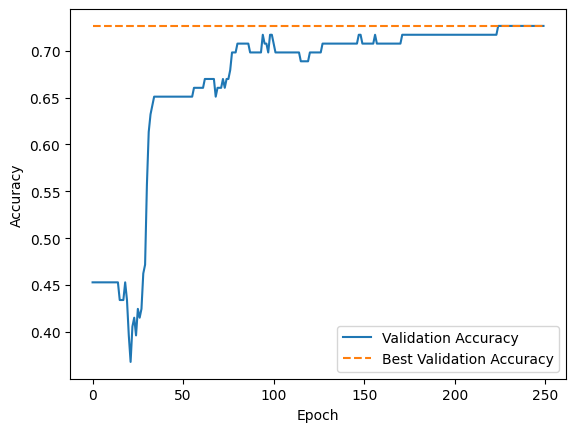

Accuracy (wide): 0.73
Epoch: 0, loss: 3.48166
Epoch: 10, loss: 1.31011
Epoch: 20, loss: 0.86684
Epoch: 30, loss: 0.67166
Epoch: 40, loss: 0.60630
Epoch: 50, loss: 0.59670
Epoch: 60, loss: 0.60015
Epoch: 70, loss: 0.59959
Epoch: 80, loss: 0.59360
Epoch: 90, loss: 0.58529
Epoch: 100, loss: 0.57502
Epoch: 110, loss: 0.56416
Epoch: 120, loss: 0.55258
Epoch: 130, loss: 0.54076
Epoch: 140, loss: 0.52918
Epoch: 150, loss: 0.51792
Epoch: 160, loss: 0.50714
Epoch: 170, loss: 0.49701
Epoch: 180, loss: 0.48748
Epoch: 190, loss: 0.47862
Epoch: 200, loss: 0.47007
Epoch: 210, loss: 0.46216
Epoch: 220, loss: 0.45478
Epoch: 230, loss: 0.44787
Epoch: 240, loss: 0.44127
Epoch: 249, loss: 0.43563


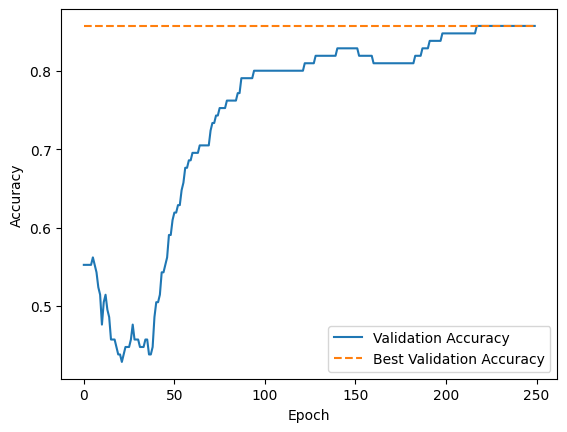

Accuracy (wide): 0.86
Epoch: 0, loss: 4.77511
Epoch: 10, loss: 3.02003
Epoch: 20, loss: 2.13415
Epoch: 30, loss: 1.59815
Epoch: 40, loss: 1.27283
Epoch: 50, loss: 1.08579
Epoch: 60, loss: 0.96880
Epoch: 70, loss: 0.88729
Epoch: 80, loss: 0.82509
Epoch: 90, loss: 0.77403
Epoch: 100, loss: 0.73155
Epoch: 110, loss: 0.69593
Epoch: 120, loss: 0.66587
Epoch: 130, loss: 0.64099
Epoch: 140, loss: 0.61966
Epoch: 150, loss: 0.60120
Epoch: 160, loss: 0.58583
Epoch: 170, loss: 0.57249
Epoch: 180, loss: 0.56065
Epoch: 190, loss: 0.55027
Epoch: 200, loss: 0.54181
Epoch: 210, loss: 0.53463
Epoch: 220, loss: 0.52821
Epoch: 230, loss: 0.52211
Epoch: 240, loss: 0.51598
Epoch: 249, loss: 0.51066


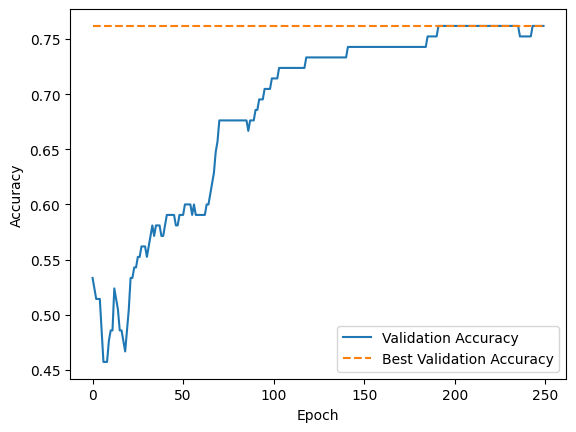

Accuracy (wide): 0.76
Epoch: 0, loss: 0.61268
Epoch: 10, loss: 0.59642
Epoch: 20, loss: 0.56858
Epoch: 30, loss: 0.54344
Epoch: 40, loss: 0.52194
Epoch: 50, loss: 0.50581
Epoch: 60, loss: 0.49452
Epoch: 70, loss: 0.48556
Epoch: 80, loss: 0.47831
Epoch: 90, loss: 0.47191
Epoch: 100, loss: 0.46581
Epoch: 110, loss: 0.46022
Epoch: 120, loss: 0.45488
Epoch: 130, loss: 0.45014
Epoch: 140, loss: 0.44587
Epoch: 150, loss: 0.44169
Epoch: 160, loss: 0.43772
Epoch: 170, loss: 0.43436
Epoch: 180, loss: 0.43015
Epoch: 190, loss: 0.42581
Epoch: 200, loss: 0.42245
Epoch: 210, loss: 0.41910
Epoch: 220, loss: 0.41524
Epoch: 230, loss: 0.41168
Epoch: 240, loss: 0.40790
Epoch: 249, loss: 0.40535


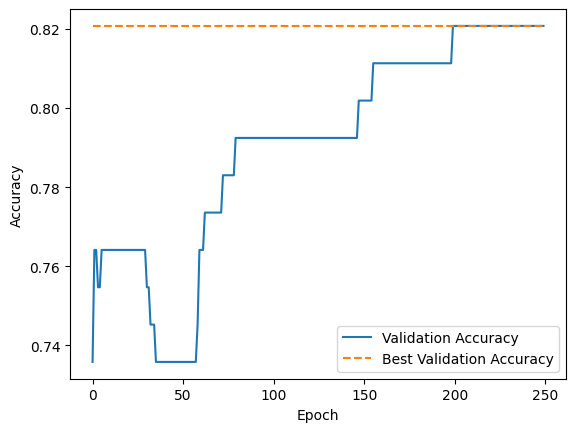

Accuracy (deep1): 0.82
Epoch: 0, loss: 1.43679
Epoch: 10, loss: 0.67723
Epoch: 20, loss: 0.63134
Epoch: 30, loss: 0.61534
Epoch: 40, loss: 0.60697
Epoch: 50, loss: 0.59997
Epoch: 60, loss: 0.59468
Epoch: 70, loss: 0.59123
Epoch: 80, loss: 0.58837
Epoch: 90, loss: 0.58216
Epoch: 100, loss: 0.57483
Epoch: 110, loss: 0.56864
Epoch: 120, loss: 0.56191
Epoch: 130, loss: 0.55768
Epoch: 140, loss: 0.55376
Epoch: 150, loss: 0.54975
Epoch: 160, loss: 0.54593
Epoch: 170, loss: 0.54221
Epoch: 180, loss: 0.53871
Epoch: 190, loss: 0.53526
Epoch: 200, loss: 0.53183
Epoch: 210, loss: 0.52849
Epoch: 220, loss: 0.52516
Epoch: 230, loss: 0.52187
Epoch: 240, loss: 0.51852
Epoch: 249, loss: 0.51554


Accuracy (deep1): 0.80
Epoch: 0, loss: 3.55922
Epoch: 10, loss: 1.56420
Epoch: 20, loss: 0.65964
Epoch: 30, loss: 0.58906
Epoch: 40, loss: 0.57850
Epoch: 50, loss: 0.56772
Epoch: 60, loss: 0.55222
Epoch: 70, loss: 0.53751
Epoch: 80, loss: 0.52551
Epoch: 90, loss: 0.51482
Epoch: 100, loss: 0.50820
Epoch: 110, loss: 0.50243
Epoch: 120, loss: 0.49747
Epoch: 130, loss: 0.49239
Epoch: 140, loss: 0.48753
Epoch: 150, loss: 0.48250
Epoch: 160, loss: 0.47761
Epoch: 170, loss: 0.47283
Epoch: 180, loss: 0.46806
Epoch: 190, loss: 0.46351
Epoch: 200, loss: 0.45931
Epoch: 210, loss: 0.45556
Epoch: 220, loss: 0.45140
Epoch: 230, loss: 0.44660
Epoch: 240, loss: 0.44255
Epoch: 249, loss: 0.43894


Accuracy (deep1): 0.74
Epoch: 0, loss: 0.80326
Epoch: 10, loss: 0.59822
Epoch: 20, loss: 0.54096
Epoch: 30, loss: 0.52525
Epoch: 40, loss: 0.51749
Epoch: 50, loss: 0.51292
Epoch: 60, loss: 0.50667
Epoch: 70, loss: 0.50027
Epoch: 80, loss: 0.49666
Epoch: 90, loss: 0.49240
Epoch: 100, loss: 0.48823
Epoch: 110, loss: 0.48348
Epoch: 120, loss: 0.47870
Epoch: 130, loss: 0.47383
Epoch: 140, loss: 0.46678
Epoch: 150, loss: 0.45973
Epoch: 160, loss: 0.45362
Epoch: 170, loss: 0.44802
Epoch: 180, loss: 0.44365
Epoch: 190, loss: 0.43919
Epoch: 200, loss: 0.43489
Epoch: 210, loss: 0.43064
Epoch: 220, loss: 0.42627
Epoch: 230, loss: 0.42228
Epoch: 240, loss: 0.41852
Epoch: 249, loss: 0.41514


Accuracy (deep1): 0.80
Epoch: 0, loss: 0.95316
Epoch: 10, loss: 0.65428
Epoch: 20, loss: 0.59310
Epoch: 30, loss: 0.56378
Epoch: 40, loss: 0.54938
Epoch: 50, loss: 0.54199
Epoch: 60, loss: 0.53694
Epoch: 70, loss: 0.53207
Epoch: 80, loss: 0.52790
Epoch: 90, loss: 0.52424
Epoch: 100, loss: 0.52078
Epoch: 110, loss: 0.51760
Epoch: 120, loss: 0.51445
Epoch: 130, loss: 0.51122
Epoch: 140, loss: 0.50756
Epoch: 150, loss: 0.50407
Epoch: 160, loss: 0.50081
Epoch: 170, loss: 0.49730
Epoch: 180, loss: 0.49385
Epoch: 190, loss: 0.49053
Epoch: 200, loss: 0.48703
Epoch: 210, loss: 0.48319
Epoch: 220, loss: 0.47964
Epoch: 230, loss: 0.47606
Epoch: 240, loss: 0.47246
Epoch: 249, loss: 0.46933


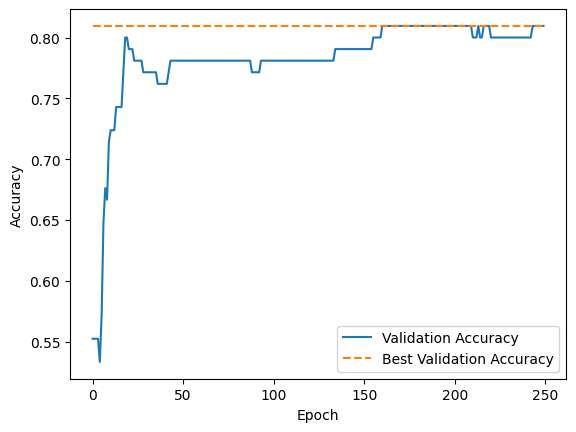

Accuracy (deep1): 0.81
Epoch: 0, loss: 0.79535
Epoch: 10, loss: 0.69147
Epoch: 20, loss: 0.65294
Epoch: 30, loss: 0.63637
Epoch: 40, loss: 0.62725
Epoch: 50, loss: 0.61945
Epoch: 60, loss: 0.61194
Epoch: 70, loss: 0.60478
Epoch: 80, loss: 0.59829
Epoch: 90, loss: 0.59321
Epoch: 100, loss: 0.58856
Epoch: 110, loss: 0.58401
Epoch: 120, loss: 0.57946
Epoch: 130, loss: 0.57520
Epoch: 140, loss: 0.57128
Epoch: 150, loss: 0.56786
Epoch: 160, loss: 0.56381
Epoch: 170, loss: 0.56014
Epoch: 180, loss: 0.55666
Epoch: 190, loss: 0.55289
Epoch: 200, loss: 0.54929
Epoch: 210, loss: 0.54620
Epoch: 220, loss: 0.54224
Epoch: 230, loss: 0.53841
Epoch: 240, loss: 0.53475
Epoch: 249, loss: 0.53148


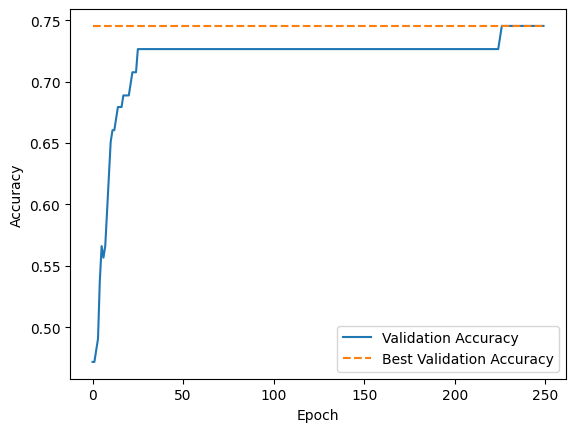

Accuracy (deep): 0.75
Epoch: 0, loss: 0.83741
Epoch: 10, loss: 0.52806
Epoch: 20, loss: 0.50695
Epoch: 30, loss: 0.49875
Epoch: 40, loss: 0.49312
Epoch: 50, loss: 0.48751
Epoch: 60, loss: 0.48244
Epoch: 70, loss: 0.47829
Epoch: 80, loss: 0.47544
Epoch: 90, loss: 0.47267
Epoch: 100, loss: 0.46940
Epoch: 110, loss: 0.46643
Epoch: 120, loss: 0.46341
Epoch: 130, loss: 0.46019
Epoch: 140, loss: 0.45706
Epoch: 150, loss: 0.45394
Epoch: 160, loss: 0.45085
Epoch: 170, loss: 0.44775
Epoch: 180, loss: 0.44526
Epoch: 190, loss: 0.44269
Epoch: 200, loss: 0.44025
Epoch: 210, loss: 0.43770
Epoch: 220, loss: 0.43513
Epoch: 230, loss: 0.43193
Epoch: 240, loss: 0.42838
Epoch: 249, loss: 0.42591


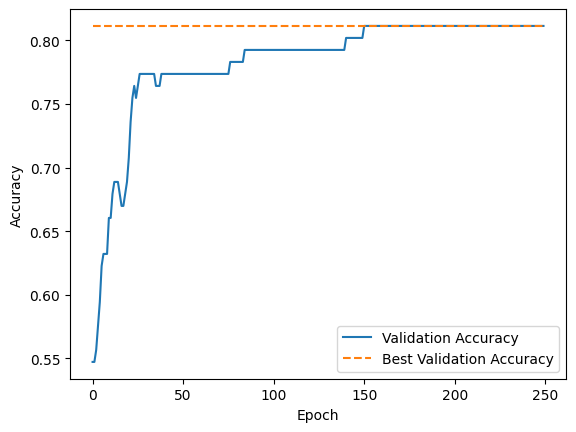

Accuracy (deep): 0.81
Epoch: 0, loss: 1.61252
Epoch: 10, loss: 0.68476
Epoch: 20, loss: 0.60243
Epoch: 30, loss: 0.56192
Epoch: 40, loss: 0.55051
Epoch: 50, loss: 0.54931
Epoch: 60, loss: 0.54919
Epoch: 70, loss: 0.54945
Epoch: 80, loss: 0.54934
Epoch: 90, loss: 0.54800
Epoch: 100, loss: 0.54474
Epoch: 110, loss: 0.54207
Epoch: 120, loss: 0.54003
Epoch: 130, loss: 0.53682
Epoch: 140, loss: 0.53394
Epoch: 150, loss: 0.53114
Epoch: 160, loss: 0.52836
Epoch: 170, loss: 0.52545
Epoch: 180, loss: 0.52231
Epoch: 190, loss: 0.51848
Epoch: 200, loss: 0.51451
Epoch: 210, loss: 0.51021
Epoch: 220, loss: 0.50587
Epoch: 230, loss: 0.50120
Epoch: 240, loss: 0.49635
Epoch: 249, loss: 0.49387


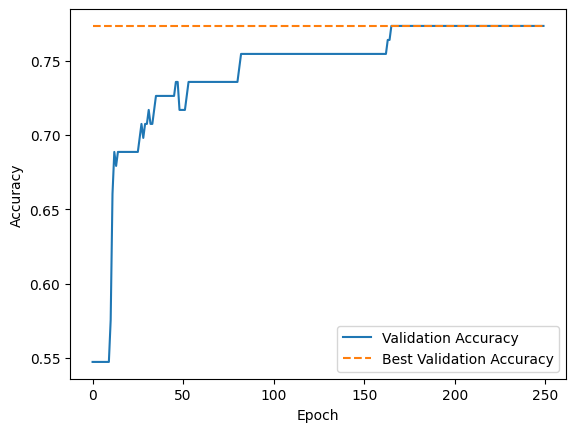

Accuracy (deep): 0.77
Epoch: 0, loss: 2.31004
Epoch: 10, loss: 0.98862
Epoch: 20, loss: 0.74753
Epoch: 30, loss: 0.69642
Epoch: 40, loss: 0.66798
Epoch: 50, loss: 0.64678
Epoch: 60, loss: 0.63044
Epoch: 70, loss: 0.61782
Epoch: 80, loss: 0.60573
Epoch: 90, loss: 0.59389
Epoch: 100, loss: 0.58341
Epoch: 110, loss: 0.57419
Epoch: 120, loss: 0.56542
Epoch: 130, loss: 0.55769
Epoch: 140, loss: 0.54986
Epoch: 150, loss: 0.54232
Epoch: 160, loss: 0.53475
Epoch: 170, loss: 0.52756
Epoch: 180, loss: 0.52054
Epoch: 190, loss: 0.51395
Epoch: 200, loss: 0.50804
Epoch: 210, loss: 0.50234
Epoch: 220, loss: 0.49663
Epoch: 230, loss: 0.49093
Epoch: 240, loss: 0.48564
Epoch: 249, loss: 0.48086


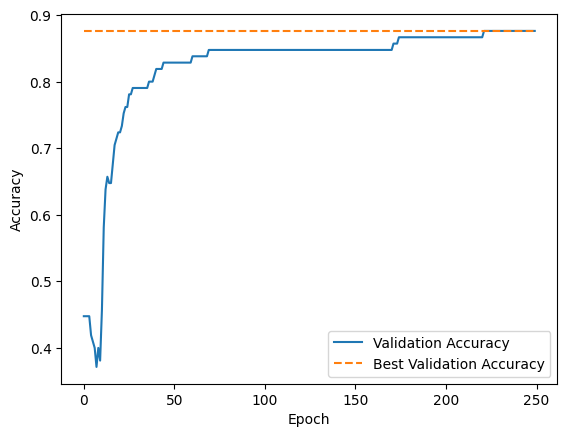

Accuracy (deep): 0.88
Epoch: 0, loss: 2.35069
Epoch: 10, loss: 1.01039
Epoch: 20, loss: 0.57523
Epoch: 30, loss: 0.51793
Epoch: 40, loss: 0.50179
Epoch: 50, loss: 0.49286
Epoch: 60, loss: 0.48637
Epoch: 70, loss: 0.48030
Epoch: 80, loss: 0.47361
Epoch: 90, loss: 0.46864
Epoch: 100, loss: 0.46425
Epoch: 110, loss: 0.45980
Epoch: 120, loss: 0.45559
Epoch: 130, loss: 0.45199
Epoch: 140, loss: 0.44877
Epoch: 150, loss: 0.44579
Epoch: 160, loss: 0.44278
Epoch: 170, loss: 0.43965
Epoch: 180, loss: 0.43638
Epoch: 190, loss: 0.43319
Epoch: 200, loss: 0.43012
Epoch: 210, loss: 0.42690
Epoch: 220, loss: 0.42353
Epoch: 230, loss: 0.42047
Epoch: 240, loss: 0.41732
Epoch: 249, loss: 0.41442


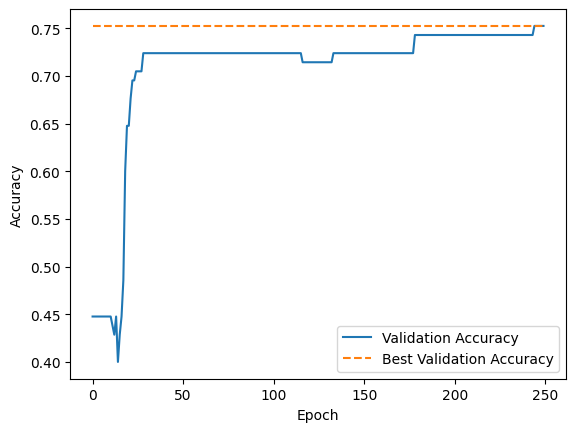

Accuracy (deep): 0.75
Epoch: 0, loss: 2.19407
Epoch: 10, loss: 1.74298
Epoch: 20, loss: 1.53084
Epoch: 30, loss: 1.41489
Epoch: 40, loss: 1.33549
Epoch: 50, loss: 1.28115
Epoch: 60, loss: 1.24379
Epoch: 70, loss: 1.21775
Epoch: 80, loss: 1.19928
Epoch: 90, loss: 1.18600
Epoch: 100, loss: 1.17619
Epoch: 110, loss: 1.16890
Epoch: 120, loss: 1.16331
Epoch: 130, loss: 1.15901
Epoch: 140, loss: 1.15567
Epoch: 150, loss: 1.15300
Epoch: 160, loss: 1.15090
Epoch: 170, loss: 1.14919
Epoch: 180, loss: 1.14784
Epoch: 190, loss: 1.14667
Epoch: 200, loss: 1.14572
Epoch: 210, loss: 1.14490
Epoch: 220, loss: 1.14418
Epoch: 230, loss: 1.14349
Epoch: 240, loss: 1.14281
Epoch: 249, loss: 1.14218


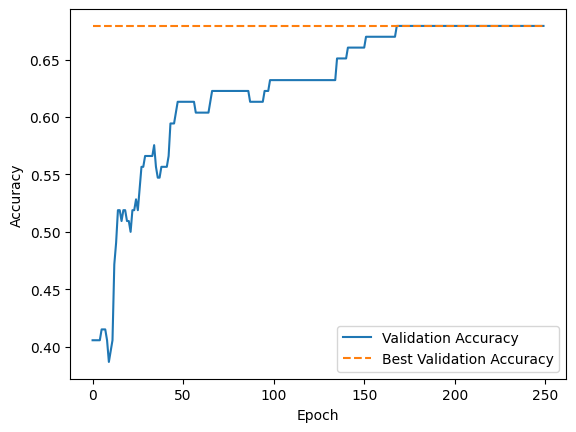

Accuracy (pbm): 0.68
Epoch: 0, loss: 1.92251
Epoch: 10, loss: 1.58016
Epoch: 20, loss: 1.38108
Epoch: 30, loss: 1.29397
Epoch: 40, loss: 1.23590
Epoch: 50, loss: 1.19768
Epoch: 60, loss: 1.17256
Epoch: 70, loss: 1.15596
Epoch: 80, loss: 1.14482
Epoch: 90, loss: 1.13731
Epoch: 100, loss: 1.13211
Epoch: 110, loss: 1.12848
Epoch: 120, loss: 1.12590
Epoch: 130, loss: 1.12403
Epoch: 140, loss: 1.12268
Epoch: 150, loss: 1.12174
Epoch: 160, loss: 1.12104
Epoch: 170, loss: 1.12054
Epoch: 180, loss: 1.12015
Epoch: 190, loss: 1.11988
Epoch: 200, loss: 1.11965
Epoch: 210, loss: 1.11942
Epoch: 220, loss: 1.11920
Epoch: 230, loss: 1.11896
Epoch: 240, loss: 1.11865
Epoch: 249, loss: 1.11835


Accuracy (pbm): 0.61
Epoch: 0, loss: 2.01646
Epoch: 10, loss: 1.63136
Epoch: 20, loss: 1.44437
Epoch: 30, loss: 1.34307
Epoch: 40, loss: 1.27355
Epoch: 50, loss: 1.22590
Epoch: 60, loss: 1.19289
Epoch: 70, loss: 1.16972
Epoch: 80, loss: 1.15304
Epoch: 90, loss: 1.14071
Epoch: 100, loss: 1.13138
Epoch: 110, loss: 1.12411
Epoch: 120, loss: 1.11827
Epoch: 130, loss: 1.11352
Epoch: 140, loss: 1.10949
Epoch: 150, loss: 1.10600
Epoch: 160, loss: 1.10296
Epoch: 170, loss: 1.10029
Epoch: 180, loss: 1.09779
Epoch: 190, loss: 1.09551
Epoch: 200, loss: 1.09338
Epoch: 210, loss: 1.09134
Epoch: 220, loss: 1.08941
Epoch: 230, loss: 1.08750
Epoch: 240, loss: 1.08566
Epoch: 249, loss: 1.08401


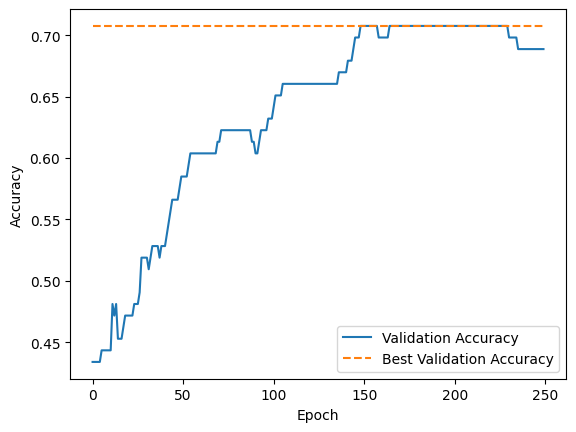

Accuracy (pbm): 0.71
Epoch: 0, loss: 1.80773
Epoch: 10, loss: 1.35987
Epoch: 20, loss: 1.14012
Epoch: 30, loss: 0.99161
Epoch: 40, loss: 0.88425
Epoch: 50, loss: 0.80642
Epoch: 60, loss: 0.74942
Epoch: 70, loss: 0.70710
Epoch: 80, loss: 0.67516
Epoch: 90, loss: 0.65065
Epoch: 100, loss: 0.63154
Epoch: 110, loss: 0.61640
Epoch: 120, loss: 0.60424
Epoch: 130, loss: 0.59435
Epoch: 140, loss: 0.58622
Epoch: 150, loss: 0.57949
Epoch: 160, loss: 0.57386
Epoch: 170, loss: 0.56914
Epoch: 180, loss: 0.56515
Epoch: 190, loss: 0.56179
Epoch: 200, loss: 0.55895
Epoch: 210, loss: 0.55655
Epoch: 220, loss: 0.55454
Epoch: 230, loss: 0.55286
Epoch: 240, loss: 0.55148
Epoch: 249, loss: 0.55046


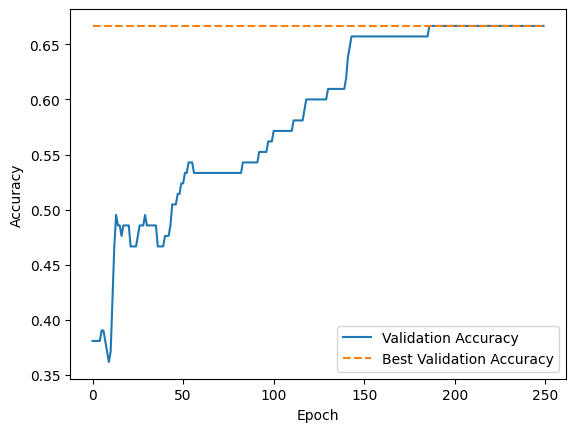

Accuracy (pbm): 0.67
Epoch: 0, loss: 2.55805
Epoch: 10, loss: 2.03609
Epoch: 20, loss: 1.75704
Epoch: 30, loss: 1.60652
Epoch: 40, loss: 1.50016
Epoch: 50, loss: 1.42484
Epoch: 60, loss: 1.37093
Epoch: 70, loss: 1.33179
Epoch: 80, loss: 1.30285
Epoch: 90, loss: 1.28103
Epoch: 100, loss: 1.26423
Epoch: 110, loss: 1.25110
Epoch: 120, loss: 1.24062
Epoch: 130, loss: 1.23211
Epoch: 140, loss: 1.22517
Epoch: 150, loss: 1.21942
Epoch: 160, loss: 1.21462
Epoch: 170, loss: 1.21052
Epoch: 180, loss: 1.20697
Epoch: 190, loss: 1.20385
Epoch: 200, loss: 1.20109
Epoch: 210, loss: 1.19851
Epoch: 220, loss: 1.19612
Epoch: 230, loss: 1.19382
Epoch: 240, loss: 1.19159
Epoch: 249, loss: 1.18956


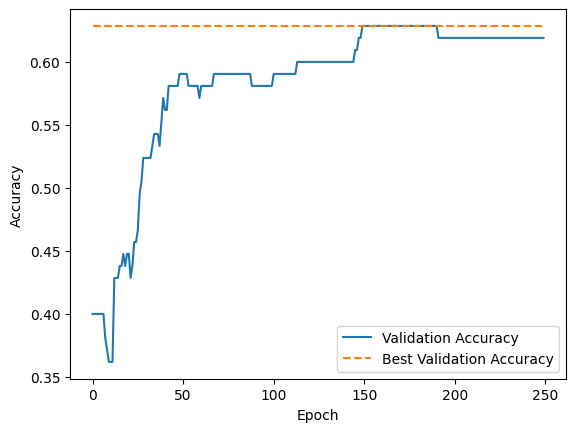

Accuracy (pbm): 0.63


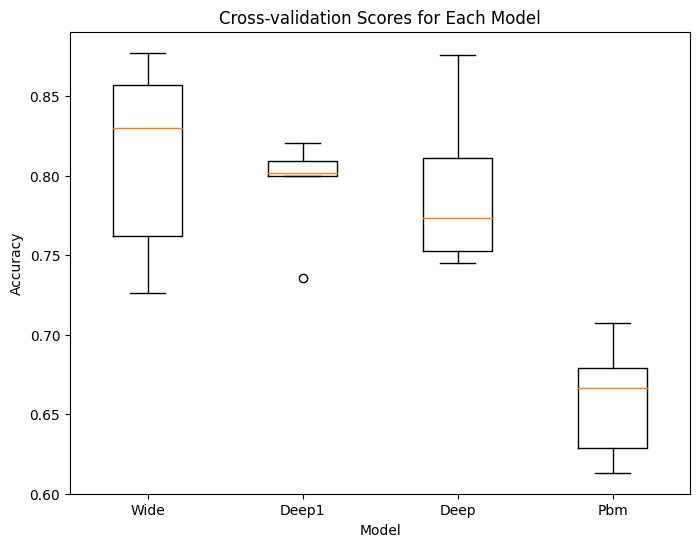

Wide: 81.06% (+/- 5.74%)
Deep1: 79.36% (+/- 2.98%)
Deep: 79.18% (+/- 4.81%)
Pbm: 65.90% (+/- 3.42%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




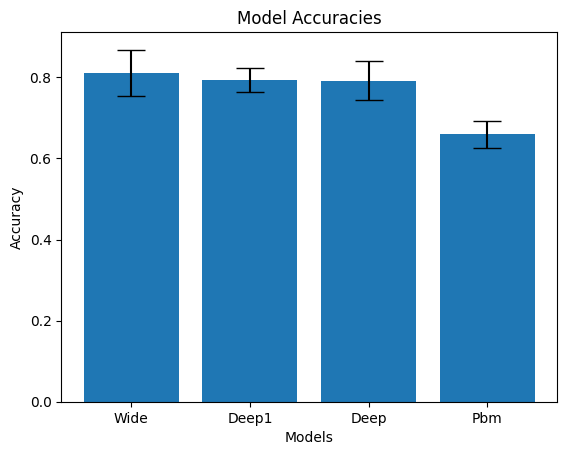

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_20.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

        DV1    DV2    DV3       V       G1       G2        G3      Dend  \
0    -1.146  0.640 -5.520  18.943  39.3416  20.0882  257.3108   51.8348   
1    -1.155  0.689 -5.486  19.004  39.4426  20.0252  256.7608   53.7348   
2    -1.268  0.744 -5.474  19.044  39.5556  19.9502  256.2208   55.6348   
3    -1.387  0.765 -5.477  19.056  39.6956  19.8712  255.6708   57.5448   
4    -1.414  0.762 -5.486  19.056  39.8476  19.7942  255.1208   59.4448   
...     ...    ...    ...     ...      ...      ...       ...       ...   
1407  9.073 -0.927 -2.451  11.595  81.6480   6.6950  231.8328  122.5148   
1408  9.193 -0.966 -2.490  11.634  80.7190   6.7790  231.6028  123.6648   
1409  9.135 -1.125 -2.649  11.793  79.7850   6.8710  231.3528  124.8248   
1410  8.876 -1.390 -2.914  12.058  78.8660   6.9880  231.0828  126.0148   
1411  8.443 -1.701 -3.225  12.369  77.9850   7.1430  230.7728  127.2348   

         Carid  label_targetlane  
0     0.358781                 1  
1     0.358781               

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([1412, 9])
torch.Size([1412, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.0030, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.01671, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(0.0042, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 1.27709
Epoch: 10, loss: 0.89407
Epoch: 20, loss: 0.65301
Epoch: 30, loss: 0.56598
Epoch: 40, loss: 0.54615
Epoch: 50, loss: 0.53753
Epoch: 60, loss: 0.52870
Epoch: 70, loss: 0.51815
Epoch: 80, loss: 0.50626
Epoch: 90, loss: 0.49529
Epoch: 100, loss: 0.48494
Epoch: 110, loss: 0.47531
Epoch: 120, loss: 0.46642
Epoch: 130, loss: 0.45825
Epoch: 140, loss: 0.44993
Epoch: 150, loss: 0.44176
Epoch: 160, loss: 0.43403
Epoch: 170, loss: 0.42642
Epoch: 180, loss: 0.41909
Epoch: 190, loss: 0.41211
Epoch: 200, loss: 0.40508
Epoch: 210, loss: 0.39814
Epoch: 220, loss: 0.39143
Epoch: 230, loss: 0.38473
Epoch: 240, loss: 0.37810
Epoch: 249, loss: 0.37245


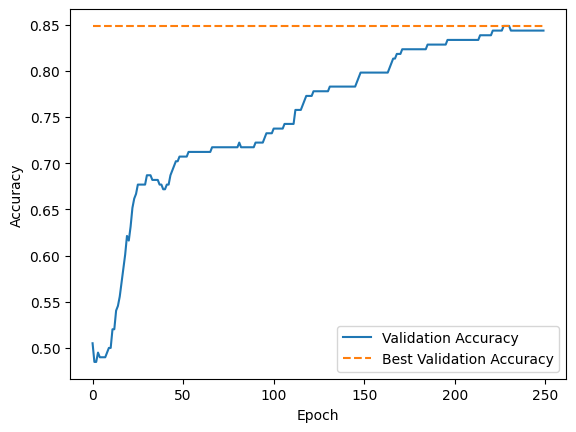

Accuracy (wide): 0.85
Epoch: 0, loss: 9.37632
Epoch: 10, loss: 3.11608
Epoch: 20, loss: 1.99485
Epoch: 30, loss: 1.72320
Epoch: 40, loss: 1.46803
Epoch: 50, loss: 1.21890
Epoch: 60, loss: 0.98644
Epoch: 70, loss: 0.77935
Epoch: 80, loss: 0.61625
Epoch: 90, loss: 0.51295
Epoch: 100, loss: 0.45498
Epoch: 110, loss: 0.42282
Epoch: 120, loss: 0.40400
Epoch: 130, loss: 0.39151
Epoch: 140, loss: 0.38220
Epoch: 150, loss: 0.37417
Epoch: 160, loss: 0.36696
Epoch: 170, loss: 0.36082
Epoch: 180, loss: 0.35501
Epoch: 190, loss: 0.34947
Epoch: 200, loss: 0.34423
Epoch: 210, loss: 0.33909
Epoch: 220, loss: 0.33428
Epoch: 230, loss: 0.32961
Epoch: 240, loss: 0.32537
Epoch: 249, loss: 0.32168


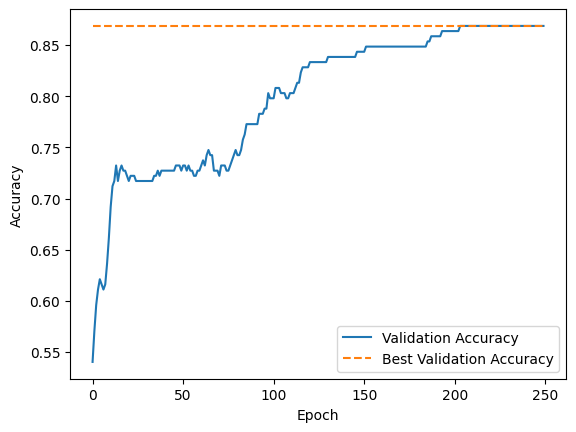

Accuracy (wide): 0.87
Epoch: 0, loss: 8.59686
Epoch: 10, loss: 1.70965
Epoch: 20, loss: 0.98421
Epoch: 30, loss: 0.72105
Epoch: 40, loss: 0.51011
Epoch: 50, loss: 0.38322
Epoch: 60, loss: 0.33211
Epoch: 70, loss: 0.32971
Epoch: 80, loss: 0.34168
Epoch: 90, loss: 0.35272
Epoch: 100, loss: 0.36124
Epoch: 110, loss: 0.36753
Epoch: 120, loss: 0.37205
Epoch: 130, loss: 0.37564
Epoch: 140, loss: 0.37787
Epoch: 150, loss: 0.37871
Epoch: 160, loss: 0.37880
Epoch: 170, loss: 0.37799
Epoch: 180, loss: 0.37644
Epoch: 190, loss: 0.37450
Epoch: 200, loss: 0.37206
Epoch: 210, loss: 0.36936
Epoch: 220, loss: 0.36614
Epoch: 230, loss: 0.36298
Epoch: 240, loss: 0.35958
Epoch: 249, loss: 0.35635


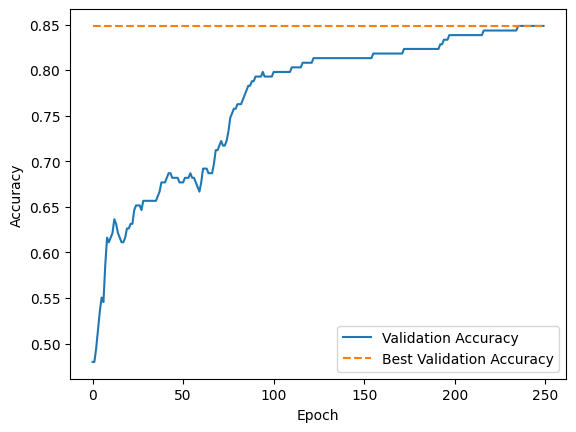

Accuracy (wide): 0.85
Epoch: 0, loss: 26.58223
Epoch: 10, loss: 19.78257
Epoch: 20, loss: 8.63217
Epoch: 30, loss: 2.27171
Epoch: 40, loss: 1.23885
Epoch: 50, loss: 0.70322
Epoch: 60, loss: 0.50258
Epoch: 70, loss: 0.42379
Epoch: 80, loss: 0.38244
Epoch: 90, loss: 0.35783
Epoch: 100, loss: 0.34010
Epoch: 110, loss: 0.32721
Epoch: 120, loss: 0.31701
Epoch: 130, loss: 0.30823
Epoch: 140, loss: 0.30085
Epoch: 150, loss: 0.29405
Epoch: 160, loss: 0.28793
Epoch: 170, loss: 0.28217
Epoch: 180, loss: 0.27689
Epoch: 190, loss: 0.27222
Epoch: 200, loss: 0.26791
Epoch: 210, loss: 0.26367
Epoch: 220, loss: 0.25973
Epoch: 230, loss: 0.25603
Epoch: 240, loss: 0.25232
Epoch: 249, loss: 0.24908


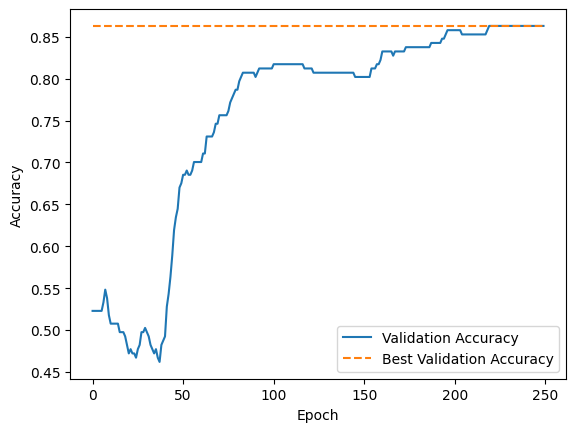

Accuracy (wide): 0.86
Epoch: 0, loss: 7.57322
Epoch: 10, loss: 0.76142
Epoch: 20, loss: 0.48078
Epoch: 30, loss: 0.41370
Epoch: 40, loss: 0.36694
Epoch: 50, loss: 0.33560
Epoch: 60, loss: 0.31825
Epoch: 70, loss: 0.31091
Epoch: 80, loss: 0.30844
Epoch: 90, loss: 0.30779
Epoch: 100, loss: 0.30722
Epoch: 110, loss: 0.30568
Epoch: 120, loss: 0.30361
Epoch: 130, loss: 0.30107
Epoch: 140, loss: 0.29822
Epoch: 150, loss: 0.29508
Epoch: 160, loss: 0.29187
Epoch: 170, loss: 0.28870
Epoch: 180, loss: 0.28599
Epoch: 190, loss: 0.28320
Epoch: 200, loss: 0.28013
Epoch: 210, loss: 0.27694
Epoch: 220, loss: 0.27392
Epoch: 230, loss: 0.27085
Epoch: 240, loss: 0.26809
Epoch: 249, loss: 0.26563


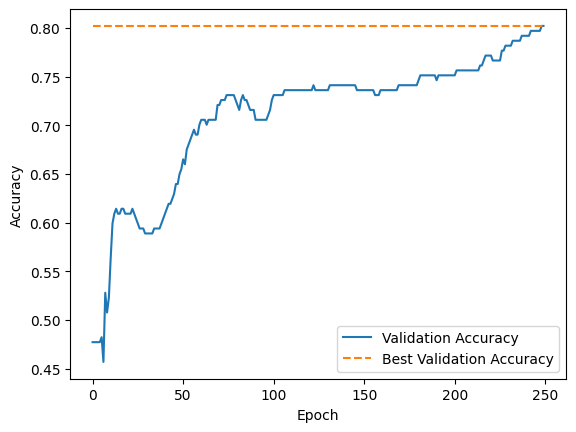

Accuracy (wide): 0.80
Epoch: 0, loss: 0.76690
Epoch: 10, loss: 0.42156
Epoch: 20, loss: 0.37990
Epoch: 30, loss: 0.36381
Epoch: 40, loss: 0.35549
Epoch: 50, loss: 0.34973
Epoch: 60, loss: 0.34779
Epoch: 70, loss: 0.34578
Epoch: 80, loss: 0.34388
Epoch: 90, loss: 0.34158
Epoch: 100, loss: 0.33964
Epoch: 110, loss: 0.33739
Epoch: 120, loss: 0.33538
Epoch: 130, loss: 0.33331
Epoch: 140, loss: 0.33047
Epoch: 150, loss: 0.32759
Epoch: 160, loss: 0.32410
Epoch: 170, loss: 0.32031
Epoch: 180, loss: 0.31662
Epoch: 190, loss: 0.31290
Epoch: 200, loss: 0.30910
Epoch: 210, loss: 0.30542
Epoch: 220, loss: 0.30204
Epoch: 230, loss: 0.29833
Epoch: 240, loss: 0.29391
Epoch: 249, loss: 0.29103


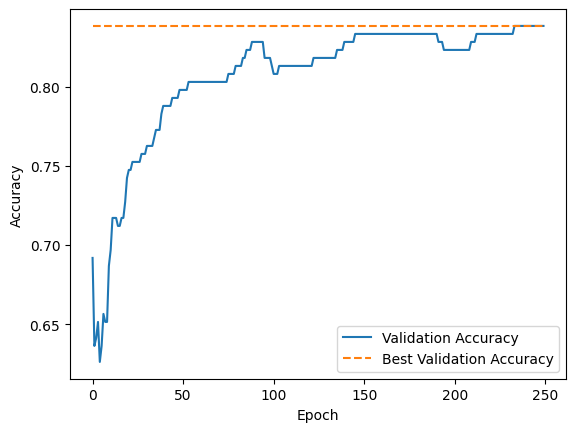

Accuracy (deep1): 0.84
Epoch: 0, loss: 0.60138
Epoch: 10, loss: 0.50871
Epoch: 20, loss: 0.48035
Epoch: 30, loss: 0.47135
Epoch: 40, loss: 0.46082
Epoch: 50, loss: 0.44610
Epoch: 60, loss: 0.43227
Epoch: 70, loss: 0.42410
Epoch: 80, loss: 0.41799
Epoch: 90, loss: 0.41210
Epoch: 100, loss: 0.40755
Epoch: 110, loss: 0.40276
Epoch: 120, loss: 0.39833
Epoch: 130, loss: 0.39426
Epoch: 140, loss: 0.38980
Epoch: 150, loss: 0.38530
Epoch: 160, loss: 0.38078
Epoch: 170, loss: 0.37696
Epoch: 180, loss: 0.37300
Epoch: 190, loss: 0.36834
Epoch: 200, loss: 0.36397
Epoch: 210, loss: 0.35998
Epoch: 220, loss: 0.35686
Epoch: 230, loss: 0.35325
Epoch: 240, loss: 0.34950
Epoch: 249, loss: 0.34625


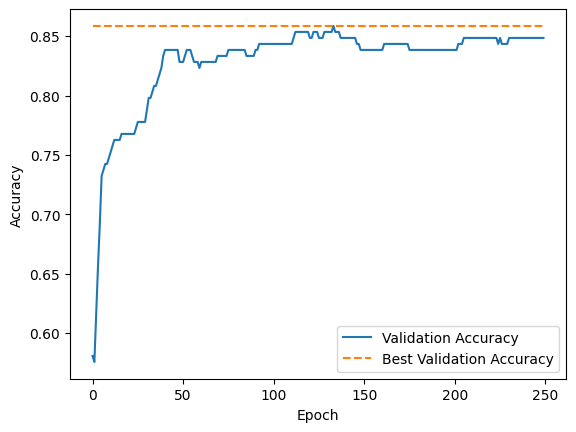

Accuracy (deep1): 0.86
Epoch: 0, loss: 0.75248
Epoch: 10, loss: 0.51412
Epoch: 20, loss: 0.43841
Epoch: 30, loss: 0.40406
Epoch: 40, loss: 0.38644
Epoch: 50, loss: 0.37406
Epoch: 60, loss: 0.36412
Epoch: 70, loss: 0.34809
Epoch: 80, loss: 0.33385
Epoch: 90, loss: 0.32159
Epoch: 100, loss: 0.31102
Epoch: 110, loss: 0.30307
Epoch: 120, loss: 0.29568
Epoch: 130, loss: 0.28873
Epoch: 140, loss: 0.28213
Epoch: 150, loss: 0.27643
Epoch: 160, loss: 0.27121
Epoch: 170, loss: 0.26662
Epoch: 180, loss: 0.26202
Epoch: 190, loss: 0.25828
Epoch: 200, loss: 0.25469
Epoch: 210, loss: 0.25125
Epoch: 220, loss: 0.24781
Epoch: 230, loss: 0.24459
Epoch: 240, loss: 0.24127
Epoch: 249, loss: 0.23850


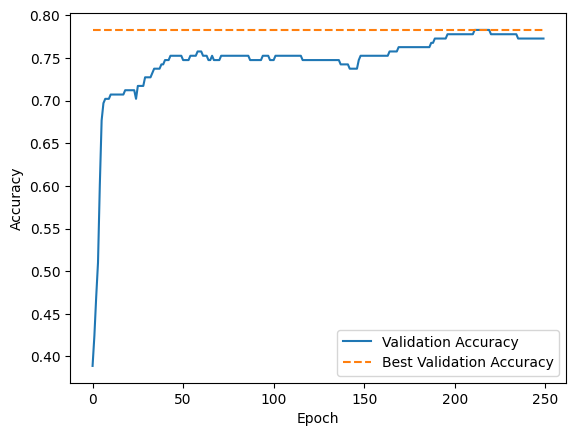

Accuracy (deep1): 0.78
Epoch: 0, loss: 2.33783
Epoch: 10, loss: 0.61851
Epoch: 20, loss: 0.54107
Epoch: 30, loss: 0.52655
Epoch: 40, loss: 0.51425
Epoch: 50, loss: 0.50696
Epoch: 60, loss: 0.50010
Epoch: 70, loss: 0.49436
Epoch: 80, loss: 0.49003
Epoch: 90, loss: 0.48389
Epoch: 100, loss: 0.47725
Epoch: 110, loss: 0.47121
Epoch: 120, loss: 0.46679
Epoch: 130, loss: 0.46275
Epoch: 140, loss: 0.45867
Epoch: 150, loss: 0.45481
Epoch: 160, loss: 0.45072
Epoch: 170, loss: 0.44655
Epoch: 180, loss: 0.44276
Epoch: 190, loss: 0.43897
Epoch: 200, loss: 0.43527
Epoch: 210, loss: 0.43164
Epoch: 220, loss: 0.42792
Epoch: 230, loss: 0.42429
Epoch: 240, loss: 0.42060
Epoch: 249, loss: 0.41674


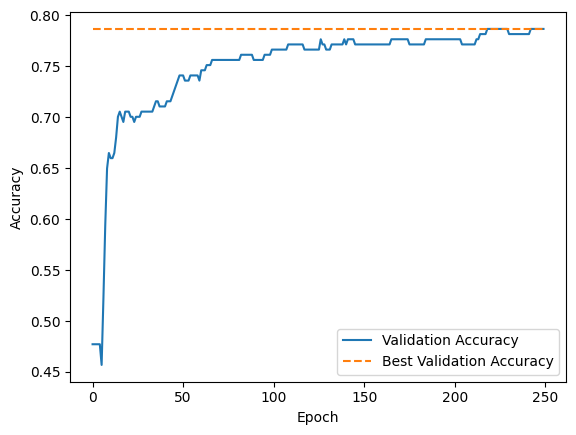

Accuracy (deep1): 0.79
Epoch: 0, loss: 0.80022
Epoch: 10, loss: 0.49670
Epoch: 20, loss: 0.46479
Epoch: 30, loss: 0.45187
Epoch: 40, loss: 0.44205
Epoch: 50, loss: 0.43485
Epoch: 60, loss: 0.42897
Epoch: 70, loss: 0.42411
Epoch: 80, loss: 0.41767
Epoch: 90, loss: 0.40994
Epoch: 100, loss: 0.40362
Epoch: 110, loss: 0.39822
Epoch: 120, loss: 0.39320
Epoch: 130, loss: 0.38877
Epoch: 140, loss: 0.38505
Epoch: 150, loss: 0.38167
Epoch: 160, loss: 0.37842
Epoch: 170, loss: 0.37561
Epoch: 180, loss: 0.37272
Epoch: 190, loss: 0.36987
Epoch: 200, loss: 0.36734
Epoch: 210, loss: 0.36517
Epoch: 220, loss: 0.36308
Epoch: 230, loss: 0.36088
Epoch: 240, loss: 0.35881
Epoch: 249, loss: 0.35680


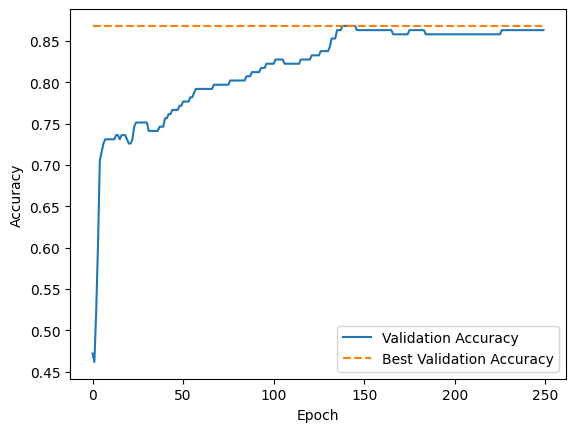

Accuracy (deep1): 0.87
Epoch: 0, loss: 0.80415
Epoch: 10, loss: 0.54245
Epoch: 20, loss: 0.49201
Epoch: 30, loss: 0.46287
Epoch: 40, loss: 0.43877
Epoch: 50, loss: 0.42538
Epoch: 60, loss: 0.41493
Epoch: 70, loss: 0.40553
Epoch: 80, loss: 0.39824
Epoch: 90, loss: 0.39210
Epoch: 100, loss: 0.38550
Epoch: 110, loss: 0.37856
Epoch: 120, loss: 0.37181
Epoch: 130, loss: 0.36499
Epoch: 140, loss: 0.35825
Epoch: 150, loss: 0.35302
Epoch: 160, loss: 0.34820
Epoch: 170, loss: 0.34374
Epoch: 180, loss: 0.33896
Epoch: 190, loss: 0.33460
Epoch: 200, loss: 0.33036
Epoch: 210, loss: 0.32598
Epoch: 220, loss: 0.32147
Epoch: 230, loss: 0.31702
Epoch: 240, loss: 0.31294
Epoch: 249, loss: 0.30966


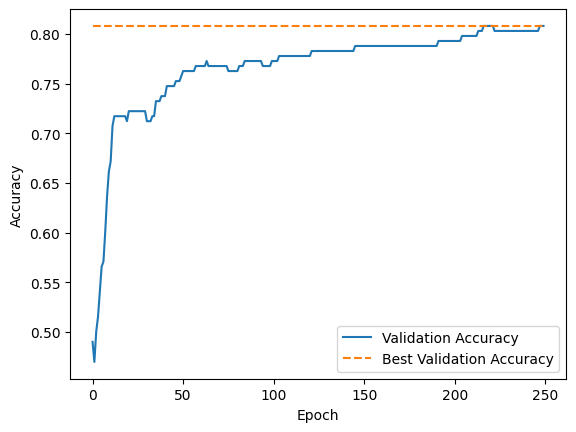

Accuracy (deep): 0.81
Epoch: 0, loss: 2.11669
Epoch: 10, loss: 0.67558
Epoch: 20, loss: 0.56243
Epoch: 30, loss: 0.52978
Epoch: 40, loss: 0.49928
Epoch: 50, loss: 0.47611
Epoch: 60, loss: 0.46679
Epoch: 70, loss: 0.45632
Epoch: 80, loss: 0.44567
Epoch: 90, loss: 0.43643
Epoch: 100, loss: 0.42733
Epoch: 110, loss: 0.41922
Epoch: 120, loss: 0.41117
Epoch: 130, loss: 0.40341
Epoch: 140, loss: 0.39636
Epoch: 150, loss: 0.38989
Epoch: 160, loss: 0.38353
Epoch: 170, loss: 0.37734
Epoch: 180, loss: 0.37162
Epoch: 190, loss: 0.36583
Epoch: 200, loss: 0.36019
Epoch: 210, loss: 0.35449
Epoch: 220, loss: 0.34885
Epoch: 230, loss: 0.34361
Epoch: 240, loss: 0.33871
Epoch: 249, loss: 0.33401


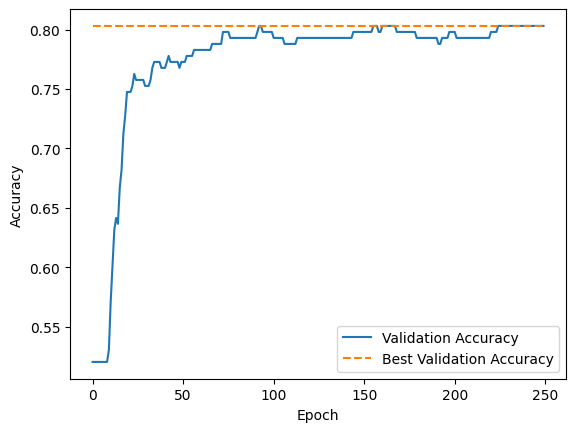

Accuracy (deep): 0.80
Epoch: 0, loss: 0.80944
Epoch: 10, loss: 0.46610
Epoch: 20, loss: 0.36737
Epoch: 30, loss: 0.34032
Epoch: 40, loss: 0.32737
Epoch: 50, loss: 0.31822
Epoch: 60, loss: 0.31292
Epoch: 70, loss: 0.30653
Epoch: 80, loss: 0.30124
Epoch: 90, loss: 0.29865
Epoch: 100, loss: 0.29538
Epoch: 110, loss: 0.29227
Epoch: 120, loss: 0.28952
Epoch: 130, loss: 0.28706
Epoch: 140, loss: 0.28518
Epoch: 150, loss: 0.28338
Epoch: 160, loss: 0.28138
Epoch: 170, loss: 0.27975
Epoch: 180, loss: 0.27826
Epoch: 190, loss: 0.27681
Epoch: 200, loss: 0.27519
Epoch: 210, loss: 0.27392
Epoch: 220, loss: 0.27286
Epoch: 230, loss: 0.27166
Epoch: 240, loss: 0.27023
Epoch: 249, loss: 0.26877


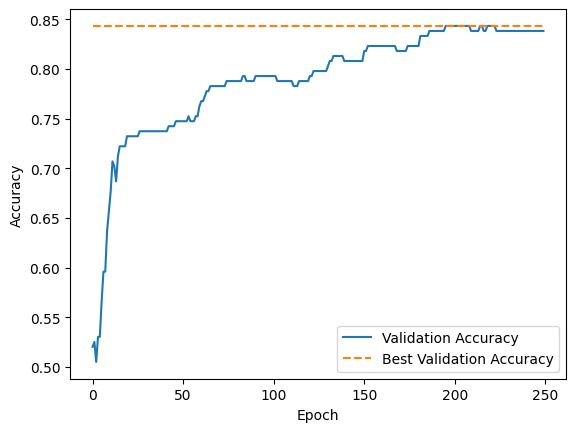

Accuracy (deep): 0.84
Epoch: 0, loss: 1.28260
Epoch: 10, loss: 0.71408
Epoch: 20, loss: 0.51887
Epoch: 30, loss: 0.46950
Epoch: 40, loss: 0.44181
Epoch: 50, loss: 0.42439
Epoch: 60, loss: 0.41306
Epoch: 70, loss: 0.40415
Epoch: 80, loss: 0.39588
Epoch: 90, loss: 0.38649
Epoch: 100, loss: 0.37796
Epoch: 110, loss: 0.37086
Epoch: 120, loss: 0.36408
Epoch: 130, loss: 0.35782
Epoch: 140, loss: 0.35273
Epoch: 150, loss: 0.34788
Epoch: 160, loss: 0.34342
Epoch: 170, loss: 0.33934
Epoch: 180, loss: 0.33574
Epoch: 190, loss: 0.33264
Epoch: 200, loss: 0.32959
Epoch: 210, loss: 0.32652
Epoch: 220, loss: 0.32339
Epoch: 230, loss: 0.32017
Epoch: 240, loss: 0.31687
Epoch: 249, loss: 0.31413


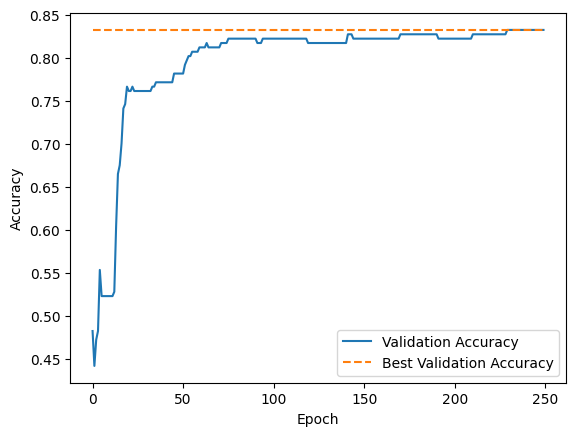

Accuracy (deep): 0.83
Epoch: 0, loss: 0.86816
Epoch: 10, loss: 0.42262
Epoch: 20, loss: 0.41344
Epoch: 30, loss: 0.40916
Epoch: 40, loss: 0.40352
Epoch: 50, loss: 0.40249
Epoch: 60, loss: 0.40077
Epoch: 70, loss: 0.39679
Epoch: 80, loss: 0.39245
Epoch: 90, loss: 0.38788
Epoch: 100, loss: 0.38380
Epoch: 110, loss: 0.37913
Epoch: 120, loss: 0.37488
Epoch: 130, loss: 0.37019
Epoch: 140, loss: 0.36624
Epoch: 150, loss: 0.36260
Epoch: 160, loss: 0.35875
Epoch: 170, loss: 0.35505
Epoch: 180, loss: 0.35155
Epoch: 190, loss: 0.34871
Epoch: 200, loss: 0.34580
Epoch: 210, loss: 0.34298
Epoch: 220, loss: 0.34012
Epoch: 230, loss: 0.33733
Epoch: 240, loss: 0.33503
Epoch: 249, loss: 0.33302


Accuracy (deep): 0.83
Epoch: 0, loss: 1.22229
Epoch: 10, loss: 0.97907
Epoch: 20, loss: 0.82400
Epoch: 30, loss: 0.72385
Epoch: 40, loss: 0.66142
Epoch: 50, loss: 0.62104
Epoch: 60, loss: 0.59319
Epoch: 70, loss: 0.57323
Epoch: 80, loss: 0.55882
Epoch: 90, loss: 0.54844
Epoch: 100, loss: 0.54104
Epoch: 110, loss: 0.53583
Epoch: 120, loss: 0.53225
Epoch: 130, loss: 0.52990
Epoch: 140, loss: 0.52849
Epoch: 150, loss: 0.52780
Epoch: 160, loss: 0.52763
Epoch: 170, loss: 0.52786
Epoch: 180, loss: 0.52836
Epoch: 190, loss: 0.52904
Epoch: 200, loss: 0.52983
Epoch: 210, loss: 0.53067
Epoch: 220, loss: 0.53151
Epoch: 230, loss: 0.53231
Epoch: 240, loss: 0.53305
Epoch: 249, loss: 0.53365


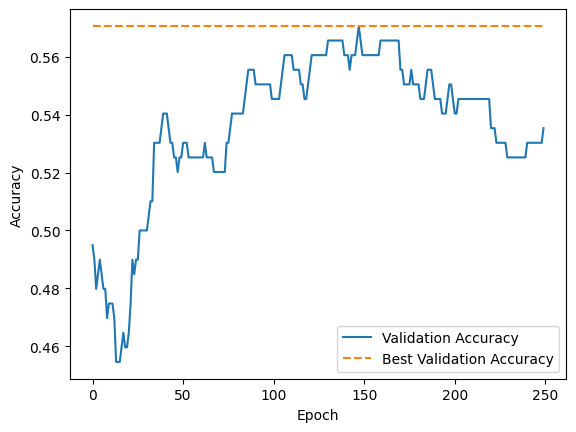

Accuracy (pbm): 0.57
Epoch: 0, loss: 0.82485
Epoch: 10, loss: 0.72954
Epoch: 20, loss: 0.67937
Epoch: 30, loss: 0.66022
Epoch: 40, loss: 0.65374
Epoch: 50, loss: 0.64776
Epoch: 60, loss: 0.64004
Epoch: 70, loss: 0.63199
Epoch: 80, loss: 0.62478
Epoch: 90, loss: 0.61876
Epoch: 100, loss: 0.61385
Epoch: 110, loss: 0.60984
Epoch: 120, loss: 0.60657
Epoch: 130, loss: 0.60391
Epoch: 140, loss: 0.60177
Epoch: 150, loss: 0.60008
Epoch: 160, loss: 0.59878
Epoch: 170, loss: 0.59779
Epoch: 180, loss: 0.59707
Epoch: 190, loss: 0.59656
Epoch: 200, loss: 0.59622
Epoch: 210, loss: 0.59600
Epoch: 220, loss: 0.59587
Epoch: 230, loss: 0.59580
Epoch: 240, loss: 0.59577
Epoch: 249, loss: 0.59575


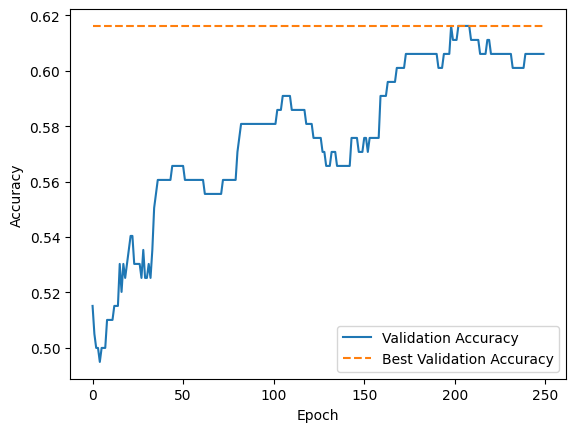

Accuracy (pbm): 0.62
Epoch: 0, loss: 1.13986
Epoch: 10, loss: 0.93440
Epoch: 20, loss: 0.82609
Epoch: 30, loss: 0.76780
Epoch: 40, loss: 0.73390
Epoch: 50, loss: 0.70813
Epoch: 60, loss: 0.68570
Epoch: 70, loss: 0.66671
Epoch: 80, loss: 0.65152
Epoch: 90, loss: 0.63985
Epoch: 100, loss: 0.63111
Epoch: 110, loss: 0.62473
Epoch: 120, loss: 0.62021
Epoch: 130, loss: 0.61715
Epoch: 140, loss: 0.61525
Epoch: 150, loss: 0.61425
Epoch: 160, loss: 0.61395
Epoch: 170, loss: 0.61418
Epoch: 180, loss: 0.61478
Epoch: 190, loss: 0.61564
Epoch: 200, loss: 0.61667
Epoch: 210, loss: 0.61777
Epoch: 220, loss: 0.61890
Epoch: 230, loss: 0.61999
Epoch: 240, loss: 0.62103
Epoch: 249, loss: 0.62190


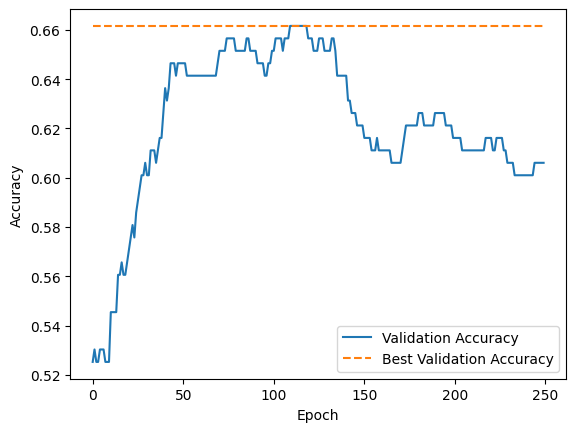

Accuracy (pbm): 0.66
Epoch: 0, loss: 1.13257
Epoch: 10, loss: 0.92108
Epoch: 20, loss: 0.80309
Epoch: 30, loss: 0.73817
Epoch: 40, loss: 0.70237
Epoch: 50, loss: 0.67848
Epoch: 60, loss: 0.65936
Epoch: 70, loss: 0.64341
Epoch: 80, loss: 0.63040
Epoch: 90, loss: 0.62012
Epoch: 100, loss: 0.61217
Epoch: 110, loss: 0.60615
Epoch: 120, loss: 0.60170
Epoch: 130, loss: 0.59852
Epoch: 140, loss: 0.59637
Epoch: 150, loss: 0.59503
Epoch: 160, loss: 0.59433
Epoch: 170, loss: 0.59414
Epoch: 180, loss: 0.59431
Epoch: 190, loss: 0.59475
Epoch: 200, loss: 0.59536
Epoch: 210, loss: 0.59606
Epoch: 220, loss: 0.59680
Epoch: 230, loss: 0.59752
Epoch: 240, loss: 0.59820
Epoch: 249, loss: 0.59875


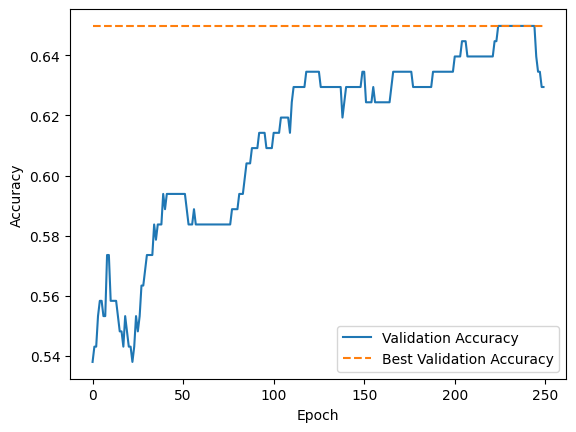

Accuracy (pbm): 0.65
Epoch: 0, loss: 1.15903
Epoch: 10, loss: 0.94551
Epoch: 20, loss: 0.82866
Epoch: 30, loss: 0.76538
Epoch: 40, loss: 0.73315
Epoch: 50, loss: 0.71333
Epoch: 60, loss: 0.69823
Epoch: 70, loss: 0.68628
Epoch: 80, loss: 0.67722
Epoch: 90, loss: 0.67071
Epoch: 100, loss: 0.66634
Epoch: 110, loss: 0.66367
Epoch: 120, loss: 0.66229
Epoch: 130, loss: 0.66190
Epoch: 140, loss: 0.66224
Epoch: 150, loss: 0.66308
Epoch: 160, loss: 0.66426
Epoch: 170, loss: 0.66564
Epoch: 180, loss: 0.66711
Epoch: 190, loss: 0.66860
Epoch: 200, loss: 0.67004
Epoch: 210, loss: 0.67140
Epoch: 220, loss: 0.67263
Epoch: 230, loss: 0.67374
Epoch: 240, loss: 0.67472
Epoch: 249, loss: 0.67548


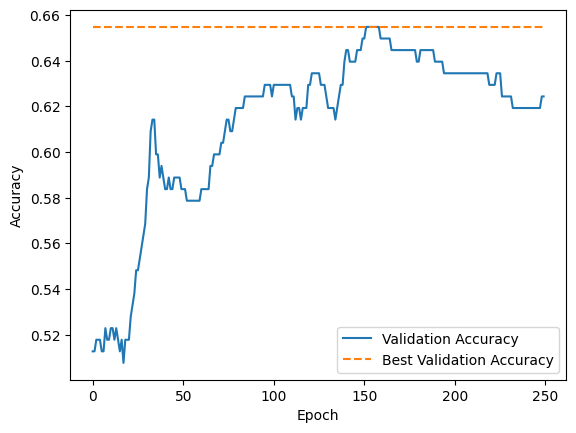

Accuracy (pbm): 0.65


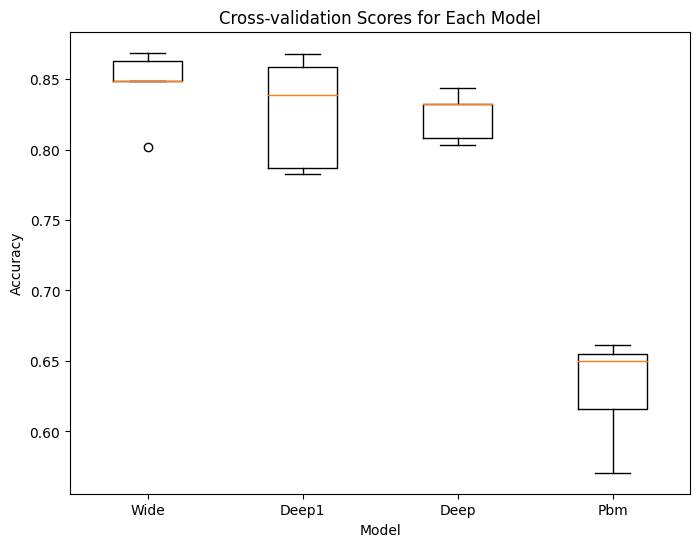

Wide: 84.61% (+/- 2.34%)
Deep1: 82.69% (+/- 3.57%)
Deep: 82.39% (+/- 1.56%)
Pbm: 63.06% (+/- 3.38%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




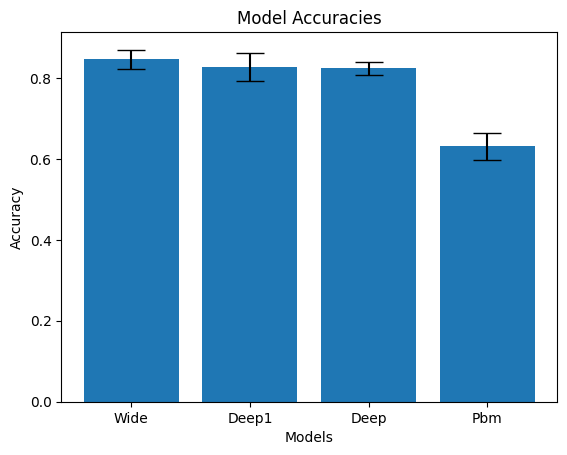

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_30.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

           DV1       DV2       DV3          V          G1         G2  \
0    -0.039624 -0.704088 -6.842760  14.462760  162.190786  10.986211   
1     0.170688 -0.847344 -6.967728  14.587728  162.178594  11.059363   
2     0.240792 -1.033272 -7.135368  14.755368  162.138360  11.146841   
3     0.152400 -1.246632 -7.342632  14.962632  162.106966  11.261446   
4     0.006096 -1.420368 -7.516368  15.136368  162.101174  11.402873   
...        ...       ...       ...        ...         ...        ...   
2346 -0.871728  9.448800  5.599176   5.455920   10.931957  33.089393   
2347 -0.969264  9.217152  5.660136   5.620512   11.023397  32.158534   
2348 -1.054608  9.058656  5.562600   5.815584   11.126419  31.256630   
2349 -1.103376  9.015984  4.687824   5.980176   11.239805  30.364786   
2350 -1.109472  9.079992  4.593336   6.074664   11.353800  29.467454   

              G3        Dend     Carid  label_targetlane  
0     194.150894  156.831182 -1.513025                 0  
1     193.465094 

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([2351, 9])
torch.Size([2351, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(-0.0111, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0.0159, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0921, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(-0.0705, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(-0.0488, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(0.0104, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 18.83967
Epoch: 10, loss: 1.86514
Epoch: 20, loss: 1.43422
Epoch: 30, loss: 1.06432
Epoch: 40, loss: 0.83610
Epoch: 50, loss: 0.73648
Epoch: 60, loss: 0.68666
Epoch: 70, loss: 0.64829
Epoch: 80, loss: 0.61718
Epoch: 90, loss: 0.59378
Epoch: 100, loss: 0.57603
Epoch: 110, loss: 0.56193
Epoch: 120, loss: 0.55118
Epoch: 130, loss: 0.54277
Epoch: 140, loss: 0.53548
Epoch: 150, loss: 0.52785
Epoch: 160, loss: 0.52195
Epoch: 170, loss: 0.51685
Epoch: 180, loss: 0.51258
Epoch: 190, loss: 0.50869
Epoch: 200, loss: 0.50544
Epoch: 210, loss: 0.50267
Epoch: 220, loss: 0.50000
Epoch: 230, loss: 0.49763
Epoch: 240, loss: 0.49515
Epoch: 249, loss: 0.49304


Accuracy (wide): 0.80
Epoch: 0, loss: 0.24182
Epoch: 10, loss: 0.74615
Epoch: 20, loss: 0.59667
Epoch: 30, loss: 0.48622
Epoch: 40, loss: 0.45143
Epoch: 50, loss: 0.44478
Epoch: 60, loss: 0.44780
Epoch: 70, loss: 0.45311
Epoch: 80, loss: 0.45781
Epoch: 90, loss: 0.46122
Epoch: 100, loss: 0.46440
Epoch: 110, loss: 0.46642
Epoch: 120, loss: 0.46676
Epoch: 130, loss: 0.46592
Epoch: 140, loss: 0.46376
Epoch: 150, loss: 0.46104
Epoch: 160, loss: 0.45750
Epoch: 170, loss: 0.45398
Epoch: 180, loss: 0.45036
Epoch: 190, loss: 0.44679
Epoch: 200, loss: 0.44349
Epoch: 210, loss: 0.44017
Epoch: 220, loss: 0.43720
Epoch: 230, loss: 0.43454
Epoch: 240, loss: 0.43185
Epoch: 249, loss: 0.42983


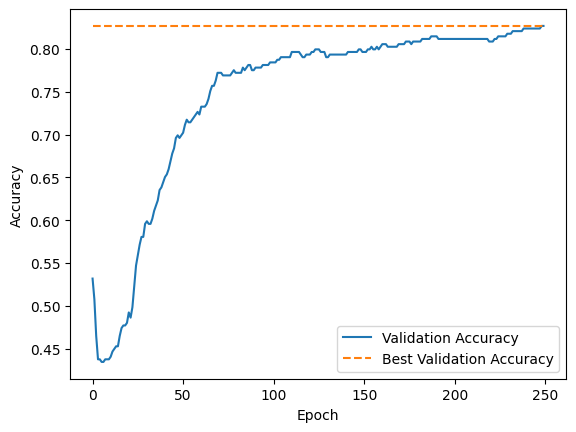

Accuracy (wide): 0.83
Epoch: 0, loss: 15.34878
Epoch: 10, loss: 0.71851
Epoch: 20, loss: 0.59541
Epoch: 30, loss: 0.58704
Epoch: 40, loss: 0.58439
Epoch: 50, loss: 0.57890
Epoch: 60, loss: 0.57214
Epoch: 70, loss: 0.56303
Epoch: 80, loss: 0.55286
Epoch: 90, loss: 0.54262
Epoch: 100, loss: 0.53275
Epoch: 110, loss: 0.52279
Epoch: 120, loss: 0.51353
Epoch: 130, loss: 0.50461
Epoch: 140, loss: 0.49605
Epoch: 150, loss: 0.48803
Epoch: 160, loss: 0.48066
Epoch: 170, loss: 0.47390
Epoch: 180, loss: 0.46765
Epoch: 190, loss: 0.46151
Epoch: 200, loss: 0.45524
Epoch: 210, loss: 0.44938
Epoch: 220, loss: 0.44396
Epoch: 230, loss: 0.43832
Epoch: 240, loss: 0.43291
Epoch: 249, loss: 0.42858


Accuracy (wide): 0.78
Epoch: 0, loss: 1.80221
Epoch: 10, loss: 0.90698
Epoch: 20, loss: 0.62555
Epoch: 30, loss: 0.52271
Epoch: 40, loss: 0.47969
Epoch: 50, loss: 0.46398
Epoch: 60, loss: 0.45637
Epoch: 70, loss: 0.44977
Epoch: 80, loss: 0.44187
Epoch: 90, loss: 0.43378
Epoch: 100, loss: 0.42562
Epoch: 110, loss: 0.41805
Epoch: 120, loss: 0.41133
Epoch: 130, loss: 0.40562
Epoch: 140, loss: 0.40079
Epoch: 150, loss: 0.39602
Epoch: 160, loss: 0.39139
Epoch: 170, loss: 0.38743
Epoch: 180, loss: 0.38341
Epoch: 190, loss: 0.37981
Epoch: 200, loss: 0.37640
Epoch: 210, loss: 0.37300
Epoch: 220, loss: 0.36953
Epoch: 230, loss: 0.36627
Epoch: 240, loss: 0.36337
Epoch: 249, loss: 0.36093


Accuracy (wide): 0.81
Epoch: 0, loss: 2.18851
Epoch: 10, loss: 1.41966
Epoch: 20, loss: 1.12075
Epoch: 30, loss: 0.99343
Epoch: 40, loss: 0.88667
Epoch: 50, loss: 0.80460
Epoch: 60, loss: 0.74552
Epoch: 70, loss: 0.70099
Epoch: 80, loss: 0.66629
Epoch: 90, loss: 0.63885
Epoch: 100, loss: 0.61652
Epoch: 110, loss: 0.59723
Epoch: 120, loss: 0.58093
Epoch: 130, loss: 0.56686
Epoch: 140, loss: 0.55460
Epoch: 150, loss: 0.54347
Epoch: 160, loss: 0.53291
Epoch: 170, loss: 0.52320
Epoch: 180, loss: 0.51404
Epoch: 190, loss: 0.50580
Epoch: 200, loss: 0.49792
Epoch: 210, loss: 0.49020
Epoch: 220, loss: 0.48244
Epoch: 230, loss: 0.47504
Epoch: 240, loss: 0.46825
Epoch: 249, loss: 0.46254


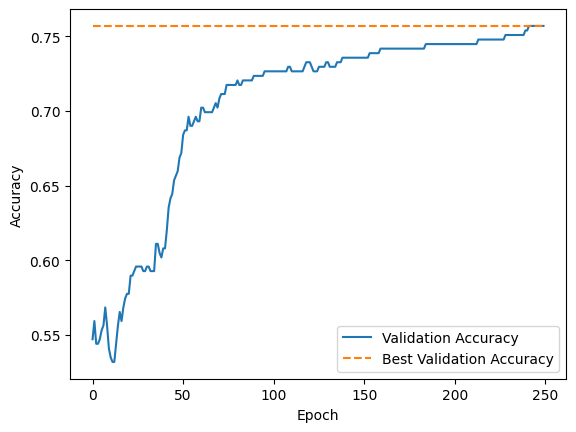

Accuracy (wide): 0.76
Epoch: 0, loss: 0.73304
Epoch: 10, loss: 0.64879
Epoch: 20, loss: 0.59361
Epoch: 30, loss: 0.57217
Epoch: 40, loss: 0.55817
Epoch: 50, loss: 0.54746
Epoch: 60, loss: 0.53855
Epoch: 70, loss: 0.53219
Epoch: 80, loss: 0.52386
Epoch: 90, loss: 0.51509
Epoch: 100, loss: 0.50906
Epoch: 110, loss: 0.50336
Epoch: 120, loss: 0.49747
Epoch: 130, loss: 0.49226
Epoch: 140, loss: 0.48692
Epoch: 150, loss: 0.48287
Epoch: 160, loss: 0.47890
Epoch: 170, loss: 0.47470
Epoch: 180, loss: 0.47134
Epoch: 190, loss: 0.46784
Epoch: 200, loss: 0.46446
Epoch: 210, loss: 0.46097
Epoch: 220, loss: 0.45757
Epoch: 230, loss: 0.45427
Epoch: 240, loss: 0.45089
Epoch: 249, loss: 0.44798


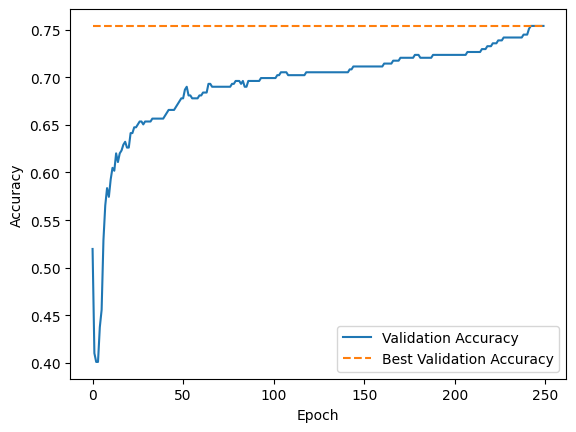

Accuracy (deep1): 0.75
Epoch: 0, loss: 0.66292
Epoch: 10, loss: 0.57343
Epoch: 20, loss: 0.56687
Epoch: 30, loss: 0.56175
Epoch: 40, loss: 0.55667
Epoch: 50, loss: 0.54983
Epoch: 60, loss: 0.54102
Epoch: 70, loss: 0.53376
Epoch: 80, loss: 0.52605
Epoch: 90, loss: 0.51701
Epoch: 100, loss: 0.50972
Epoch: 110, loss: 0.50262
Epoch: 120, loss: 0.49585
Epoch: 130, loss: 0.49009
Epoch: 140, loss: 0.48434
Epoch: 150, loss: 0.47893
Epoch: 160, loss: 0.47265
Epoch: 170, loss: 0.46579
Epoch: 180, loss: 0.45953
Epoch: 190, loss: 0.45459
Epoch: 200, loss: 0.44938
Epoch: 210, loss: 0.44418
Epoch: 220, loss: 0.43935
Epoch: 230, loss: 0.43493
Epoch: 240, loss: 0.43059
Epoch: 249, loss: 0.42587


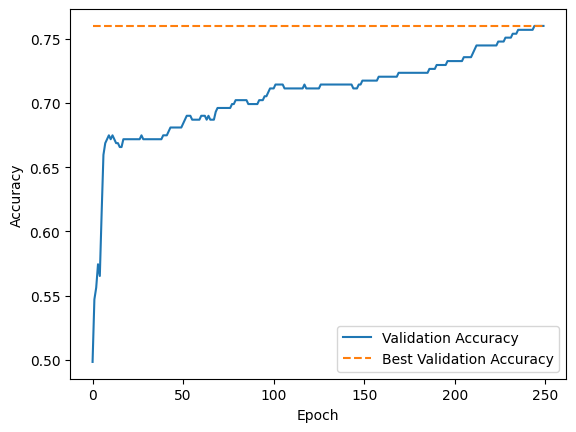

Accuracy (deep1): 0.76
Epoch: 0, loss: 0.67300
Epoch: 10, loss: 0.64843
Epoch: 20, loss: 0.64926
Epoch: 30, loss: 0.64449
Epoch: 40, loss: 0.63787
Epoch: 50, loss: 0.63037
Epoch: 60, loss: 0.62466
Epoch: 70, loss: 0.62026
Epoch: 80, loss: 0.61453
Epoch: 90, loss: 0.60655
Epoch: 100, loss: 0.60037
Epoch: 110, loss: 0.59446
Epoch: 120, loss: 0.58765
Epoch: 130, loss: 0.58127
Epoch: 140, loss: 0.57553
Epoch: 150, loss: 0.56914
Epoch: 160, loss: 0.56176
Epoch: 170, loss: 0.55531
Epoch: 180, loss: 0.54817
Epoch: 190, loss: 0.54075
Epoch: 200, loss: 0.53366
Epoch: 210, loss: 0.52643
Epoch: 220, loss: 0.51881
Epoch: 230, loss: 0.51169
Epoch: 240, loss: 0.50523
Epoch: 249, loss: 0.49935


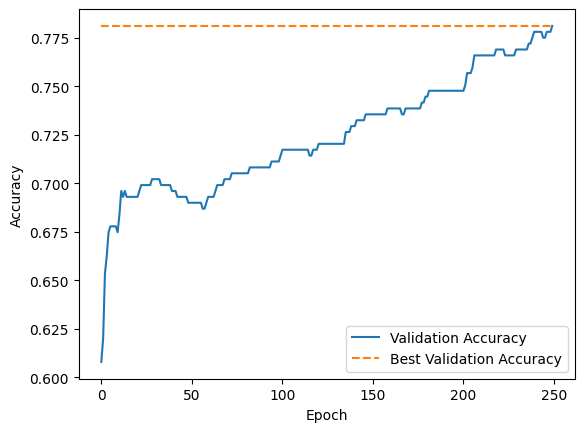

Accuracy (deep1): 0.78
Epoch: 0, loss: 0.89971
Epoch: 10, loss: 0.62809
Epoch: 20, loss: 0.60303
Epoch: 30, loss: 0.59014
Epoch: 40, loss: 0.57899
Epoch: 50, loss: 0.57200
Epoch: 60, loss: 0.56323
Epoch: 70, loss: 0.55334
Epoch: 80, loss: 0.54490
Epoch: 90, loss: 0.53692
Epoch: 100, loss: 0.52823
Epoch: 110, loss: 0.52129
Epoch: 120, loss: 0.51088
Epoch: 130, loss: 0.50209
Epoch: 140, loss: 0.49267
Epoch: 150, loss: 0.48427
Epoch: 160, loss: 0.47647
Epoch: 170, loss: 0.46875
Epoch: 180, loss: 0.46180
Epoch: 190, loss: 0.45491
Epoch: 200, loss: 0.44772
Epoch: 210, loss: 0.43955
Epoch: 220, loss: 0.43123
Epoch: 230, loss: 0.42330
Epoch: 240, loss: 0.41552
Epoch: 249, loss: 0.40874


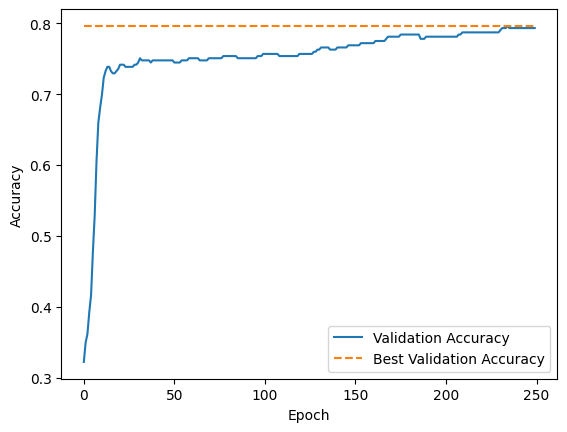

Accuracy (deep1): 0.80
Epoch: 0, loss: 0.90186
Epoch: 10, loss: 0.55523
Epoch: 20, loss: 0.53102
Epoch: 30, loss: 0.52530
Epoch: 40, loss: 0.51849
Epoch: 50, loss: 0.51256
Epoch: 60, loss: 0.50968
Epoch: 70, loss: 0.50869
Epoch: 80, loss: 0.50648
Epoch: 90, loss: 0.50358
Epoch: 100, loss: 0.50065
Epoch: 110, loss: 0.49767
Epoch: 120, loss: 0.49472
Epoch: 130, loss: 0.49102
Epoch: 140, loss: 0.48798
Epoch: 150, loss: 0.48403
Epoch: 160, loss: 0.47998
Epoch: 170, loss: 0.47574
Epoch: 180, loss: 0.47204
Epoch: 190, loss: 0.46866
Epoch: 200, loss: 0.46481
Epoch: 210, loss: 0.46051
Epoch: 220, loss: 0.45628
Epoch: 230, loss: 0.45207
Epoch: 240, loss: 0.44835
Epoch: 249, loss: 0.44470


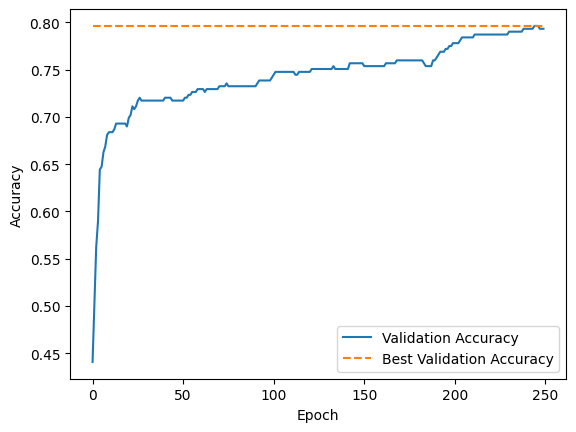

Accuracy (deep1): 0.80
Epoch: 0, loss: 0.69831
Epoch: 10, loss: 0.58353
Epoch: 20, loss: 0.54513
Epoch: 30, loss: 0.52976
Epoch: 40, loss: 0.51715
Epoch: 50, loss: 0.50754
Epoch: 60, loss: 0.49884
Epoch: 70, loss: 0.49244
Epoch: 80, loss: 0.48736
Epoch: 90, loss: 0.48285
Epoch: 100, loss: 0.47882
Epoch: 110, loss: 0.47524
Epoch: 120, loss: 0.47277
Epoch: 130, loss: 0.47005
Epoch: 140, loss: 0.46651
Epoch: 150, loss: 0.46262
Epoch: 160, loss: 0.45802
Epoch: 170, loss: 0.45352
Epoch: 180, loss: 0.44942
Epoch: 190, loss: 0.44508
Epoch: 200, loss: 0.44092
Epoch: 210, loss: 0.43703
Epoch: 220, loss: 0.43319
Epoch: 230, loss: 0.42895
Epoch: 240, loss: 0.42522
Epoch: 249, loss: 0.42151


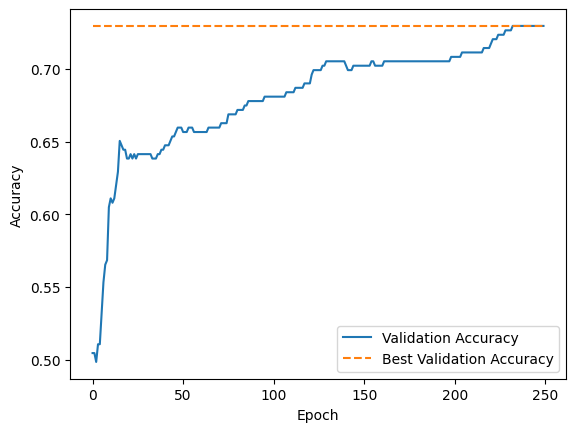

Accuracy (deep): 0.73
Epoch: 0, loss: 0.61847
Epoch: 10, loss: 0.60987
Epoch: 20, loss: 0.59840
Epoch: 30, loss: 0.59760
Epoch: 40, loss: 0.59291
Epoch: 50, loss: 0.58646
Epoch: 60, loss: 0.58123
Epoch: 70, loss: 0.57480
Epoch: 80, loss: 0.56768
Epoch: 90, loss: 0.56132
Epoch: 100, loss: 0.55486
Epoch: 110, loss: 0.54792
Epoch: 120, loss: 0.54058
Epoch: 130, loss: 0.53462
Epoch: 140, loss: 0.52757
Epoch: 150, loss: 0.52036
Epoch: 160, loss: 0.51111
Epoch: 170, loss: 0.50127
Epoch: 180, loss: 0.49396
Epoch: 190, loss: 0.48831
Epoch: 200, loss: 0.48262
Epoch: 210, loss: 0.47589
Epoch: 220, loss: 0.46908
Epoch: 230, loss: 0.46262
Epoch: 240, loss: 0.45649
Epoch: 249, loss: 0.45183


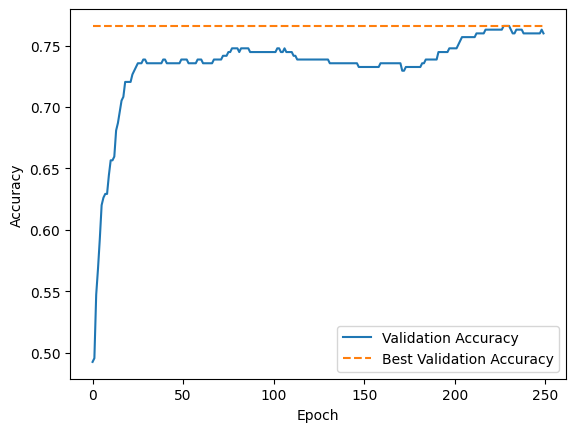

Accuracy (deep): 0.77
Epoch: 0, loss: 1.48338
Epoch: 10, loss: 0.55837
Epoch: 20, loss: 0.53874
Epoch: 30, loss: 0.53596
Epoch: 40, loss: 0.53393
Epoch: 50, loss: 0.53117
Epoch: 60, loss: 0.52862
Epoch: 70, loss: 0.52570
Epoch: 80, loss: 0.52060
Epoch: 90, loss: 0.51486
Epoch: 100, loss: 0.51107
Epoch: 110, loss: 0.50530
Epoch: 120, loss: 0.49713
Epoch: 130, loss: 0.49045
Epoch: 140, loss: 0.48430
Epoch: 150, loss: 0.47836
Epoch: 160, loss: 0.47159
Epoch: 170, loss: 0.46493
Epoch: 180, loss: 0.45850
Epoch: 190, loss: 0.45166
Epoch: 200, loss: 0.44431
Epoch: 210, loss: 0.43719
Epoch: 220, loss: 0.42935
Epoch: 230, loss: 0.42106
Epoch: 240, loss: 0.41355
Epoch: 249, loss: 0.40711


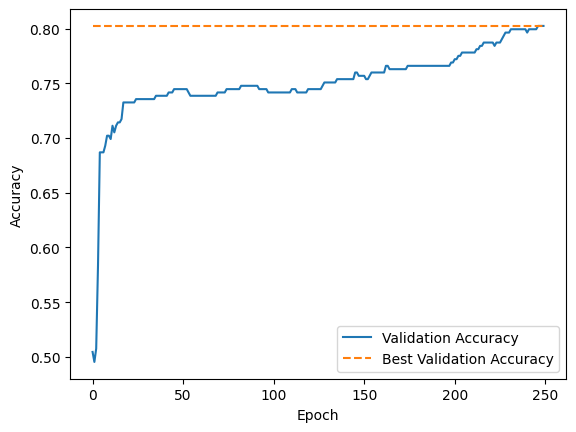

Accuracy (deep): 0.80
Epoch: 0, loss: 2.65480
Epoch: 10, loss: 0.61202
Epoch: 20, loss: 0.55652
Epoch: 30, loss: 0.53842
Epoch: 40, loss: 0.53120
Epoch: 50, loss: 0.52824
Epoch: 60, loss: 0.52556
Epoch: 70, loss: 0.52414
Epoch: 80, loss: 0.52345
Epoch: 90, loss: 0.52048
Epoch: 100, loss: 0.51990
Epoch: 110, loss: 0.51877
Epoch: 120, loss: 0.51644
Epoch: 130, loss: 0.51383
Epoch: 140, loss: 0.51152
Epoch: 150, loss: 0.50836
Epoch: 160, loss: 0.50568
Epoch: 170, loss: 0.50212
Epoch: 180, loss: 0.49929
Epoch: 190, loss: 0.49645
Epoch: 200, loss: 0.49361
Epoch: 210, loss: 0.49160
Epoch: 220, loss: 0.48871
Epoch: 230, loss: 0.48502
Epoch: 240, loss: 0.48169
Epoch: 249, loss: 0.47861


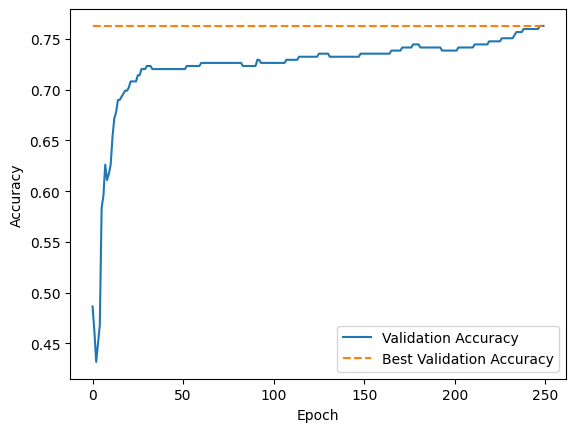

Accuracy (deep): 0.76
Epoch: 0, loss: 3.69166
Epoch: 10, loss: 0.66487
Epoch: 20, loss: 0.63401
Epoch: 30, loss: 0.62302
Epoch: 40, loss: 0.61442
Epoch: 50, loss: 0.60410
Epoch: 60, loss: 0.59178
Epoch: 70, loss: 0.57603
Epoch: 80, loss: 0.56757
Epoch: 90, loss: 0.55962
Epoch: 100, loss: 0.55236
Epoch: 110, loss: 0.54568
Epoch: 120, loss: 0.53907
Epoch: 130, loss: 0.53269
Epoch: 140, loss: 0.52589
Epoch: 150, loss: 0.51894
Epoch: 160, loss: 0.51156
Epoch: 170, loss: 0.50527
Epoch: 180, loss: 0.49950
Epoch: 190, loss: 0.49368
Epoch: 200, loss: 0.48836
Epoch: 210, loss: 0.48297
Epoch: 220, loss: 0.47770
Epoch: 230, loss: 0.47222
Epoch: 240, loss: 0.46665
Epoch: 249, loss: 0.46201


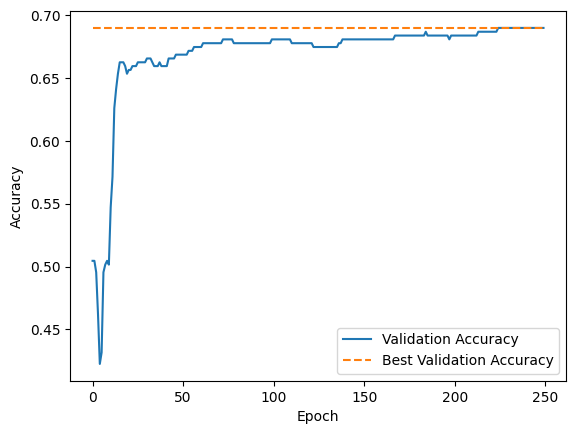

Accuracy (deep): 0.69
Epoch: 0, loss: 1.61265
Epoch: 10, loss: 1.18530
Epoch: 20, loss: 1.08182
Epoch: 30, loss: 1.06016
Epoch: 40, loss: 1.03789
Epoch: 50, loss: 1.06833
Epoch: 60, loss: 1.07951
Epoch: 70, loss: 1.11386
Epoch: 80, loss: 1.13647
Epoch: 90, loss: 1.16700
Epoch: 100, loss: 1.16561
Epoch: 110, loss: 1.16411
Epoch: 120, loss: 1.16244
Epoch: 130, loss: 1.16055
Epoch: 140, loss: 1.15834
Epoch: 150, loss: 1.15560
Epoch: 160, loss: 1.13965
Epoch: 170, loss: 1.14678
Epoch: 180, loss: 1.14760
Epoch: 190, loss: 1.14789
Epoch: 200, loss: 1.14820
Epoch: 210, loss: 1.14856
Epoch: 220, loss: 1.14899
Epoch: 230, loss: 1.14946
Epoch: 240, loss: 1.14984
Epoch: 249, loss: 1.14924


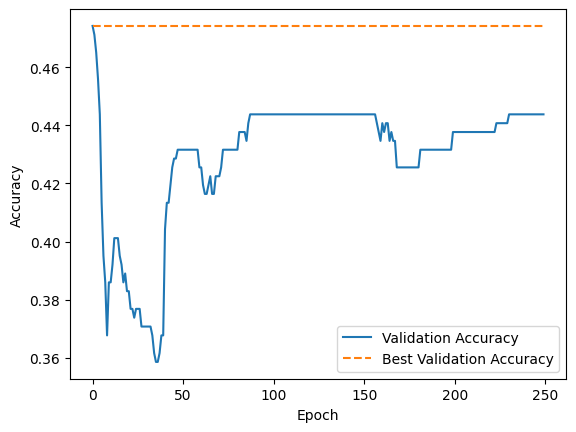

Accuracy (pbm): 0.47
Epoch: 0, loss: 8.19088
Epoch: 10, loss: 7.67022
Epoch: 20, loss: 7.43835
Epoch: 30, loss: 7.42015
Epoch: 40, loss: 7.37996
Epoch: 50, loss: 1.98385
Epoch: 60, loss: 1.93930
Epoch: 70, loss: 1.91085
Epoch: 80, loss: 1.84243
Epoch: 90, loss: 1.84051
Epoch: 100, loss: 1.83929
Epoch: 110, loss: 1.83697
Epoch: 120, loss: 1.83559
Epoch: 130, loss: 1.83407
Epoch: 140, loss: 1.83136
Epoch: 150, loss: 1.82838
Epoch: 160, loss: 1.82507
Epoch: 170, loss: 1.82130
Epoch: 180, loss: 1.82193
Epoch: 190, loss: 1.85069
Epoch: 200, loss: 1.84577
Epoch: 210, loss: 1.83883
Epoch: 220, loss: 1.82871
Epoch: 230, loss: 1.81673
Epoch: 240, loss: 1.80159
Epoch: 249, loss: 1.78122


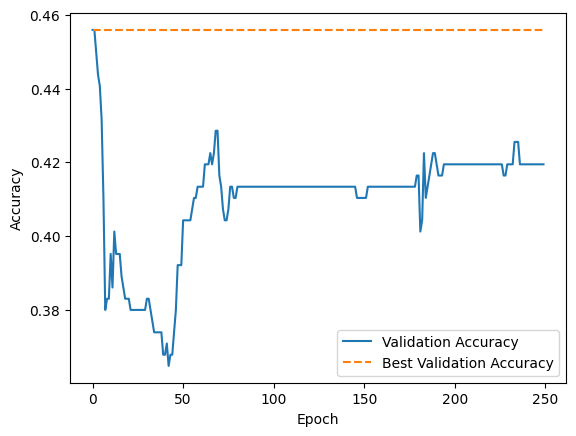

Accuracy (pbm): 0.46
Epoch: 0, loss: 7.49855
Epoch: 10, loss: 7.11701
Epoch: 20, loss: 6.92386
Epoch: 30, loss: 6.87780
Epoch: 40, loss: 1.54196
Epoch: 50, loss: 1.48686
Epoch: 60, loss: 1.47629
Epoch: 70, loss: 1.45647
Epoch: 80, loss: 1.41800
Epoch: 90, loss: 1.36457
Epoch: 100, loss: 1.33809
Epoch: 110, loss: 1.33734
Epoch: 120, loss: 1.33690
Epoch: 130, loss: 1.33614
Epoch: 140, loss: 1.33566
Epoch: 150, loss: 1.33482
Epoch: 160, loss: 1.33360
Epoch: 170, loss: 1.33229
Epoch: 180, loss: 1.33053
Epoch: 190, loss: 1.39167
Epoch: 200, loss: 1.41610
Epoch: 210, loss: 1.41300
Epoch: 220, loss: 1.40767
Epoch: 230, loss: 1.40094
Epoch: 240, loss: 1.39235
Epoch: 249, loss: 1.38241


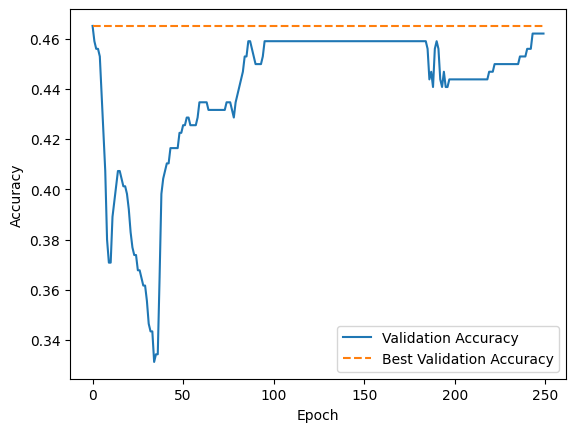

Accuracy (pbm): 0.47
Epoch: 0, loss: 8.11147
Epoch: 10, loss: 7.46046
Epoch: 20, loss: 7.23443
Epoch: 30, loss: 7.17460
Epoch: 40, loss: 1.73478
Epoch: 50, loss: 1.68800
Epoch: 60, loss: 1.67683
Epoch: 70, loss: 1.65846
Epoch: 80, loss: 1.61410
Epoch: 90, loss: 1.53941
Epoch: 100, loss: 1.49633
Epoch: 110, loss: 1.45322
Epoch: 120, loss: 1.45224
Epoch: 130, loss: 1.45145
Epoch: 140, loss: 1.45047
Epoch: 150, loss: 1.44915
Epoch: 160, loss: 1.49763
Epoch: 170, loss: 1.54000
Epoch: 180, loss: 1.54023
Epoch: 190, loss: 1.53826
Epoch: 200, loss: 1.53493
Epoch: 210, loss: 1.53103
Epoch: 220, loss: 1.52585
Epoch: 230, loss: 1.51888
Epoch: 240, loss: 1.51018
Epoch: 249, loss: 1.49928


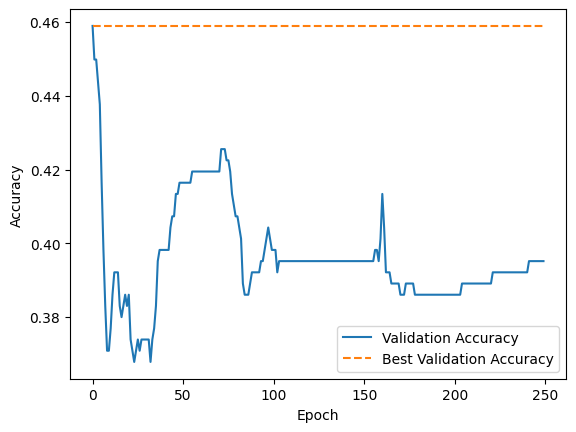

Accuracy (pbm): 0.46
Epoch: 0, loss: 7.76435
Epoch: 10, loss: 7.30252
Epoch: 20, loss: 7.16554
Epoch: 30, loss: 7.12404
Epoch: 40, loss: 1.79938
Epoch: 50, loss: 1.73000
Epoch: 60, loss: 1.70321
Epoch: 70, loss: 1.63318
Epoch: 80, loss: 1.60542
Epoch: 90, loss: 1.57497
Epoch: 100, loss: 1.57376
Epoch: 110, loss: 1.57249
Epoch: 120, loss: 1.57078
Epoch: 130, loss: 1.56935
Epoch: 140, loss: 1.55485
Epoch: 150, loss: 1.55286
Epoch: 160, loss: 1.55095
Epoch: 170, loss: 1.54847
Epoch: 180, loss: 1.54542
Epoch: 190, loss: 1.54191
Epoch: 200, loss: 1.55319
Epoch: 210, loss: 1.60973
Epoch: 220, loss: 1.60767
Epoch: 230, loss: 1.60113
Epoch: 240, loss: 1.58711
Epoch: 249, loss: 1.56043


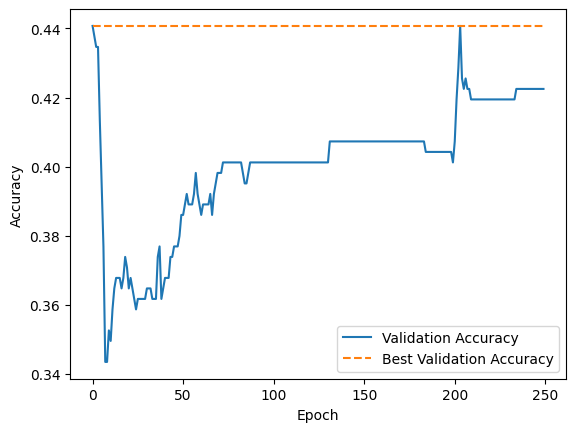

Accuracy (pbm): 0.44


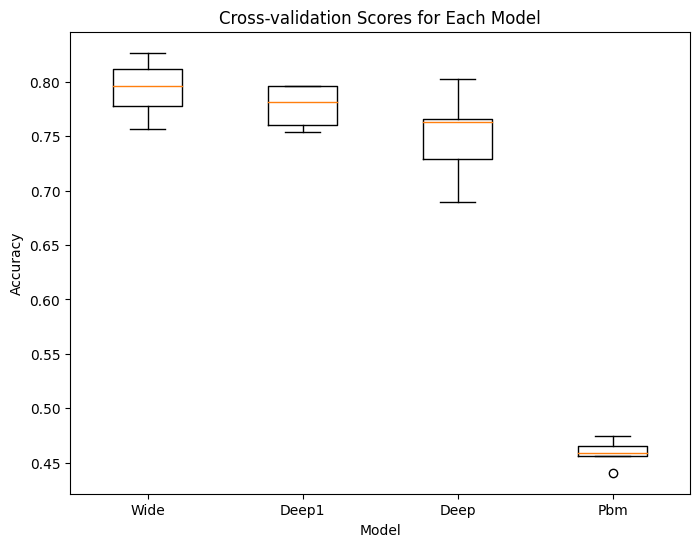

Wide: 79.39% (+/- 2.46%)
Deep1: 77.75% (+/- 1.79%)
Deep: 75.02% (+/- 3.79%)
Pbm: 45.90% (+/- 1.10%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_40.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

         DV1     DV2     DV3        V       G1       G2        G3      Dend  \
0     5.6510 -0.0180 -1.8500  12.0180  51.8584   5.6738  189.2200  170.6648   
1     5.4410  0.0740 -1.7310  12.0270  51.2894   5.6618  189.0500  171.8648   
2     5.0990  0.0850 -1.6550  12.0610  50.7544   5.6498  188.8700  173.0648   
3     4.7120  0.0670 -1.5520  12.1040  50.2644   5.6398  188.7200  174.2748   
4     0.0400  0.0580 -1.4930  12.1400   5.6348  17.3586  188.5700  175.4848   
...      ...     ...     ...      ...      ...      ...       ...       ...   
3057 -0.7955 -4.8341 -0.7193   9.4061  36.9568  17.3330  173.3328  176.5948   
3058 -0.9632 -5.0170 -0.4023   9.5890  37.0358  17.8170  173.2828  177.5448   
3059 -1.1979 -5.2578 -0.2713   9.8298  37.1398  18.3290  173.2528  178.5048   
3060 -1.4329 -5.5020 -0.3052  10.0740  37.2758  18.8690  173.2328  179.5048   
3061 -1.6306 -5.7210 -0.4541  10.2930  37.4328  19.4320  173.2028  180.5248   

         Carid  label_targetlane  
0     1.555776  

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([3062, 9])
torch.Size([3062, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(0.0418, requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(-0.4001, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(-0.0188, requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(-0.0367, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0498, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.0301, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(-0.0121, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(-0.0021, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 5.19589
Epoch: 10, loss: 1.50976
Epoch: 20, loss: 0.98991
Epoch: 30, loss: 0.59951
Epoch: 40, loss: 0.47572
Epoch: 50, loss: 0.44568
Epoch: 60, loss: 0.43772
Epoch: 70, loss: 0.43597
Epoch: 80, loss: 0.43608
Epoch: 90, loss: 0.43548
Epoch: 100, loss: 0.43428
Epoch: 110, loss: 0.43299
Epoch: 120, loss: 0.43217
Epoch: 130, loss: 0.43123
Epoch: 140, loss: 0.43058
Epoch: 150, loss: 0.43003
Epoch: 160, loss: 0.42998
Epoch: 170, loss: 0.42952
Epoch: 180, loss: 0.42890
Epoch: 190, loss: 0.42793
Epoch: 200, loss: 0.42681
Epoch: 210, loss: 0.42571
Epoch: 220, loss: 0.42435
Epoch: 230, loss: 0.42293
Epoch: 240, loss: 0.42133
Epoch: 249, loss: 0.41979


Accuracy (wide): 0.82
Epoch: 0, loss: 1.33127
Epoch: 10, loss: 0.50919
Epoch: 20, loss: 0.40573
Epoch: 30, loss: 0.36561
Epoch: 40, loss: 0.35156
Epoch: 50, loss: 0.35071
Epoch: 60, loss: 0.35597
Epoch: 70, loss: 0.36349
Epoch: 80, loss: 0.36858
Epoch: 90, loss: 0.37244
Epoch: 100, loss: 0.37476
Epoch: 110, loss: 0.37593
Epoch: 120, loss: 0.37635
Epoch: 130, loss: 0.37625
Epoch: 140, loss: 0.37570
Epoch: 150, loss: 0.37510
Epoch: 160, loss: 0.37424
Epoch: 170, loss: 0.37334
Epoch: 180, loss: 0.37252
Epoch: 190, loss: 0.37151
Epoch: 200, loss: 0.37067
Epoch: 210, loss: 0.37029
Epoch: 220, loss: 0.37044
Epoch: 230, loss: 0.37029
Epoch: 240, loss: 0.36996
Epoch: 249, loss: 0.36969


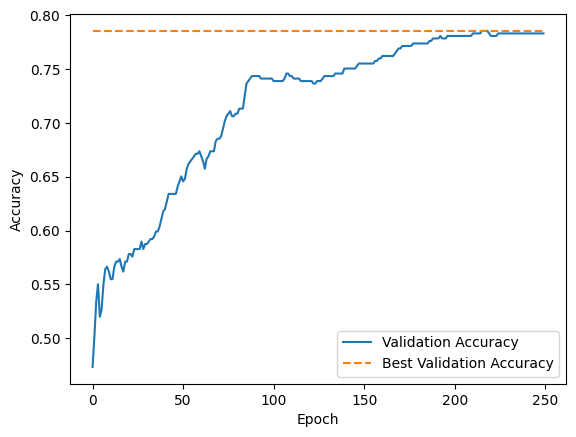

Accuracy (wide): 0.79
Epoch: 0, loss: 1.26497
Epoch: 10, loss: 0.56648
Epoch: 20, loss: 0.54603
Epoch: 30, loss: 0.51301
Epoch: 40, loss: 0.49080
Epoch: 50, loss: 0.47511
Epoch: 60, loss: 0.46414
Epoch: 70, loss: 0.45593
Epoch: 80, loss: 0.44929
Epoch: 90, loss: 0.44329
Epoch: 100, loss: 0.43789
Epoch: 110, loss: 0.43271
Epoch: 120, loss: 0.42817
Epoch: 130, loss: 0.42377
Epoch: 140, loss: 0.41944
Epoch: 150, loss: 0.41450
Epoch: 160, loss: 0.40977
Epoch: 170, loss: 0.40519
Epoch: 180, loss: 0.40061
Epoch: 190, loss: 0.39598
Epoch: 200, loss: 0.39169
Epoch: 210, loss: 0.38758
Epoch: 220, loss: 0.38366
Epoch: 230, loss: 0.37938
Epoch: 240, loss: 0.37591
Epoch: 249, loss: 0.37293


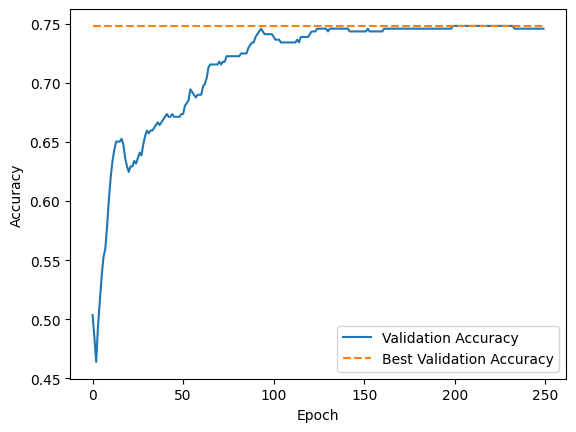

Accuracy (wide): 0.75
Epoch: 0, loss: 5.68383
Epoch: 10, loss: 1.60149
Epoch: 20, loss: 0.76311
Epoch: 30, loss: 0.63762
Epoch: 40, loss: 0.62241
Epoch: 50, loss: 0.61030
Epoch: 60, loss: 0.59854
Epoch: 70, loss: 0.58653
Epoch: 80, loss: 0.57548
Epoch: 90, loss: 0.56626
Epoch: 100, loss: 0.55870
Epoch: 110, loss: 0.55215
Epoch: 120, loss: 0.54670
Epoch: 130, loss: 0.54145
Epoch: 140, loss: 0.53686
Epoch: 150, loss: 0.53202
Epoch: 160, loss: 0.52596
Epoch: 170, loss: 0.51990
Epoch: 180, loss: 0.51412
Epoch: 190, loss: 0.50851
Epoch: 200, loss: 0.50293
Epoch: 210, loss: 0.49718
Epoch: 220, loss: 0.49184
Epoch: 230, loss: 0.48715
Epoch: 240, loss: 0.48254
Epoch: 249, loss: 0.47869


Accuracy (wide): 0.77
Epoch: 0, loss: 11.30699
Epoch: 10, loss: 1.70645
Epoch: 20, loss: 0.67029
Epoch: 30, loss: 0.42154
Epoch: 40, loss: 0.38184
Epoch: 50, loss: 0.35910
Epoch: 60, loss: 0.34508
Epoch: 70, loss: 0.33467
Epoch: 80, loss: 0.32641
Epoch: 90, loss: 0.32048
Epoch: 100, loss: 0.31704
Epoch: 110, loss: 0.31614
Epoch: 120, loss: 0.31581
Epoch: 130, loss: 0.31597
Epoch: 140, loss: 0.31620
Epoch: 150, loss: 0.31655
Epoch: 160, loss: 0.31711
Epoch: 170, loss: 0.31729
Epoch: 180, loss: 0.31729
Epoch: 190, loss: 0.31718
Epoch: 200, loss: 0.31699
Epoch: 210, loss: 0.31634
Epoch: 220, loss: 0.31578
Epoch: 230, loss: 0.31516
Epoch: 240, loss: 0.31434
Epoch: 249, loss: 0.31355


Accuracy (wide): 0.78
Epoch: 0, loss: 1.71056
Epoch: 10, loss: 0.57679
Epoch: 20, loss: 0.51307
Epoch: 30, loss: 0.48407
Epoch: 40, loss: 0.46614
Epoch: 50, loss: 0.45315
Epoch: 60, loss: 0.44363
Epoch: 70, loss: 0.43621
Epoch: 80, loss: 0.42995
Epoch: 90, loss: 0.42117
Epoch: 100, loss: 0.41625
Epoch: 110, loss: 0.41118
Epoch: 120, loss: 0.40955
Epoch: 130, loss: 0.40834
Epoch: 140, loss: 0.40619
Epoch: 150, loss: 0.40324
Epoch: 160, loss: 0.40062
Epoch: 170, loss: 0.39935
Epoch: 180, loss: 0.39745
Epoch: 190, loss: 0.39587
Epoch: 200, loss: 0.39379
Epoch: 210, loss: 0.39109
Epoch: 220, loss: 0.38863
Epoch: 230, loss: 0.38609
Epoch: 240, loss: 0.38292
Epoch: 249, loss: 0.38113


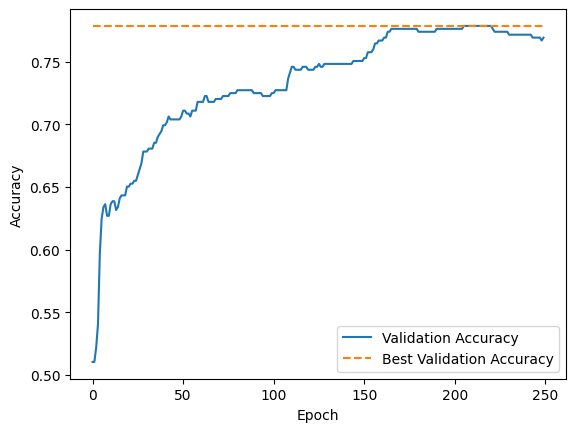

Accuracy (deep1): 0.78
Epoch: 0, loss: 0.79172
Epoch: 10, loss: 0.53691
Epoch: 20, loss: 0.51223
Epoch: 30, loss: 0.50358
Epoch: 40, loss: 0.49693
Epoch: 50, loss: 0.49081
Epoch: 60, loss: 0.48562
Epoch: 70, loss: 0.48023
Epoch: 80, loss: 0.47527
Epoch: 90, loss: 0.47102
Epoch: 100, loss: 0.46673
Epoch: 110, loss: 0.46223
Epoch: 120, loss: 0.45783
Epoch: 130, loss: 0.45397
Epoch: 140, loss: 0.45041
Epoch: 150, loss: 0.44668
Epoch: 160, loss: 0.44307
Epoch: 170, loss: 0.43958
Epoch: 180, loss: 0.43602
Epoch: 190, loss: 0.43209
Epoch: 200, loss: 0.42757
Epoch: 210, loss: 0.42282
Epoch: 220, loss: 0.41981
Epoch: 230, loss: 0.41707
Epoch: 240, loss: 0.41488
Epoch: 249, loss: 0.41263


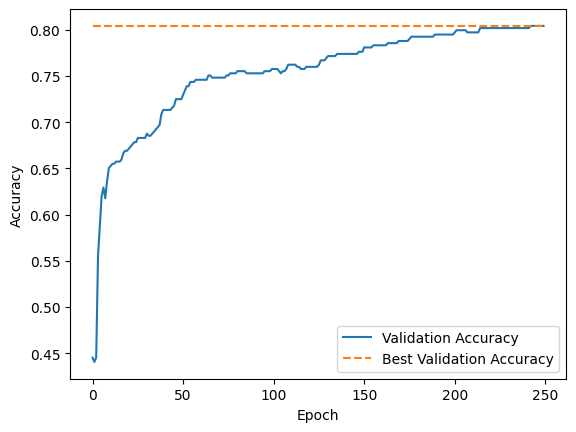

Accuracy (deep1): 0.80
Epoch: 0, loss: 1.31498
Epoch: 10, loss: 0.58077
Epoch: 20, loss: 0.54260
Epoch: 30, loss: 0.52764
Epoch: 40, loss: 0.51869
Epoch: 50, loss: 0.51430
Epoch: 60, loss: 0.50968
Epoch: 70, loss: 0.50462
Epoch: 80, loss: 0.50177
Epoch: 90, loss: 0.49898
Epoch: 100, loss: 0.49656
Epoch: 110, loss: 0.49399
Epoch: 120, loss: 0.49183
Epoch: 130, loss: 0.49046
Epoch: 140, loss: 0.48915
Epoch: 150, loss: 0.48733
Epoch: 160, loss: 0.48596
Epoch: 170, loss: 0.48436
Epoch: 180, loss: 0.48288
Epoch: 190, loss: 0.48034
Epoch: 200, loss: 0.47681
Epoch: 210, loss: 0.47423
Epoch: 220, loss: 0.47245
Epoch: 230, loss: 0.47128
Epoch: 240, loss: 0.46906
Epoch: 249, loss: 0.46715


Accuracy (deep1): 0.75
Epoch: 0, loss: 0.77604
Epoch: 10, loss: 0.61757
Epoch: 20, loss: 0.58987
Epoch: 30, loss: 0.57570
Epoch: 40, loss: 0.56486
Epoch: 50, loss: 0.55470
Epoch: 60, loss: 0.54764
Epoch: 70, loss: 0.54045
Epoch: 80, loss: 0.53326
Epoch: 90, loss: 0.52632
Epoch: 100, loss: 0.51814
Epoch: 110, loss: 0.51081
Epoch: 120, loss: 0.50310
Epoch: 130, loss: 0.49539
Epoch: 140, loss: 0.48956
Epoch: 150, loss: 0.48329
Epoch: 160, loss: 0.47789
Epoch: 170, loss: 0.47271
Epoch: 180, loss: 0.46751
Epoch: 190, loss: 0.46220
Epoch: 200, loss: 0.45635
Epoch: 210, loss: 0.44880
Epoch: 220, loss: 0.44276
Epoch: 230, loss: 0.43680
Epoch: 240, loss: 0.43140
Epoch: 249, loss: 0.42731


Accuracy (deep1): 0.79
Epoch: 0, loss: 0.81080
Epoch: 10, loss: 0.55227
Epoch: 20, loss: 0.52445
Epoch: 30, loss: 0.50820
Epoch: 40, loss: 0.49746
Epoch: 50, loss: 0.48523
Epoch: 60, loss: 0.47873
Epoch: 70, loss: 0.47221
Epoch: 80, loss: 0.46867
Epoch: 90, loss: 0.46512
Epoch: 100, loss: 0.46120
Epoch: 110, loss: 0.45746
Epoch: 120, loss: 0.45367
Epoch: 130, loss: 0.45077
Epoch: 140, loss: 0.44750
Epoch: 150, loss: 0.44419
Epoch: 160, loss: 0.44104
Epoch: 170, loss: 0.43807
Epoch: 180, loss: 0.43489
Epoch: 190, loss: 0.43231
Epoch: 200, loss: 0.42903
Epoch: 210, loss: 0.42605
Epoch: 220, loss: 0.42528
Epoch: 230, loss: 0.42133
Epoch: 240, loss: 0.41756
Epoch: 249, loss: 0.41551


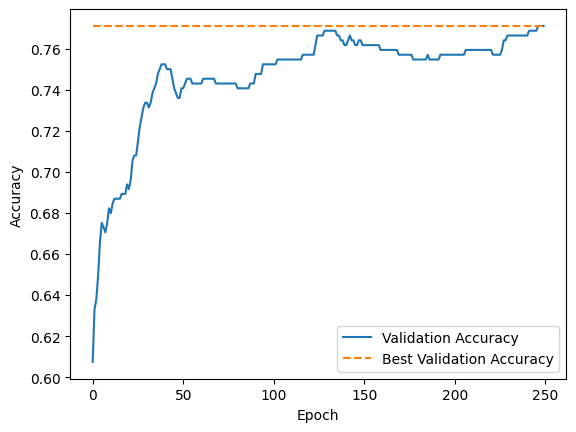

Accuracy (deep1): 0.77
Epoch: 0, loss: 0.65856
Epoch: 10, loss: 0.56005
Epoch: 20, loss: 0.53864
Epoch: 30, loss: 0.52103
Epoch: 40, loss: 0.50911
Epoch: 50, loss: 0.50061
Epoch: 60, loss: 0.49256
Epoch: 70, loss: 0.48487
Epoch: 80, loss: 0.47865
Epoch: 90, loss: 0.47187
Epoch: 100, loss: 0.46481
Epoch: 110, loss: 0.45816
Epoch: 120, loss: 0.45186
Epoch: 130, loss: 0.44616
Epoch: 140, loss: 0.44153
Epoch: 150, loss: 0.43723
Epoch: 160, loss: 0.43294
Epoch: 170, loss: 0.42946
Epoch: 180, loss: 0.42602
Epoch: 190, loss: 0.42250
Epoch: 200, loss: 0.41904
Epoch: 210, loss: 0.41547
Epoch: 220, loss: 0.41215
Epoch: 230, loss: 0.40950
Epoch: 240, loss: 0.40688
Epoch: 249, loss: 0.40476


Accuracy (deep): 0.78
Epoch: 0, loss: 0.99613
Epoch: 10, loss: 0.40167
Epoch: 20, loss: 0.34057
Epoch: 30, loss: 0.31335
Epoch: 40, loss: 0.29980
Epoch: 50, loss: 0.29327
Epoch: 60, loss: 0.28274
Epoch: 70, loss: 0.27702
Epoch: 80, loss: 0.27277
Epoch: 90, loss: 0.26855
Epoch: 100, loss: 0.26169
Epoch: 110, loss: 0.25615
Epoch: 120, loss: 0.25447
Epoch: 130, loss: 0.25118
Epoch: 140, loss: 0.24886
Epoch: 150, loss: 0.24623
Epoch: 160, loss: 0.24430
Epoch: 170, loss: 0.24248
Epoch: 180, loss: 0.24106
Epoch: 190, loss: 0.23954
Epoch: 200, loss: 0.23717
Epoch: 210, loss: 0.23293
Epoch: 220, loss: 0.23089
Epoch: 230, loss: 0.23002
Epoch: 240, loss: 0.22961
Epoch: 249, loss: 0.22910


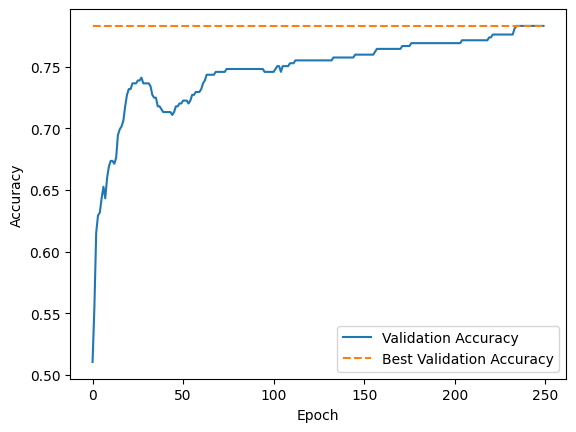

Accuracy (deep): 0.78
Epoch: 0, loss: 0.93566
Epoch: 10, loss: 0.54843
Epoch: 20, loss: 0.51686
Epoch: 30, loss: 0.49290
Epoch: 40, loss: 0.46812
Epoch: 50, loss: 0.45446
Epoch: 60, loss: 0.44338
Epoch: 70, loss: 0.43362
Epoch: 80, loss: 0.42523
Epoch: 90, loss: 0.41819
Epoch: 100, loss: 0.41148
Epoch: 110, loss: 0.40604
Epoch: 120, loss: 0.40132
Epoch: 130, loss: 0.39730
Epoch: 140, loss: 0.39359
Epoch: 150, loss: 0.38972
Epoch: 160, loss: 0.38620
Epoch: 170, loss: 0.38291
Epoch: 180, loss: 0.37927
Epoch: 190, loss: 0.37556
Epoch: 200, loss: 0.37249
Epoch: 210, loss: 0.36939
Epoch: 220, loss: 0.36646
Epoch: 230, loss: 0.36410
Epoch: 240, loss: 0.36184
Epoch: 249, loss: 0.36003


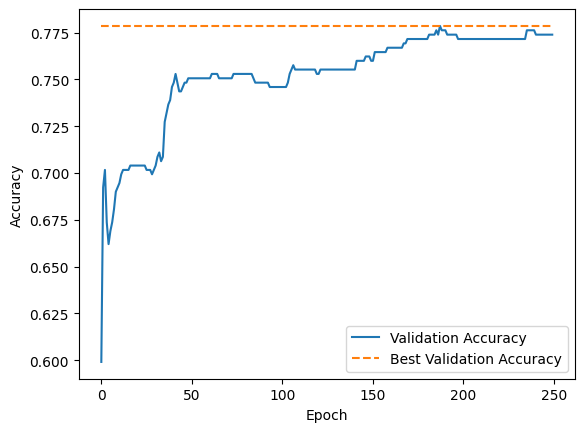

Accuracy (deep): 0.78
Epoch: 0, loss: 1.33993
Epoch: 10, loss: 0.57528
Epoch: 20, loss: 0.56719
Epoch: 30, loss: 0.56759
Epoch: 40, loss: 0.56860
Epoch: 50, loss: 0.56917
Epoch: 60, loss: 0.57001
Epoch: 70, loss: 0.56888
Epoch: 80, loss: 0.56778
Epoch: 90, loss: 0.56485
Epoch: 100, loss: 0.56092
Epoch: 110, loss: 0.55588
Epoch: 120, loss: 0.55062
Epoch: 130, loss: 0.54580
Epoch: 140, loss: 0.54155
Epoch: 150, loss: 0.53759
Epoch: 160, loss: 0.53181
Epoch: 170, loss: 0.52746
Epoch: 180, loss: 0.52274
Epoch: 190, loss: 0.51761
Epoch: 200, loss: 0.51228
Epoch: 210, loss: 0.50685
Epoch: 220, loss: 0.50155
Epoch: 230, loss: 0.49630
Epoch: 240, loss: 0.49126
Epoch: 249, loss: 0.48707


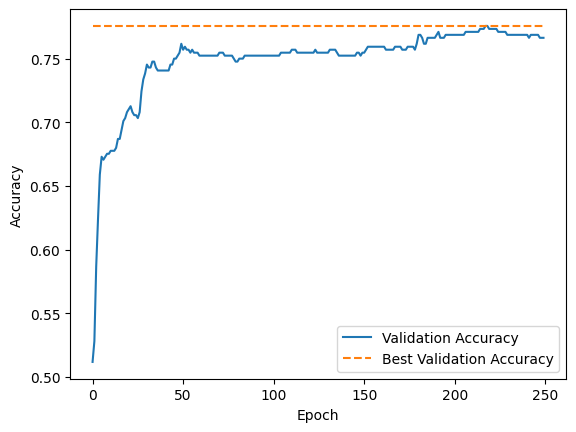

Accuracy (deep): 0.78
Epoch: 0, loss: 1.75128
Epoch: 10, loss: 0.57171
Epoch: 20, loss: 0.50433
Epoch: 30, loss: 0.47826
Epoch: 40, loss: 0.46562
Epoch: 50, loss: 0.45807
Epoch: 60, loss: 0.44817
Epoch: 70, loss: 0.44350
Epoch: 80, loss: 0.43789
Epoch: 90, loss: 0.43178
Epoch: 100, loss: 0.42668
Epoch: 110, loss: 0.42090
Epoch: 120, loss: 0.41665
Epoch: 130, loss: 0.41179
Epoch: 140, loss: 0.40708
Epoch: 150, loss: 0.40141
Epoch: 160, loss: 0.39649
Epoch: 170, loss: 0.39207
Epoch: 180, loss: 0.38835
Epoch: 190, loss: 0.38449
Epoch: 200, loss: 0.38132
Epoch: 210, loss: 0.37833
Epoch: 220, loss: 0.37518
Epoch: 230, loss: 0.37164
Epoch: 240, loss: 0.36874
Epoch: 249, loss: 0.36613


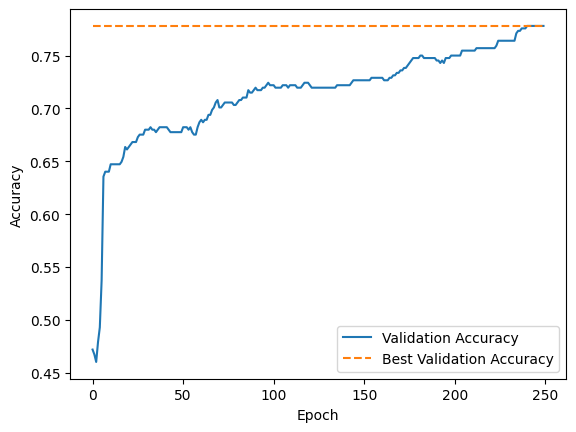

Accuracy (deep): 0.78
Epoch: 0, loss: 2.38929
Epoch: 10, loss: 1.52361
Epoch: 20, loss: 1.25933
Epoch: 30, loss: 1.16462
Epoch: 40, loss: 1.12676
Epoch: 50, loss: 1.09689
Epoch: 60, loss: 1.07208
Epoch: 70, loss: 1.05138
Epoch: 80, loss: 1.03365
Epoch: 90, loss: 1.01809
Epoch: 100, loss: 1.00413
Epoch: 110, loss: 0.99142
Epoch: 120, loss: 0.97973
Epoch: 130, loss: 0.96891
Epoch: 140, loss: 0.95888
Epoch: 150, loss: 0.94957
Epoch: 160, loss: 0.94095
Epoch: 170, loss: 0.93296
Epoch: 180, loss: 0.92554
Epoch: 190, loss: 0.91860
Epoch: 200, loss: 0.91209
Epoch: 210, loss: 0.90593
Epoch: 220, loss: 0.90007
Epoch: 230, loss: 0.89443
Epoch: 240, loss: 0.88901
Epoch: 249, loss: 0.88427


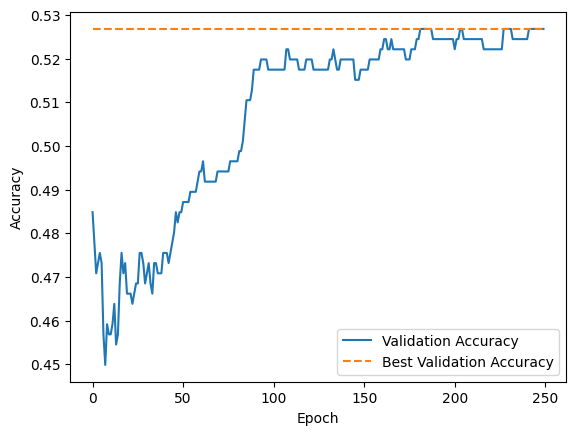

Accuracy (pbm): 0.53
Epoch: 0, loss: 2.53475
Epoch: 10, loss: 1.60984
Epoch: 20, loss: 1.30739
Epoch: 30, loss: 1.19397
Epoch: 40, loss: 1.14503
Epoch: 50, loss: 1.10671
Epoch: 60, loss: 1.07625
Epoch: 70, loss: 1.05158
Epoch: 80, loss: 1.03103
Epoch: 90, loss: 1.01343
Epoch: 100, loss: 0.99793
Epoch: 110, loss: 0.98394
Epoch: 120, loss: 0.97106
Epoch: 130, loss: 0.95899
Epoch: 140, loss: 0.94754
Epoch: 150, loss: 0.93658
Epoch: 160, loss: 0.92605
Epoch: 170, loss: 0.91589
Epoch: 180, loss: 0.90611
Epoch: 190, loss: 0.89672
Epoch: 200, loss: 0.88776
Epoch: 210, loss: 0.87923
Epoch: 220, loss: 0.87117
Epoch: 230, loss: 0.86357
Epoch: 240, loss: 0.85640
Epoch: 249, loss: 0.85029


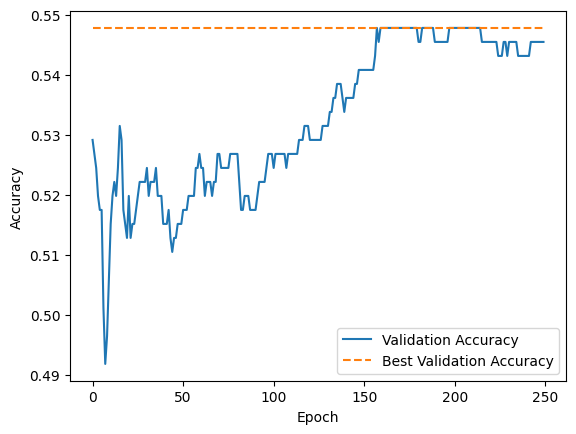

Accuracy (pbm): 0.55
Epoch: 0, loss: 2.39555
Epoch: 10, loss: 1.54476
Epoch: 20, loss: 1.28609
Epoch: 30, loss: 1.19244
Epoch: 40, loss: 1.15430
Epoch: 50, loss: 1.12484
Epoch: 60, loss: 1.10124
Epoch: 70, loss: 1.08206
Epoch: 80, loss: 1.06590
Epoch: 90, loss: 1.05180
Epoch: 100, loss: 1.03909
Epoch: 110, loss: 1.02734
Epoch: 120, loss: 1.01625
Epoch: 130, loss: 1.00564
Epoch: 140, loss: 0.99538
Epoch: 150, loss: 0.98535
Epoch: 160, loss: 0.97549
Epoch: 170, loss: 0.96575
Epoch: 180, loss: 0.95606
Epoch: 190, loss: 0.94639
Epoch: 200, loss: 0.93672
Epoch: 210, loss: 0.92703
Epoch: 220, loss: 0.91737
Epoch: 230, loss: 0.90779
Epoch: 240, loss: 0.89838
Epoch: 249, loss: 0.89015


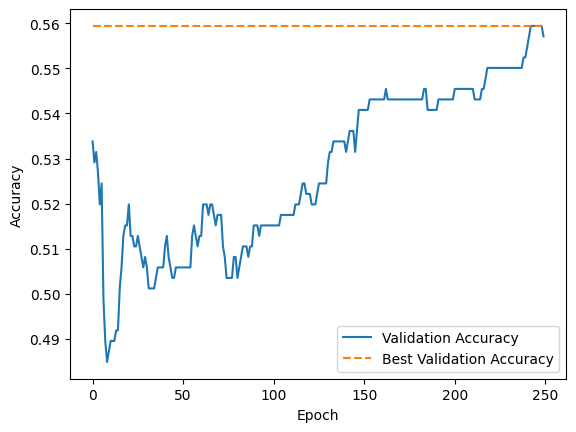

Accuracy (pbm): 0.56
Epoch: 0, loss: 2.23905
Epoch: 10, loss: 1.42881
Epoch: 20, loss: 1.17778
Epoch: 30, loss: 1.08889
Epoch: 40, loss: 1.05415
Epoch: 50, loss: 1.02848
Epoch: 60, loss: 1.00831
Epoch: 70, loss: 0.99196
Epoch: 80, loss: 0.97810
Epoch: 90, loss: 0.96584
Epoch: 100, loss: 0.95461
Epoch: 110, loss: 0.94405
Epoch: 120, loss: 0.93392
Epoch: 130, loss: 0.92407
Epoch: 140, loss: 0.91440
Epoch: 150, loss: 0.90487
Epoch: 160, loss: 0.89545
Epoch: 170, loss: 0.88618
Epoch: 180, loss: 0.87709
Epoch: 190, loss: 0.86826
Epoch: 200, loss: 0.85978
Epoch: 210, loss: 0.85173
Epoch: 220, loss: 0.84415
Epoch: 230, loss: 0.83708
Epoch: 240, loss: 0.83050
Epoch: 249, loss: 0.82496


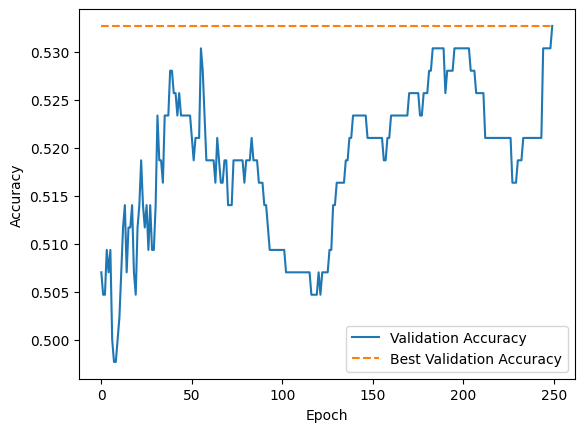

Accuracy (pbm): 0.53
Epoch: 0, loss: 1.79849
Epoch: 10, loss: 1.20827
Epoch: 20, loss: 1.00837
Epoch: 30, loss: 0.91738
Epoch: 40, loss: 0.87031
Epoch: 50, loss: 0.83730
Epoch: 60, loss: 0.81377
Epoch: 70, loss: 0.79669
Epoch: 80, loss: 0.78394
Epoch: 90, loss: 0.77414
Epoch: 100, loss: 0.76639
Epoch: 110, loss: 0.76012
Epoch: 120, loss: 0.75496
Epoch: 130, loss: 0.75069
Epoch: 140, loss: 0.74717
Epoch: 150, loss: 0.74431
Epoch: 160, loss: 0.74207
Epoch: 170, loss: 0.74040
Epoch: 180, loss: 0.73925
Epoch: 190, loss: 0.73856
Epoch: 200, loss: 0.73822
Epoch: 210, loss: 0.73814
Epoch: 220, loss: 0.73823
Epoch: 230, loss: 0.73840
Epoch: 240, loss: 0.73858
Epoch: 249, loss: 0.73871


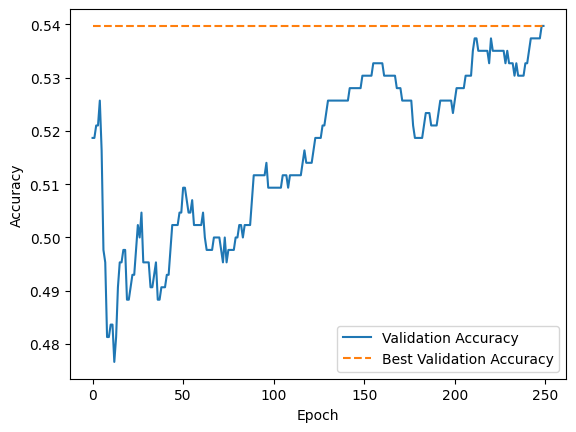

Accuracy (pbm): 0.54


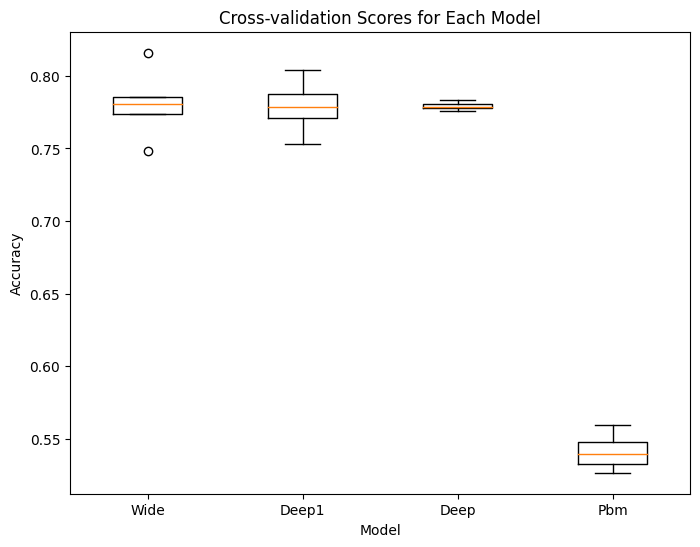

Wide: 78.07% (+/- 2.18%)
Deep1: 77.88% (+/- 1.70%)
Deep: 77.93% (+/- 0.26%)
Pbm: 54.13% (+/- 1.15%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




40%: Wide: 78.25% (+/- 1.45%)
Deep1: 77.32% (+/- 1.93%)
Deep: 78.11% (+/- 1.96%)
Pbm: 55.20% (+/- 2.01%)

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_60.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

           DV1       DV2       DV3          V         G1         G2  \
0     1.384000  0.082000 -7.928100  14.018000  49.628600  10.665400   
1     1.264000  0.112000 -7.910000  14.006000  49.505600  10.650400   
2     1.219000  0.106000 -7.916000  14.012000  49.387600  10.638400   
3     1.219000  0.085000 -7.919000  14.015000  49.266600  10.627400   
4     1.225000  0.030000 -7.919000  14.015000  49.144600  10.616400   
...        ...       ...       ...        ...        ...        ...   
4075 -0.871728  9.448800  5.599176   5.455920  10.931957  33.089393   
4076 -0.969264  9.217152  5.660136   5.620512  11.023397  32.158534   
4077 -1.054608  9.058656  5.562600   5.815584  11.126419  31.256630   
4078 -1.103376  9.015984  4.687824   5.980176  11.239805  30.364786   
4079 -1.109472  9.079992  4.593336   6.074664  11.353800  29.467454   

              G3        Dend     Carid  label_targetlane  
0     202.021600  145.774800 -1.550351                 1  
1     201.231600  147.174800 

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([4080, 9])
torch.Size([4080, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(-1.6996, requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(0.2498, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(-0.2024, requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0.0178, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(-0.0122, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.0044, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.0311, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(0.0024, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 2.22412
Epoch: 10, loss: 0.77671
Epoch: 20, loss: 0.74080
Epoch: 30, loss: 0.68813
Epoch: 40, loss: 0.64609
Epoch: 50, loss: 0.61156
Epoch: 60, loss: 0.58379
Epoch: 70, loss: 0.56117
Epoch: 80, loss: 0.54278
Epoch: 90, loss: 0.52617
Epoch: 100, loss: 0.51021
Epoch: 110, loss: 0.49617
Epoch: 120, loss: 0.48490
Epoch: 130, loss: 0.47545
Epoch: 140, loss: 0.46711
Epoch: 150, loss: 0.45986
Epoch: 160, loss: 0.45479
Epoch: 170, loss: 0.44998
Epoch: 180, loss: 0.44557
Epoch: 190, loss: 0.44129
Epoch: 200, loss: 0.43751
Epoch: 210, loss: 0.43385
Epoch: 220, loss: 0.43006
Epoch: 230, loss: 0.42620
Epoch: 240, loss: 0.42238
Epoch: 249, loss: 0.41902


Accuracy (wide): 0.75
Epoch: 0, loss: 2.65080
Epoch: 10, loss: 0.56941
Epoch: 20, loss: 0.51759
Epoch: 30, loss: 0.46873
Epoch: 40, loss: 0.43429
Epoch: 50, loss: 0.41350
Epoch: 60, loss: 0.40057
Epoch: 70, loss: 0.39202
Epoch: 80, loss: 0.38604
Epoch: 90, loss: 0.38222
Epoch: 100, loss: 0.37922
Epoch: 110, loss: 0.37674
Epoch: 120, loss: 0.37426
Epoch: 130, loss: 0.37144
Epoch: 140, loss: 0.36893
Epoch: 150, loss: 0.36668
Epoch: 160, loss: 0.36401
Epoch: 170, loss: 0.36129
Epoch: 180, loss: 0.35901
Epoch: 190, loss: 0.35682
Epoch: 200, loss: 0.35466
Epoch: 210, loss: 0.35265
Epoch: 220, loss: 0.35075
Epoch: 230, loss: 0.34876
Epoch: 240, loss: 0.34656
Epoch: 249, loss: 0.34460


Accuracy (wide): 0.77
Epoch: 0, loss: 6.36009
Epoch: 10, loss: 0.78017
Epoch: 20, loss: 0.70271
Epoch: 30, loss: 0.65078
Epoch: 40, loss: 0.61110
Epoch: 50, loss: 0.57826
Epoch: 60, loss: 0.55146
Epoch: 70, loss: 0.52720
Epoch: 80, loss: 0.50540
Epoch: 90, loss: 0.48472
Epoch: 100, loss: 0.46599
Epoch: 110, loss: 0.44998
Epoch: 120, loss: 0.43586
Epoch: 130, loss: 0.42323
Epoch: 140, loss: 0.41164
Epoch: 150, loss: 0.40131
Epoch: 160, loss: 0.39207
Epoch: 170, loss: 0.38360
Epoch: 180, loss: 0.37594
Epoch: 190, loss: 0.36944
Epoch: 200, loss: 0.36345
Epoch: 210, loss: 0.35905
Epoch: 220, loss: 0.35472
Epoch: 230, loss: 0.35079
Epoch: 240, loss: 0.34724
Epoch: 249, loss: 0.34393


Accuracy (wide): 0.75
Epoch: 0, loss: 3.60317
Epoch: 10, loss: 0.54952
Epoch: 20, loss: 0.55008
Epoch: 30, loss: 0.55080
Epoch: 40, loss: 0.55110
Epoch: 50, loss: 0.54743
Epoch: 60, loss: 0.54318
Epoch: 70, loss: 0.54079
Epoch: 80, loss: 0.53852
Epoch: 90, loss: 0.53443
Epoch: 100, loss: 0.52990
Epoch: 110, loss: 0.52396
Epoch: 120, loss: 0.51774
Epoch: 130, loss: 0.51163
Epoch: 140, loss: 0.50625
Epoch: 150, loss: 0.50125
Epoch: 160, loss: 0.49690
Epoch: 170, loss: 0.49315
Epoch: 180, loss: 0.49028
Epoch: 190, loss: 0.48820
Epoch: 200, loss: 0.48610
Epoch: 210, loss: 0.48345
Epoch: 220, loss: 0.48061
Epoch: 230, loss: 0.47744
Epoch: 240, loss: 0.47335
Epoch: 249, loss: 0.46974


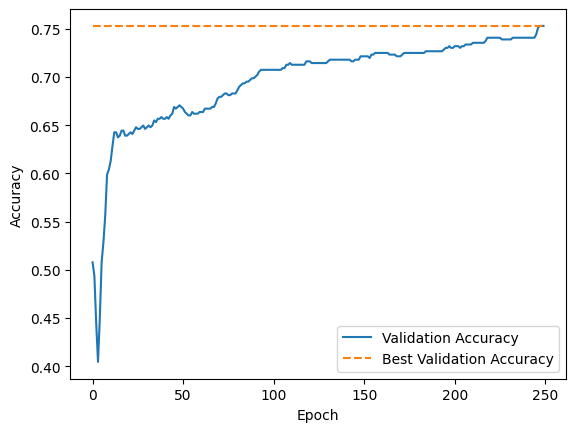

Accuracy (wide): 0.75
Epoch: 0, loss: 32.45345
Epoch: 10, loss: 0.52909
Epoch: 20, loss: 0.52269
Epoch: 30, loss: 0.48163
Epoch: 40, loss: 0.44850
Epoch: 50, loss: 0.42418
Epoch: 60, loss: 0.40312
Epoch: 70, loss: 0.38615
Epoch: 80, loss: 0.37391
Epoch: 90, loss: 0.36444
Epoch: 100, loss: 0.35633
Epoch: 110, loss: 0.34911
Epoch: 120, loss: 0.34232
Epoch: 130, loss: 0.33562
Epoch: 140, loss: 0.32931
Epoch: 150, loss: 0.32381
Epoch: 160, loss: 0.31971
Epoch: 170, loss: 0.31601
Epoch: 180, loss: 0.31216
Epoch: 190, loss: 0.30793
Epoch: 200, loss: 0.30342
Epoch: 210, loss: 0.29962
Epoch: 220, loss: 0.29570
Epoch: 230, loss: 0.29197
Epoch: 240, loss: 0.28861
Epoch: 249, loss: 0.28607


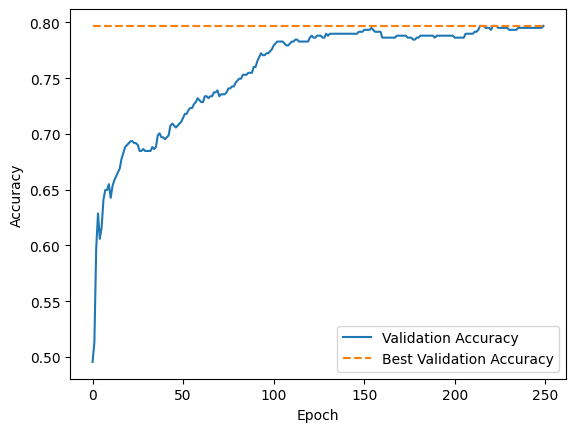

Accuracy (wide): 0.80
Epoch: 0, loss: 0.73707
Epoch: 10, loss: 0.66920
Epoch: 20, loss: 0.65845
Epoch: 30, loss: 0.64741
Epoch: 40, loss: 0.63672
Epoch: 50, loss: 0.62337
Epoch: 60, loss: 0.60755
Epoch: 70, loss: 0.59195
Epoch: 80, loss: 0.57829
Epoch: 90, loss: 0.56473
Epoch: 100, loss: 0.55191
Epoch: 110, loss: 0.53939
Epoch: 120, loss: 0.52914
Epoch: 130, loss: 0.51445
Epoch: 140, loss: 0.50041
Epoch: 150, loss: 0.48544
Epoch: 160, loss: 0.47145
Epoch: 170, loss: 0.45874
Epoch: 180, loss: 0.44616
Epoch: 190, loss: 0.43290
Epoch: 200, loss: 0.42143
Epoch: 210, loss: 0.41044
Epoch: 220, loss: 0.39975
Epoch: 230, loss: 0.38909
Epoch: 240, loss: 0.37857
Epoch: 249, loss: 0.36946


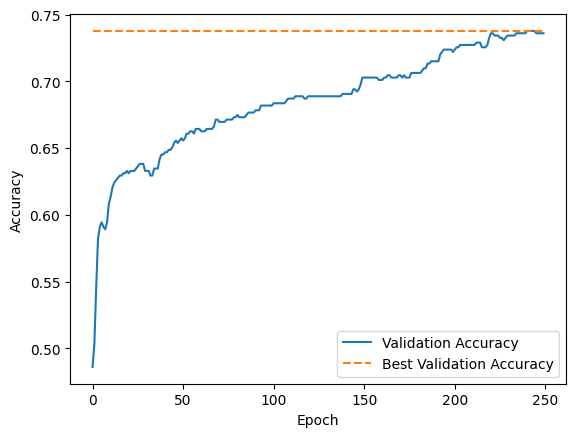

Accuracy (deep1): 0.74
Epoch: 0, loss: 0.59076
Epoch: 10, loss: 0.63614
Epoch: 20, loss: 0.63559
Epoch: 30, loss: 0.62818
Epoch: 40, loss: 0.62104
Epoch: 50, loss: 0.61290
Epoch: 60, loss: 0.60657
Epoch: 70, loss: 0.60124
Epoch: 80, loss: 0.59516
Epoch: 90, loss: 0.58900
Epoch: 100, loss: 0.58245
Epoch: 110, loss: 0.57612
Epoch: 120, loss: 0.56803
Epoch: 130, loss: 0.56600
Epoch: 140, loss: 0.56361
Epoch: 150, loss: 0.56121
Epoch: 160, loss: 0.55714
Epoch: 170, loss: 0.55325
Epoch: 180, loss: 0.54953
Epoch: 190, loss: 0.54569
Epoch: 200, loss: 0.54213
Epoch: 210, loss: 0.54057
Epoch: 220, loss: 0.53949
Epoch: 230, loss: 0.53765
Epoch: 240, loss: 0.53589
Epoch: 249, loss: 0.53454


Accuracy (deep1): 0.83
Epoch: 0, loss: 0.54553
Epoch: 10, loss: 0.62621
Epoch: 20, loss: 0.61126
Epoch: 30, loss: 0.59947
Epoch: 40, loss: 0.58645
Epoch: 50, loss: 0.57406
Epoch: 60, loss: 0.56109
Epoch: 70, loss: 0.54906
Epoch: 80, loss: 0.53829
Epoch: 90, loss: 0.52809
Epoch: 100, loss: 0.51867
Epoch: 110, loss: 0.50956
Epoch: 120, loss: 0.50085
Epoch: 130, loss: 0.49286
Epoch: 140, loss: 0.48378
Epoch: 150, loss: 0.47556
Epoch: 160, loss: 0.46806
Epoch: 170, loss: 0.46113
Epoch: 180, loss: 0.45505
Epoch: 190, loss: 0.44802
Epoch: 200, loss: 0.44183
Epoch: 210, loss: 0.43551
Epoch: 220, loss: 0.43045
Epoch: 230, loss: 0.42453
Epoch: 240, loss: 0.42000
Epoch: 249, loss: 0.41567


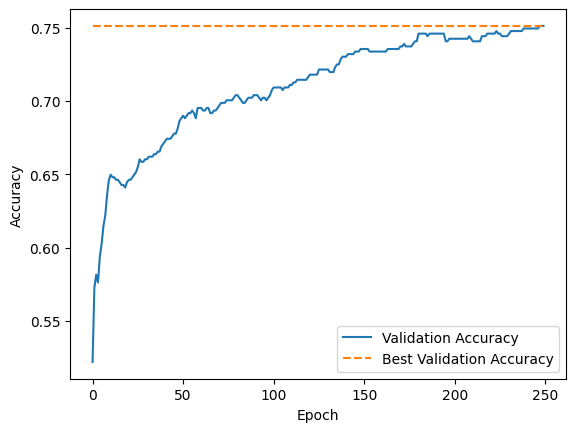

Accuracy (deep1): 0.75
Epoch: 0, loss: 1.66687
Epoch: 10, loss: 0.63922
Epoch: 20, loss: 0.63850
Epoch: 30, loss: 0.63190
Epoch: 40, loss: 0.62610
Epoch: 50, loss: 0.62211
Epoch: 60, loss: 0.59841
Epoch: 70, loss: 0.58781
Epoch: 80, loss: 0.57589
Epoch: 90, loss: 0.55867
Epoch: 100, loss: 0.54598
Epoch: 110, loss: 0.53488
Epoch: 120, loss: 0.52370
Epoch: 130, loss: 0.51131
Epoch: 140, loss: 0.50061
Epoch: 150, loss: 0.49044
Epoch: 160, loss: 0.48025
Epoch: 170, loss: 0.47055
Epoch: 180, loss: 0.45934
Epoch: 190, loss: 0.44840
Epoch: 200, loss: 0.43764
Epoch: 210, loss: 0.42716
Epoch: 220, loss: 0.41702
Epoch: 230, loss: 0.40803
Epoch: 240, loss: 0.39855
Epoch: 249, loss: 0.39074


Accuracy (deep1): 0.76
Epoch: 0, loss: 0.99449
Epoch: 10, loss: 0.73549
Epoch: 20, loss: 0.72454
Epoch: 30, loss: 0.71353
Epoch: 40, loss: 0.70669
Epoch: 50, loss: 0.70265
Epoch: 60, loss: 0.70081
Epoch: 70, loss: 0.69744
Epoch: 80, loss: 0.69155
Epoch: 90, loss: 0.68277
Epoch: 100, loss: 0.67145
Epoch: 110, loss: 0.65854
Epoch: 120, loss: 0.64321
Epoch: 130, loss: 0.62033
Epoch: 140, loss: 0.60201
Epoch: 150, loss: 0.58905
Epoch: 160, loss: 0.58048
Epoch: 170, loss: 0.56885
Epoch: 180, loss: 0.56086
Epoch: 190, loss: 0.55262
Epoch: 200, loss: 0.54444
Epoch: 210, loss: 0.53559
Epoch: 220, loss: 0.52469
Epoch: 230, loss: 0.51514
Epoch: 240, loss: 0.50526
Epoch: 249, loss: 0.49625


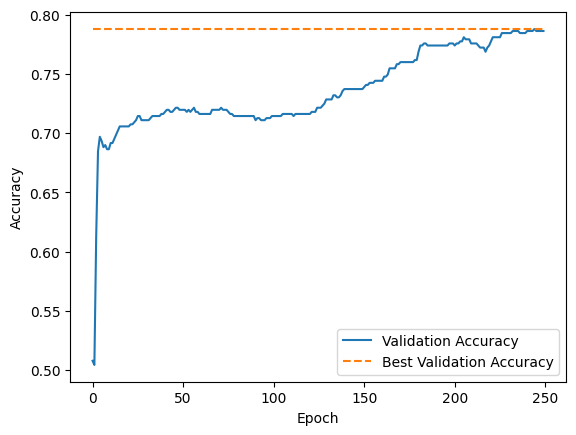

Accuracy (deep1): 0.79
Epoch: 0, loss: 0.61030
Epoch: 10, loss: 0.58568
Epoch: 20, loss: 0.57374
Epoch: 30, loss: 0.56822
Epoch: 40, loss: 0.55956
Epoch: 50, loss: 0.54874
Epoch: 60, loss: 0.54071
Epoch: 70, loss: 0.53354
Epoch: 80, loss: 0.52542
Epoch: 90, loss: 0.51606
Epoch: 100, loss: 0.50766
Epoch: 110, loss: 0.49917
Epoch: 120, loss: 0.49125
Epoch: 130, loss: 0.48061
Epoch: 140, loss: 0.47062
Epoch: 150, loss: 0.46079
Epoch: 160, loss: 0.45151
Epoch: 170, loss: 0.43903
Epoch: 180, loss: 0.42715
Epoch: 190, loss: 0.41595
Epoch: 200, loss: 0.40378
Epoch: 210, loss: 0.39378
Epoch: 220, loss: 0.38448
Epoch: 230, loss: 0.37686
Epoch: 240, loss: 0.36912
Epoch: 249, loss: 0.36240


Accuracy (deep): 0.81
Epoch: 0, loss: 1.20988
Epoch: 10, loss: 0.71556
Epoch: 20, loss: 0.69860
Epoch: 30, loss: 0.67935
Epoch: 40, loss: 0.66560
Epoch: 50, loss: 0.65428
Epoch: 60, loss: 0.64149
Epoch: 70, loss: 0.62446
Epoch: 80, loss: 0.60514
Epoch: 90, loss: 0.58575
Epoch: 100, loss: 0.56792
Epoch: 110, loss: 0.55113
Epoch: 120, loss: 0.53495
Epoch: 130, loss: 0.51974
Epoch: 140, loss: 0.50501
Epoch: 150, loss: 0.49037
Epoch: 160, loss: 0.47556
Epoch: 170, loss: 0.46217
Epoch: 180, loss: 0.44990
Epoch: 190, loss: 0.43716
Epoch: 200, loss: 0.42379
Epoch: 210, loss: 0.41262
Epoch: 220, loss: 0.40172
Epoch: 230, loss: 0.39212
Epoch: 240, loss: 0.38421
Epoch: 249, loss: 0.37849


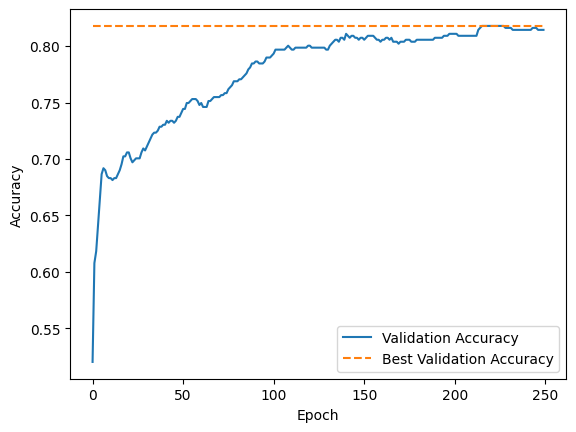

Accuracy (deep): 0.82
Epoch: 0, loss: 0.70689
Epoch: 10, loss: 0.64071
Epoch: 20, loss: 0.61379
Epoch: 30, loss: 0.59775
Epoch: 40, loss: 0.58740
Epoch: 50, loss: 0.57618
Epoch: 60, loss: 0.56164
Epoch: 70, loss: 0.54748
Epoch: 80, loss: 0.53324
Epoch: 90, loss: 0.52040
Epoch: 100, loss: 0.51002
Epoch: 110, loss: 0.50054
Epoch: 120, loss: 0.49569
Epoch: 130, loss: 0.48360
Epoch: 140, loss: 0.47374
Epoch: 150, loss: 0.46479
Epoch: 160, loss: 0.45802
Epoch: 170, loss: 0.45123
Epoch: 180, loss: 0.44338
Epoch: 190, loss: 0.43775
Epoch: 200, loss: 0.43156
Epoch: 210, loss: 0.42512
Epoch: 220, loss: 0.42137
Epoch: 230, loss: 0.41804
Epoch: 240, loss: 0.41503
Epoch: 249, loss: 0.41197


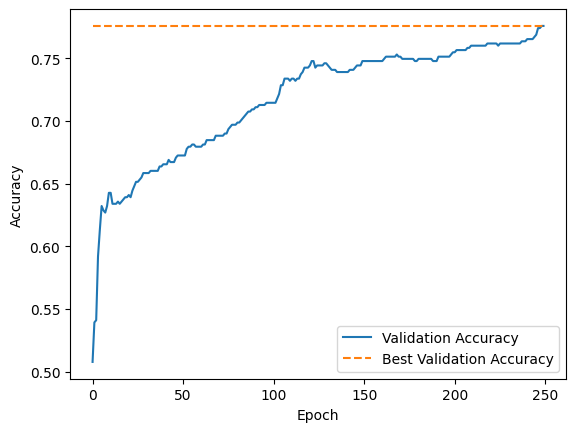

Accuracy (deep): 0.78
Epoch: 0, loss: 0.67253
Epoch: 10, loss: 0.61045
Epoch: 20, loss: 0.56742
Epoch: 30, loss: 0.55084
Epoch: 40, loss: 0.53847
Epoch: 50, loss: 0.52575
Epoch: 60, loss: 0.51652
Epoch: 70, loss: 0.50820
Epoch: 80, loss: 0.49919
Epoch: 90, loss: 0.48945
Epoch: 100, loss: 0.48049
Epoch: 110, loss: 0.47115
Epoch: 120, loss: 0.46183
Epoch: 130, loss: 0.45242
Epoch: 140, loss: 0.44330
Epoch: 150, loss: 0.43291
Epoch: 160, loss: 0.42182
Epoch: 170, loss: 0.41033
Epoch: 180, loss: 0.39822
Epoch: 190, loss: 0.38634
Epoch: 200, loss: 0.37511
Epoch: 210, loss: 0.36380
Epoch: 220, loss: 0.35265
Epoch: 230, loss: 0.34119
Epoch: 240, loss: 0.33012
Epoch: 249, loss: 0.32067


Accuracy (deep): 0.77
Epoch: 0, loss: 0.57837
Epoch: 10, loss: 0.54415
Epoch: 20, loss: 0.54331
Epoch: 30, loss: 0.54371
Epoch: 40, loss: 0.54349
Epoch: 50, loss: 0.53863
Epoch: 60, loss: 0.52860
Epoch: 70, loss: 0.51687
Epoch: 80, loss: 0.50603
Epoch: 90, loss: 0.49426
Epoch: 100, loss: 0.48180
Epoch: 110, loss: 0.46866
Epoch: 120, loss: 0.45393
Epoch: 130, loss: 0.43987
Epoch: 140, loss: 0.42584
Epoch: 150, loss: 0.41418
Epoch: 160, loss: 0.40020
Epoch: 170, loss: 0.38561
Epoch: 180, loss: 0.37348
Epoch: 190, loss: 0.36346
Epoch: 200, loss: 0.35565
Epoch: 210, loss: 0.34450
Epoch: 220, loss: 0.33435
Epoch: 230, loss: 0.32498
Epoch: 240, loss: 0.31666
Epoch: 249, loss: 0.30986


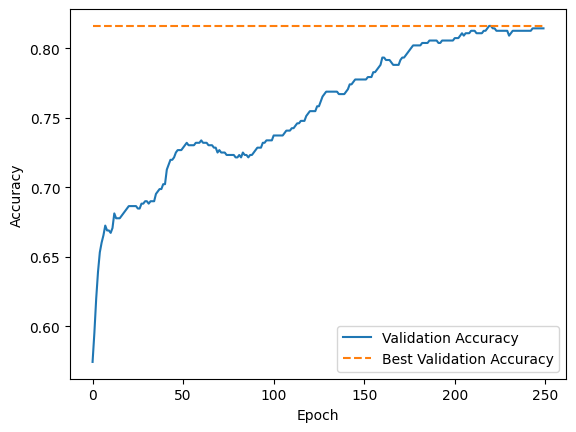

Accuracy (deep): 0.82
Epoch: 0, loss: 3.11811
Epoch: 10, loss: 2.78071
Epoch: 20, loss: 2.58612
Epoch: 30, loss: 2.07899
Epoch: 40, loss: 1.89550
Epoch: 50, loss: 1.83673
Epoch: 60, loss: 1.78023
Epoch: 70, loss: 1.71917
Epoch: 80, loss: 1.64569
Epoch: 90, loss: 1.56971
Epoch: 100, loss: 1.51253
Epoch: 110, loss: 1.45764
Epoch: 120, loss: 1.39788
Epoch: 130, loss: 1.33162
Epoch: 140, loss: 1.26285
Epoch: 150, loss: 1.20086
Epoch: 160, loss: 1.17422
Epoch: 170, loss: 1.15648
Epoch: 180, loss: 1.14864
Epoch: 190, loss: 1.13965
Epoch: 200, loss: 1.15150
Epoch: 210, loss: 1.14511
Epoch: 220, loss: 1.13785
Epoch: 230, loss: 1.12831
Epoch: 240, loss: 1.13982
Epoch: 249, loss: 1.13503


Accuracy (pbm): 0.64
Epoch: 0, loss: 3.08860
Epoch: 10, loss: 2.74430
Epoch: 20, loss: 2.52848
Epoch: 30, loss: 2.02436
Epoch: 40, loss: 1.87077
Epoch: 50, loss: 1.75622
Epoch: 60, loss: 1.67197
Epoch: 70, loss: 1.60734
Epoch: 80, loss: 1.54988
Epoch: 90, loss: 1.48991
Epoch: 100, loss: 1.42074
Epoch: 110, loss: 1.33956
Epoch: 120, loss: 1.24918
Epoch: 130, loss: 1.15613
Epoch: 140, loss: 1.06542
Epoch: 150, loss: 0.97708
Epoch: 160, loss: 0.89090
Epoch: 170, loss: 0.81308
Epoch: 180, loss: 0.75297
Epoch: 190, loss: 0.72010
Epoch: 200, loss: 0.71485
Epoch: 210, loss: 0.71505
Epoch: 220, loss: 0.71542
Epoch: 230, loss: 0.71495
Epoch: 240, loss: 0.71351
Epoch: 249, loss: 0.71131


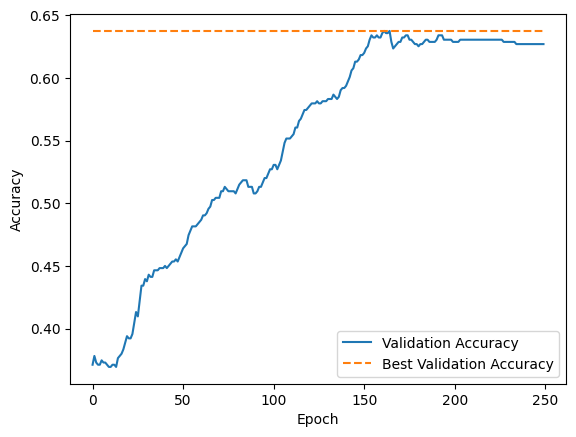

Accuracy (pbm): 0.64
Epoch: 0, loss: 1.27699
Epoch: 10, loss: 1.16606
Epoch: 20, loss: 1.11407
Epoch: 30, loss: 0.95413
Epoch: 40, loss: 0.87321
Epoch: 50, loss: 0.80363
Epoch: 60, loss: 0.75778
Epoch: 70, loss: 0.73153
Epoch: 80, loss: 0.72702
Epoch: 90, loss: 0.76132
Epoch: 100, loss: 0.77770
Epoch: 110, loss: 0.76682
Epoch: 120, loss: 0.76093
Epoch: 130, loss: 0.76089
Epoch: 140, loss: 0.76900
Epoch: 150, loss: 0.78707
Epoch: 160, loss: 0.83820
Epoch: 170, loss: 0.87481
Epoch: 180, loss: 0.90135
Epoch: 190, loss: 0.90998
Epoch: 200, loss: 0.93163
Epoch: 210, loss: 0.92407
Epoch: 220, loss: 0.91857
Epoch: 230, loss: 0.91106
Epoch: 240, loss: 0.92558
Epoch: 249, loss: 0.91996


Accuracy (pbm): 0.61
Epoch: 0, loss: 2.75840
Epoch: 10, loss: 2.51075
Epoch: 20, loss: 2.36131
Epoch: 30, loss: 1.91508
Epoch: 40, loss: 1.78565
Epoch: 50, loss: 1.66840
Epoch: 60, loss: 1.58650
Epoch: 70, loss: 1.53145
Epoch: 80, loss: 1.46679
Epoch: 90, loss: 1.41873
Epoch: 100, loss: 1.38244
Epoch: 110, loss: 1.34179
Epoch: 120, loss: 1.30047
Epoch: 130, loss: 1.25793
Epoch: 140, loss: 1.21673
Epoch: 150, loss: 1.18116
Epoch: 160, loss: 1.17022
Epoch: 170, loss: 1.17372
Epoch: 180, loss: 1.17725
Epoch: 190, loss: 1.17348
Epoch: 200, loss: 1.18825
Epoch: 210, loss: 1.17850
Epoch: 220, loss: 1.17041
Epoch: 230, loss: 1.16019
Epoch: 240, loss: 1.17309
Epoch: 249, loss: 1.16572


Accuracy (pbm): 0.62
Epoch: 0, loss: 3.14836
Epoch: 10, loss: 2.87329
Epoch: 20, loss: 2.73473
Epoch: 30, loss: 2.28448
Epoch: 40, loss: 2.07710
Epoch: 50, loss: 1.96279
Epoch: 60, loss: 1.87675
Epoch: 70, loss: 1.81068
Epoch: 80, loss: 1.75927
Epoch: 90, loss: 1.73517
Epoch: 100, loss: 1.70720
Epoch: 110, loss: 1.65083
Epoch: 120, loss: 1.59383
Epoch: 130, loss: 1.53271
Epoch: 140, loss: 1.46797
Epoch: 150, loss: 1.40474
Epoch: 160, loss: 1.34890
Epoch: 170, loss: 1.33957
Epoch: 180, loss: 1.32392
Epoch: 190, loss: 1.31139
Epoch: 200, loss: 1.29628
Epoch: 210, loss: 1.31148
Epoch: 220, loss: 1.30413
Epoch: 230, loss: 1.29514
Epoch: 240, loss: 1.28280
Epoch: 249, loss: 1.30135


Accuracy (pbm): 0.64


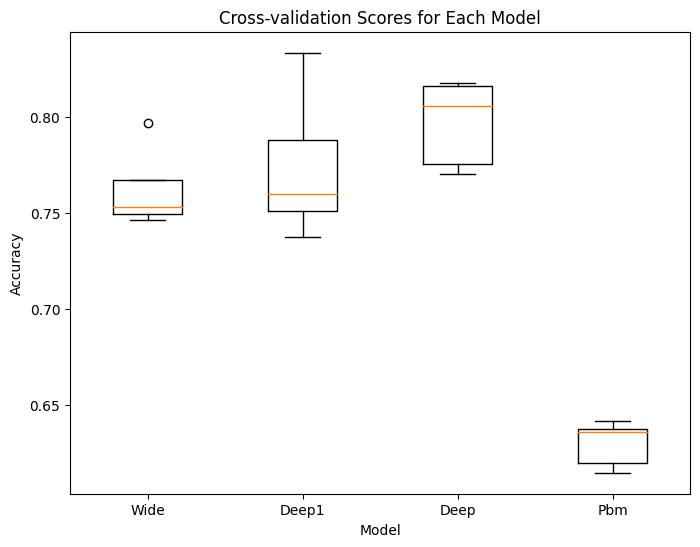

Wide: 76.26% (+/- 1.85%)
Deep1: 77.42% (+/- 3.40%)
Deep: 79.73% (+/- 2.01%)
Pbm: 62.99% (+/- 1.06%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




60%: Wide: 78.54% (+/- 2.79%)
Deep1: 79.13% (+/- 2.32%)
Deep: 79.41% (+/- 1.71%)
Pbm: 63.45% (+/- 1.87%)

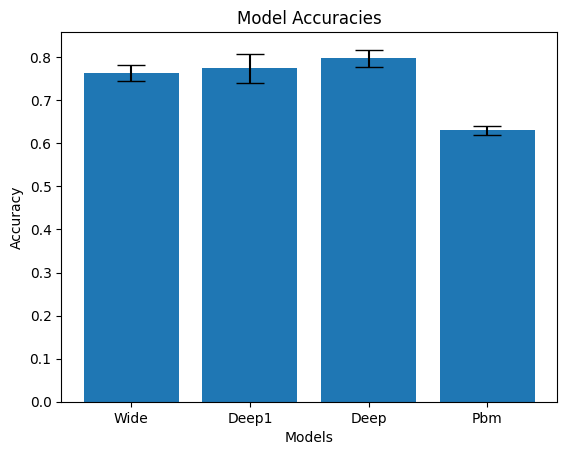

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_80.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

        DV1    DV2     DV3       V       G1       G2        G3      Dend  \
0     1.384  0.082 -7.9281  14.018  49.6286  10.6654  202.0216  145.7748   
1     1.264  0.112 -7.9100  14.006  49.5056  10.6504  201.2316  147.1748   
2     1.219  0.106 -7.9160  14.012  49.3876  10.6384  200.4416  148.5748   
3     1.219  0.085 -7.9190  14.015  49.2666  10.6274  199.6416  149.9748   
4     1.225  0.030 -7.9190  14.015  49.1446  10.6164  198.8516  151.3748   
...     ...    ...     ...     ...      ...      ...       ...       ...   
5569  1.914 -1.823 -5.3431  12.957  18.4540  25.3780  183.4000  169.1348   
5570  1.805 -1.545 -5.2241  12.835  18.2680  25.5460  182.8700  170.4248   
5571  1.667 -1.308 -5.1267  12.765  18.0900  25.6810  182.3500  171.6948   
5572  1.439 -1.167 -5.1023  12.832  17.9230  25.7940  181.8500  172.9548   
5573  1.082 -1.140 -5.1629  13.042  17.7840  25.8990  181.3500  174.2448   

         Carid  label_targetlane  
0    -1.550351                 1  
1    -1.550351   

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([5574, 9])
torch.Size([5574, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(0.0340, requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(0.0747, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0.1890, requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0.0450, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0288, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0., requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.0023, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(0.0006, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 6.74650
Epoch: 10, loss: 0.51222
Epoch: 20, loss: 0.55027
Epoch: 30, loss: 0.50882
Epoch: 40, loss: 0.48727
Epoch: 50, loss: 0.47351
Epoch: 60, loss: 0.46315
Epoch: 70, loss: 0.45268
Epoch: 80, loss: 0.44442
Epoch: 90, loss: 0.43853
Epoch: 100, loss: 0.43394
Epoch: 110, loss: 0.43035
Epoch: 120, loss: 0.42694
Epoch: 130, loss: 0.42357
Epoch: 140, loss: 0.42062
Epoch: 150, loss: 0.41763
Epoch: 160, loss: 0.41452
Epoch: 170, loss: 0.41175
Epoch: 180, loss: 0.40941
Epoch: 190, loss: 0.40730
Epoch: 200, loss: 0.40513
Epoch: 210, loss: 0.40285
Epoch: 220, loss: 0.39989
Epoch: 230, loss: 0.39690
Epoch: 240, loss: 0.39376
Epoch: 249, loss: 0.39024


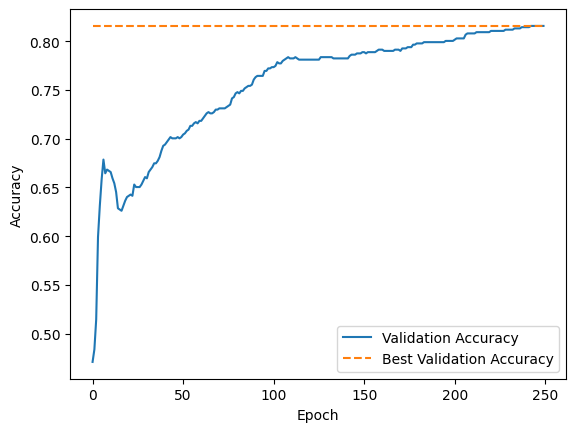

Accuracy (wide): 0.82
Epoch: 0, loss: 1.19162
Epoch: 10, loss: 0.50987
Epoch: 20, loss: 0.45848
Epoch: 30, loss: 0.42977
Epoch: 40, loss: 0.40977
Epoch: 50, loss: 0.39205
Epoch: 60, loss: 0.37889
Epoch: 70, loss: 0.37044
Epoch: 80, loss: 0.36359
Epoch: 90, loss: 0.35641
Epoch: 100, loss: 0.35087
Epoch: 110, loss: 0.34685
Epoch: 120, loss: 0.34348
Epoch: 130, loss: 0.34080
Epoch: 140, loss: 0.33875
Epoch: 150, loss: 0.33689
Epoch: 160, loss: 0.33505
Epoch: 170, loss: 0.33313
Epoch: 180, loss: 0.33131
Epoch: 190, loss: 0.32977
Epoch: 200, loss: 0.32838
Epoch: 210, loss: 0.32702
Epoch: 220, loss: 0.32590
Epoch: 230, loss: 0.32448
Epoch: 240, loss: 0.32286
Epoch: 249, loss: 0.32174


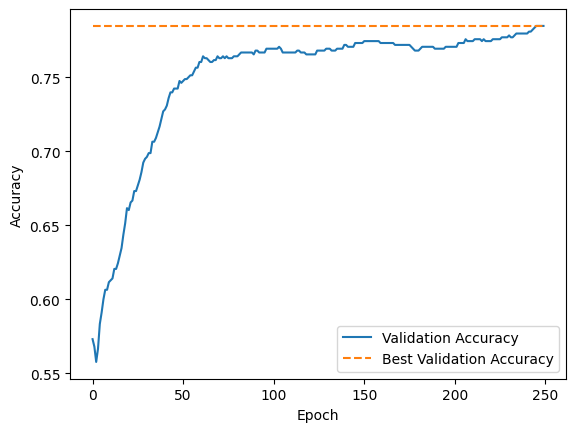

Accuracy (wide): 0.78
Epoch: 0, loss: 3.94532
Epoch: 10, loss: 0.49883
Epoch: 20, loss: 0.44776
Epoch: 30, loss: 0.45219
Epoch: 40, loss: 0.45018
Epoch: 50, loss: 0.44120
Epoch: 60, loss: 0.43126
Epoch: 70, loss: 0.42506
Epoch: 80, loss: 0.42143
Epoch: 90, loss: 0.41854
Epoch: 100, loss: 0.41659
Epoch: 110, loss: 0.41558
Epoch: 120, loss: 0.41512
Epoch: 130, loss: 0.41601
Epoch: 140, loss: 0.41682
Epoch: 150, loss: 0.41691
Epoch: 160, loss: 0.41756
Epoch: 170, loss: 0.41837
Epoch: 180, loss: 0.41881
Epoch: 190, loss: 0.41936
Epoch: 200, loss: 0.41998
Epoch: 210, loss: 0.42035
Epoch: 220, loss: 0.42067
Epoch: 230, loss: 0.42094
Epoch: 240, loss: 0.42114
Epoch: 249, loss: 0.42110


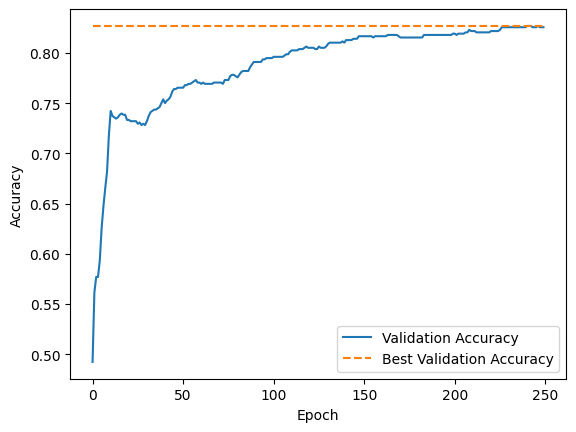

Accuracy (wide): 0.83
Epoch: 0, loss: 2.26261
Epoch: 10, loss: 0.51716
Epoch: 20, loss: 0.43028
Epoch: 30, loss: 0.40043
Epoch: 40, loss: 0.38577
Epoch: 50, loss: 0.37855
Epoch: 60, loss: 0.37649
Epoch: 70, loss: 0.37636
Epoch: 80, loss: 0.37741
Epoch: 90, loss: 0.37784
Epoch: 100, loss: 0.37771
Epoch: 110, loss: 0.37728
Epoch: 120, loss: 0.37623
Epoch: 130, loss: 0.37455
Epoch: 140, loss: 0.37319
Epoch: 150, loss: 0.37182
Epoch: 160, loss: 0.37127
Epoch: 170, loss: 0.37109
Epoch: 180, loss: 0.37109
Epoch: 190, loss: 0.37076
Epoch: 200, loss: 0.37042
Epoch: 210, loss: 0.36999
Epoch: 220, loss: 0.36946
Epoch: 230, loss: 0.36912
Epoch: 240, loss: 0.36894
Epoch: 249, loss: 0.36857


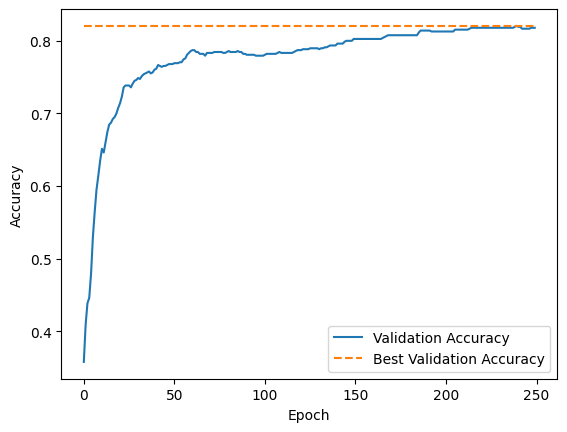

Accuracy (wide): 0.82
Epoch: 0, loss: 12.90276
Epoch: 10, loss: 0.72365
Epoch: 20, loss: 0.52363
Epoch: 30, loss: 0.47302
Epoch: 40, loss: 0.44089
Epoch: 50, loss: 0.41977
Epoch: 60, loss: 0.40291
Epoch: 70, loss: 0.39019
Epoch: 80, loss: 0.38070
Epoch: 90, loss: 0.37228
Epoch: 100, loss: 0.36390
Epoch: 110, loss: 0.35672
Epoch: 120, loss: 0.35058
Epoch: 130, loss: 0.34499
Epoch: 140, loss: 0.34008
Epoch: 150, loss: 0.33615
Epoch: 160, loss: 0.33332
Epoch: 170, loss: 0.33160
Epoch: 180, loss: 0.33026
Epoch: 190, loss: 0.32829
Epoch: 200, loss: 0.32578
Epoch: 210, loss: 0.32342
Epoch: 220, loss: 0.32094
Epoch: 230, loss: 0.31920
Epoch: 240, loss: 0.31800
Epoch: 249, loss: 0.31713


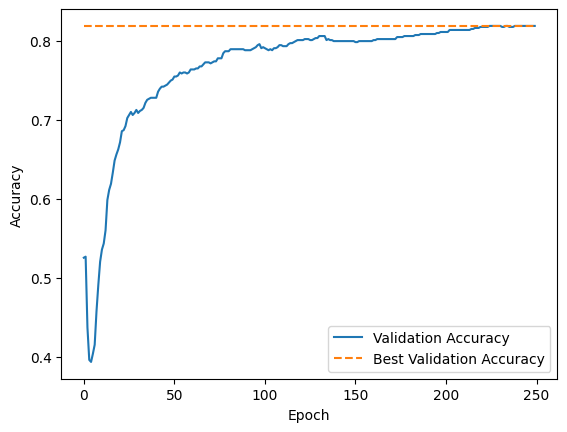

Accuracy (wide): 0.82
Epoch: 0, loss: 0.67177
Epoch: 10, loss: 0.54230
Epoch: 20, loss: 0.51747
Epoch: 30, loss: 0.49475
Epoch: 40, loss: 0.47762
Epoch: 50, loss: 0.46834
Epoch: 60, loss: 0.45828
Epoch: 70, loss: 0.44596
Epoch: 80, loss: 0.43629
Epoch: 90, loss: 0.42736
Epoch: 100, loss: 0.41877
Epoch: 110, loss: 0.41048
Epoch: 120, loss: 0.40308
Epoch: 130, loss: 0.39697
Epoch: 140, loss: 0.39106
Epoch: 150, loss: 0.38536
Epoch: 160, loss: 0.38117
Epoch: 170, loss: 0.37794
Epoch: 180, loss: 0.37516
Epoch: 190, loss: 0.37297
Epoch: 200, loss: 0.37013
Epoch: 210, loss: 0.36838
Epoch: 220, loss: 0.36720
Epoch: 230, loss: 0.36583
Epoch: 240, loss: 0.36561
Epoch: 249, loss: 0.36504


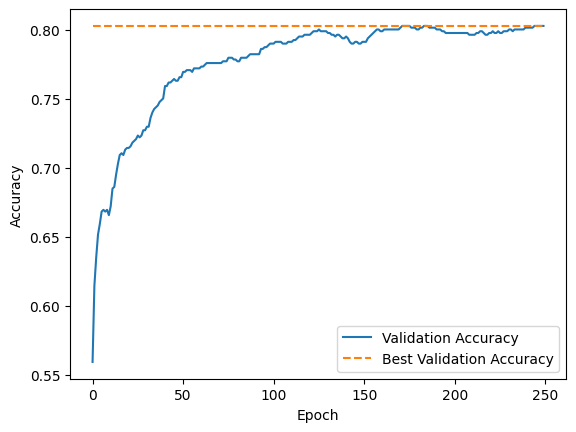

Accuracy (deep1): 0.80
Epoch: 0, loss: 0.75763
Epoch: 10, loss: 0.42625
Epoch: 20, loss: 0.37884
Epoch: 30, loss: 0.35186
Epoch: 40, loss: 0.33394
Epoch: 50, loss: 0.31846
Epoch: 60, loss: 0.30469
Epoch: 70, loss: 0.29327
Epoch: 80, loss: 0.28312
Epoch: 90, loss: 0.27488
Epoch: 100, loss: 0.26838
Epoch: 110, loss: 0.26399
Epoch: 120, loss: 0.26035
Epoch: 130, loss: 0.25664
Epoch: 140, loss: 0.25321
Epoch: 150, loss: 0.25053
Epoch: 160, loss: 0.24787
Epoch: 170, loss: 0.24598
Epoch: 180, loss: 0.24361
Epoch: 190, loss: 0.24093
Epoch: 200, loss: 0.23719
Epoch: 210, loss: 0.23655
Epoch: 220, loss: 0.23358
Epoch: 230, loss: 0.23097
Epoch: 240, loss: 0.22829
Epoch: 249, loss: 0.22540


Accuracy (deep1): 0.86
Epoch: 0, loss: 0.64326
Epoch: 10, loss: 0.52058
Epoch: 20, loss: 0.49598
Epoch: 30, loss: 0.47456
Epoch: 40, loss: 0.45895
Epoch: 50, loss: 0.44722
Epoch: 60, loss: 0.43636
Epoch: 70, loss: 0.42720
Epoch: 80, loss: 0.41820
Epoch: 90, loss: 0.40995
Epoch: 100, loss: 0.40324
Epoch: 110, loss: 0.39676
Epoch: 120, loss: 0.39064
Epoch: 130, loss: 0.38486
Epoch: 140, loss: 0.38042
Epoch: 150, loss: 0.37653
Epoch: 160, loss: 0.37340
Epoch: 170, loss: 0.37027
Epoch: 180, loss: 0.36796
Epoch: 190, loss: 0.36593
Epoch: 200, loss: 0.36457
Epoch: 210, loss: 0.36379
Epoch: 220, loss: 0.36331
Epoch: 230, loss: 0.36248
Epoch: 240, loss: 0.36192
Epoch: 249, loss: 0.36160


Accuracy (deep1): 0.83
Epoch: 0, loss: 0.87854
Epoch: 10, loss: 0.48765
Epoch: 20, loss: 0.44575
Epoch: 30, loss: 0.42246
Epoch: 40, loss: 0.40427
Epoch: 50, loss: 0.39084
Epoch: 60, loss: 0.37887
Epoch: 70, loss: 0.36766
Epoch: 80, loss: 0.35755
Epoch: 90, loss: 0.34767
Epoch: 100, loss: 0.33839
Epoch: 110, loss: 0.32962
Epoch: 120, loss: 0.32153
Epoch: 130, loss: 0.31558
Epoch: 140, loss: 0.31063
Epoch: 150, loss: 0.30600
Epoch: 160, loss: 0.30178
Epoch: 170, loss: 0.29752
Epoch: 180, loss: 0.29426
Epoch: 190, loss: 0.29222
Epoch: 200, loss: 0.28981
Epoch: 210, loss: 0.28762
Epoch: 220, loss: 0.28640
Epoch: 230, loss: 0.28639
Epoch: 240, loss: 0.28601
Epoch: 249, loss: 0.28572


Accuracy (deep1): 0.83
Epoch: 0, loss: 0.65776
Epoch: 10, loss: 0.54026
Epoch: 20, loss: 0.51131
Epoch: 30, loss: 0.49466
Epoch: 40, loss: 0.48020
Epoch: 50, loss: 0.46478
Epoch: 60, loss: 0.45063
Epoch: 70, loss: 0.43807
Epoch: 80, loss: 0.42796
Epoch: 90, loss: 0.41798
Epoch: 100, loss: 0.40998
Epoch: 110, loss: 0.40286
Epoch: 120, loss: 0.39623
Epoch: 130, loss: 0.39044
Epoch: 140, loss: 0.38530
Epoch: 150, loss: 0.38039
Epoch: 160, loss: 0.37549
Epoch: 170, loss: 0.37021
Epoch: 180, loss: 0.36427
Epoch: 190, loss: 0.35881
Epoch: 200, loss: 0.35503
Epoch: 210, loss: 0.35164
Epoch: 220, loss: 0.34848
Epoch: 230, loss: 0.34567
Epoch: 240, loss: 0.34272
Epoch: 249, loss: 0.33932


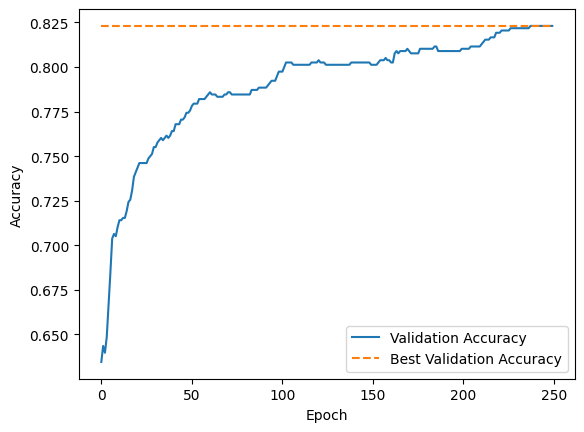

Accuracy (deep1): 0.82
Epoch: 0, loss: 0.54934
Epoch: 10, loss: 0.50691
Epoch: 20, loss: 0.49473
Epoch: 30, loss: 0.48446
Epoch: 40, loss: 0.47393
Epoch: 50, loss: 0.46380
Epoch: 60, loss: 0.45305
Epoch: 70, loss: 0.44318
Epoch: 80, loss: 0.43346
Epoch: 90, loss: 0.42348
Epoch: 100, loss: 0.41377
Epoch: 110, loss: 0.40450
Epoch: 120, loss: 0.39558
Epoch: 130, loss: 0.38677
Epoch: 140, loss: 0.37817
Epoch: 150, loss: 0.37030
Epoch: 160, loss: 0.36292
Epoch: 170, loss: 0.35578
Epoch: 180, loss: 0.34904
Epoch: 190, loss: 0.34276
Epoch: 200, loss: 0.33715
Epoch: 210, loss: 0.33208
Epoch: 220, loss: 0.32767
Epoch: 230, loss: 0.32449
Epoch: 240, loss: 0.32187
Epoch: 249, loss: 0.31888


Accuracy (deep): 0.82
Epoch: 0, loss: 0.66023
Epoch: 10, loss: 0.52570
Epoch: 20, loss: 0.50022
Epoch: 30, loss: 0.48621
Epoch: 40, loss: 0.47596
Epoch: 50, loss: 0.46567
Epoch: 60, loss: 0.45529
Epoch: 70, loss: 0.44740
Epoch: 80, loss: 0.43997
Epoch: 90, loss: 0.43347
Epoch: 100, loss: 0.42821
Epoch: 110, loss: 0.42253
Epoch: 120, loss: 0.41734
Epoch: 130, loss: 0.41265
Epoch: 140, loss: 0.40871
Epoch: 150, loss: 0.40496
Epoch: 160, loss: 0.40146
Epoch: 170, loss: 0.39846
Epoch: 180, loss: 0.39604
Epoch: 190, loss: 0.39406
Epoch: 200, loss: 0.39241
Epoch: 210, loss: 0.39070
Epoch: 220, loss: 0.38940
Epoch: 230, loss: 0.38873
Epoch: 240, loss: 0.38896
Epoch: 249, loss: 0.38890


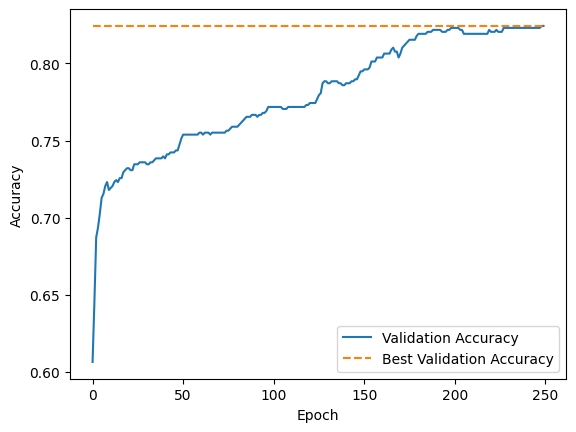

Accuracy (deep): 0.82
Epoch: 0, loss: 0.74305
Epoch: 10, loss: 0.45297
Epoch: 20, loss: 0.42156
Epoch: 30, loss: 0.39935
Epoch: 40, loss: 0.38333
Epoch: 50, loss: 0.36871
Epoch: 60, loss: 0.35599
Epoch: 70, loss: 0.34718
Epoch: 80, loss: 0.33888
Epoch: 90, loss: 0.32972
Epoch: 100, loss: 0.32094
Epoch: 110, loss: 0.31355
Epoch: 120, loss: 0.30646
Epoch: 130, loss: 0.29976
Epoch: 140, loss: 0.29445
Epoch: 150, loss: 0.29042
Epoch: 160, loss: 0.28724
Epoch: 170, loss: 0.28397
Epoch: 180, loss: 0.28100
Epoch: 190, loss: 0.27819
Epoch: 200, loss: 0.27589
Epoch: 210, loss: 0.27400
Epoch: 220, loss: 0.27264
Epoch: 230, loss: 0.27136
Epoch: 240, loss: 0.27046
Epoch: 249, loss: 0.26974


Accuracy (deep): 0.85
Epoch: 0, loss: 0.59388
Epoch: 10, loss: 0.48450
Epoch: 20, loss: 0.46709
Epoch: 30, loss: 0.45546
Epoch: 40, loss: 0.44589
Epoch: 50, loss: 0.43676
Epoch: 60, loss: 0.42817
Epoch: 70, loss: 0.41970
Epoch: 80, loss: 0.41218
Epoch: 90, loss: 0.40495
Epoch: 100, loss: 0.39791
Epoch: 110, loss: 0.39062
Epoch: 120, loss: 0.38368
Epoch: 130, loss: 0.37731
Epoch: 140, loss: 0.37193
Epoch: 150, loss: 0.36753
Epoch: 160, loss: 0.36397
Epoch: 170, loss: 0.36046
Epoch: 180, loss: 0.35751
Epoch: 190, loss: 0.35471
Epoch: 200, loss: 0.35258
Epoch: 210, loss: 0.35045
Epoch: 220, loss: 0.34828
Epoch: 230, loss: 0.34678
Epoch: 240, loss: 0.34483
Epoch: 249, loss: 0.34295


Accuracy (deep): 0.83
Epoch: 0, loss: 0.63614
Epoch: 10, loss: 0.46555
Epoch: 20, loss: 0.43011
Epoch: 30, loss: 0.41817
Epoch: 40, loss: 0.40397
Epoch: 50, loss: 0.39201
Epoch: 60, loss: 0.38155
Epoch: 70, loss: 0.37081
Epoch: 80, loss: 0.36218
Epoch: 90, loss: 0.35534
Epoch: 100, loss: 0.35015
Epoch: 110, loss: 0.34533
Epoch: 120, loss: 0.34063
Epoch: 130, loss: 0.33638
Epoch: 140, loss: 0.33319
Epoch: 150, loss: 0.32976
Epoch: 160, loss: 0.32654
Epoch: 170, loss: 0.32348
Epoch: 180, loss: 0.32104
Epoch: 190, loss: 0.31805
Epoch: 200, loss: 0.31574
Epoch: 210, loss: 0.31409
Epoch: 220, loss: 0.31244
Epoch: 230, loss: 0.31182
Epoch: 240, loss: 0.31073
Epoch: 249, loss: 0.30958


Accuracy (deep): 0.84
Epoch: 0, loss: 1.02905
Epoch: 10, loss: 0.86152
Epoch: 20, loss: 0.79912
Epoch: 30, loss: 0.71876
Epoch: 40, loss: 0.67544
Epoch: 50, loss: 0.65272
Epoch: 60, loss: 0.64133
Epoch: 70, loss: 0.63561
Epoch: 80, loss: 0.63234
Epoch: 90, loss: 0.63012
Epoch: 100, loss: 0.62837
Epoch: 110, loss: 0.62688
Epoch: 120, loss: 0.62556
Epoch: 130, loss: 0.62437
Epoch: 140, loss: 0.62330
Epoch: 150, loss: 0.62232
Epoch: 160, loss: 0.62142
Epoch: 170, loss: 0.62059
Epoch: 180, loss: 0.61982
Epoch: 190, loss: 0.61911
Epoch: 200, loss: 0.61844
Epoch: 210, loss: 0.61781
Epoch: 220, loss: 0.61722
Epoch: 230, loss: 0.61666
Epoch: 240, loss: 0.61612
Epoch: 249, loss: 0.61566


Accuracy (pbm): 0.63
Epoch: 0, loss: 1.04323
Epoch: 10, loss: 0.99996
Epoch: 20, loss: 0.87274
Epoch: 30, loss: 0.76011
Epoch: 40, loss: 0.70614
Epoch: 50, loss: 0.67992
Epoch: 60, loss: 0.66510
Epoch: 70, loss: 0.65529
Epoch: 80, loss: 0.64795
Epoch: 90, loss: 0.64196
Epoch: 100, loss: 0.63681
Epoch: 110, loss: 0.63225
Epoch: 120, loss: 0.62813
Epoch: 130, loss: 0.62438
Epoch: 140, loss: 0.62094
Epoch: 150, loss: 0.61776
Epoch: 160, loss: 0.61482
Epoch: 170, loss: 0.61208
Epoch: 180, loss: 0.60953
Epoch: 190, loss: 0.60714
Epoch: 200, loss: 0.60490
Epoch: 210, loss: 0.60279
Epoch: 220, loss: 0.60080
Epoch: 230, loss: 0.59893
Epoch: 240, loss: 0.59715
Epoch: 249, loss: 0.59562


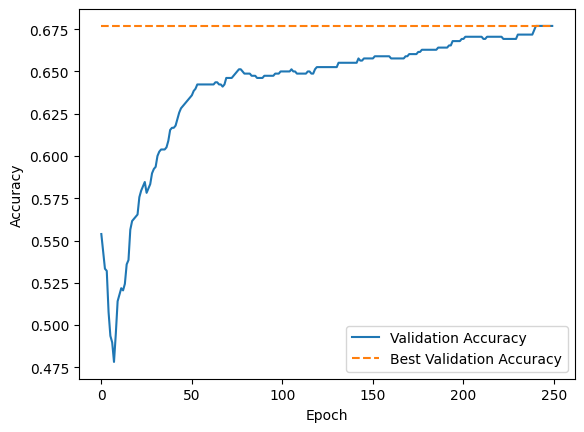

Accuracy (pbm): 0.68
Epoch: 0, loss: 1.38958
Epoch: 10, loss: 1.10329
Epoch: 20, loss: 0.96843
Epoch: 30, loss: 0.84473
Epoch: 40, loss: 0.78221
Epoch: 50, loss: 0.75166
Epoch: 60, loss: 0.73447
Epoch: 70, loss: 0.72274
Epoch: 80, loss: 0.71358
Epoch: 90, loss: 0.70580
Epoch: 100, loss: 0.69891
Epoch: 110, loss: 0.69267
Epoch: 120, loss: 0.68694
Epoch: 130, loss: 0.68164
Epoch: 140, loss: 0.67671
Epoch: 150, loss: 0.67212
Epoch: 160, loss: 0.66784
Epoch: 170, loss: 0.66382
Epoch: 180, loss: 0.66005
Epoch: 190, loss: 0.65649
Epoch: 200, loss: 0.65314
Epoch: 210, loss: 0.64997
Epoch: 220, loss: 0.64697
Epoch: 230, loss: 0.64413
Epoch: 240, loss: 0.64142
Epoch: 249, loss: 0.63910


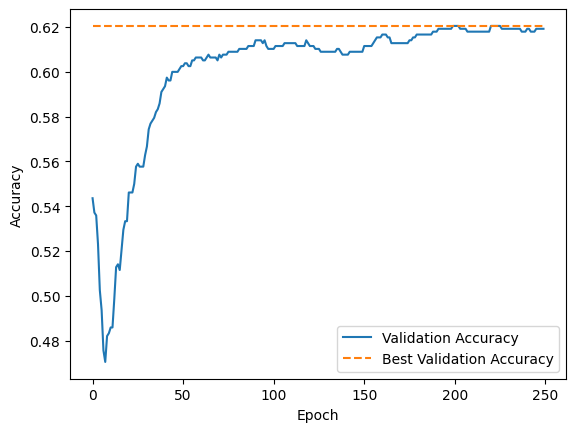

Accuracy (pbm): 0.62
Epoch: 0, loss: 1.11593
Epoch: 10, loss: 0.93585
Epoch: 20, loss: 0.83245
Epoch: 30, loss: 0.74863
Epoch: 40, loss: 0.70848
Epoch: 50, loss: 0.68930
Epoch: 60, loss: 0.67873
Epoch: 70, loss: 0.67184
Epoch: 80, loss: 0.66672
Epoch: 90, loss: 0.66256
Epoch: 100, loss: 0.65898
Epoch: 110, loss: 0.65580
Epoch: 120, loss: 0.65293
Epoch: 130, loss: 0.65032
Epoch: 140, loss: 0.64791
Epoch: 150, loss: 0.64569
Epoch: 160, loss: 0.64363
Epoch: 170, loss: 0.64171
Epoch: 180, loss: 0.63991
Epoch: 190, loss: 0.63823
Epoch: 200, loss: 0.63665
Epoch: 210, loss: 0.63516
Epoch: 220, loss: 0.63375
Epoch: 230, loss: 0.63242
Epoch: 240, loss: 0.63116
Epoch: 249, loss: 0.63008


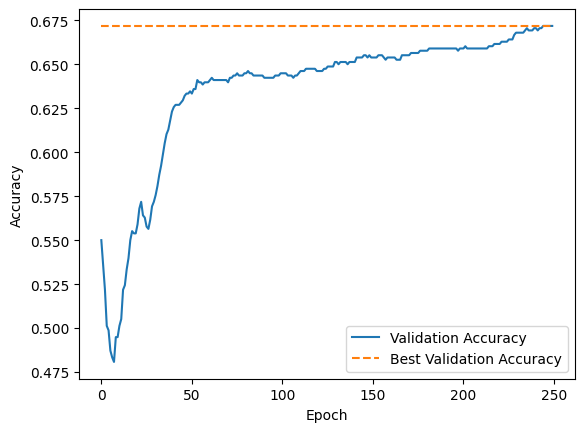

Accuracy (pbm): 0.67
Epoch: 0, loss: 1.05262
Epoch: 10, loss: 0.94752
Epoch: 20, loss: 0.89459
Epoch: 30, loss: 0.81925
Epoch: 40, loss: 0.77917
Epoch: 50, loss: 0.75702
Epoch: 60, loss: 0.74288
Epoch: 70, loss: 0.73253
Epoch: 80, loss: 0.72416
Epoch: 90, loss: 0.71696
Epoch: 100, loss: 0.71055
Epoch: 110, loss: 0.70474
Epoch: 120, loss: 0.69943
Epoch: 130, loss: 0.69455
Epoch: 140, loss: 0.69004
Epoch: 150, loss: 0.68587
Epoch: 160, loss: 0.68201
Epoch: 170, loss: 0.67843
Epoch: 180, loss: 0.67510
Epoch: 190, loss: 0.67199
Epoch: 200, loss: 0.66910
Epoch: 210, loss: 0.66640
Epoch: 220, loss: 0.66387
Epoch: 230, loss: 0.66150
Epoch: 240, loss: 0.65928
Epoch: 249, loss: 0.65740


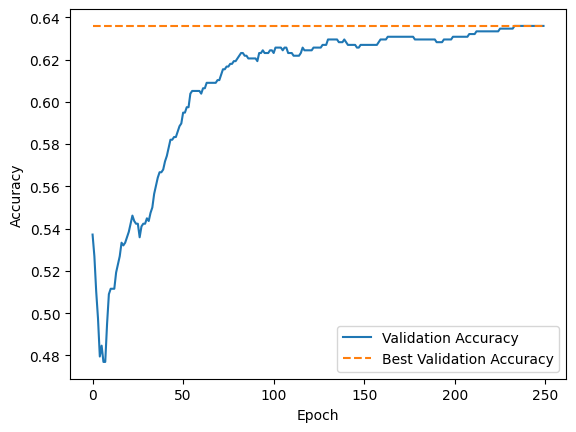

Accuracy (pbm): 0.64


Wide: 81.34% (+/- 1.48%)
Deep1: 83.08% (+/- 1.98%)
Deep: 83.24% (+/- 1.12%)
Pbm: 64.70% (+/- 2.29%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




80%: Wide: 81.52% (+/- 2.19%)
Deep1: 83.08% (+/- 1.37%)
Deep: 82.11% (+/- 1.38%)
Pbm: 64.86% (+/- 1.16%)

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20_90.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

           DV1       DV2       DV3          V         G1         G2  \
0     0.338328  5.669280  0.231648  11.999976   5.961583  40.393315   
1     0.167640  5.367528 -0.073152  12.100560   5.947258  39.836750   
2     0.088392  5.013960 -0.085344  12.146280   5.938418  39.313714   
3     0.042672  4.645152 -0.067056  12.170664   5.933237  38.833044   
4     4.349000  0.018000 -1.533000  12.180000  38.392400   5.932600   
...        ...       ...       ...        ...        ...        ...   
6147 -0.505968  2.261616 -0.646176  12.704064  12.159996  30.835397   
6148 -0.280416  2.532888 -0.505968  12.496800  12.194743  30.609540   
6149 -0.109728  2.840736 -0.271272  12.332208  12.209069  30.328819   
6150  0.024384  3.005328 -0.036576  12.234672  12.211507  30.019447   
6151  0.152400  3.044952  0.097536  12.195048  12.203582  29.711904   

              G3        Dend     Carid  label_targetlane  
0      20.260361  159.195516  0.827646                 0  
1       5.966460  160.407706 

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([6152, 9])
torch.Size([6152, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(-0.0177, requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(-0.0123, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0.1247, requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0.0246, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0352, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.0252, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.0079, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(-0.0008, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 4.88565
Epoch: 10, loss: 1.24955
Epoch: 20, loss: 0.99210
Epoch: 30, loss: 0.82844
Epoch: 40, loss: 0.75051
Epoch: 50, loss: 0.71574
Epoch: 60, loss: 0.69983
Epoch: 70, loss: 0.68783
Epoch: 80, loss: 0.67828
Epoch: 90, loss: 0.66923
Epoch: 100, loss: 0.66030
Epoch: 110, loss: 0.65262
Epoch: 120, loss: 0.64585
Epoch: 130, loss: 0.63963
Epoch: 140, loss: 0.63550
Epoch: 150, loss: 0.63205
Epoch: 160, loss: 0.62855
Epoch: 170, loss: 0.62403
Epoch: 180, loss: 0.61955
Epoch: 190, loss: 0.61564
Epoch: 200, loss: 0.61181
Epoch: 210, loss: 0.60840
Epoch: 220, loss: 0.60491
Epoch: 230, loss: 0.60120
Epoch: 240, loss: 0.59762
Epoch: 249, loss: 0.59441


Accuracy (wide): 0.80
Epoch: 0, loss: 4.00802
Epoch: 10, loss: 0.93463
Epoch: 20, loss: 0.81034
Epoch: 30, loss: 0.74479
Epoch: 40, loss: 0.71022
Epoch: 50, loss: 0.68538
Epoch: 60, loss: 0.66679
Epoch: 70, loss: 0.65292
Epoch: 80, loss: 0.64074
Epoch: 90, loss: 0.63010
Epoch: 100, loss: 0.62124
Epoch: 110, loss: 0.61247
Epoch: 120, loss: 0.60471
Epoch: 130, loss: 0.59662
Epoch: 140, loss: 0.58871
Epoch: 150, loss: 0.58081
Epoch: 160, loss: 0.57283
Epoch: 170, loss: 0.56459
Epoch: 180, loss: 0.55606
Epoch: 190, loss: 0.54813
Epoch: 200, loss: 0.54116
Epoch: 210, loss: 0.53534
Epoch: 220, loss: 0.52921
Epoch: 230, loss: 0.52324
Epoch: 240, loss: 0.51753
Epoch: 249, loss: 0.51284


Accuracy (wide): 0.75
Epoch: 0, loss: 13.78710
Epoch: 10, loss: 1.18548
Epoch: 20, loss: 0.93243
Epoch: 30, loss: 0.86526
Epoch: 40, loss: 0.82900
Epoch: 50, loss: 0.80001
Epoch: 60, loss: 0.77419
Epoch: 70, loss: 0.75123
Epoch: 80, loss: 0.73268
Epoch: 90, loss: 0.71843
Epoch: 100, loss: 0.70696
Epoch: 110, loss: 0.69742
Epoch: 120, loss: 0.68925
Epoch: 130, loss: 0.68215
Epoch: 140, loss: 0.67532
Epoch: 150, loss: 0.66911
Epoch: 160, loss: 0.66381
Epoch: 170, loss: 0.65872
Epoch: 180, loss: 0.65359
Epoch: 190, loss: 0.64857
Epoch: 200, loss: 0.64322
Epoch: 210, loss: 0.63820
Epoch: 220, loss: 0.63342
Epoch: 230, loss: 0.62934
Epoch: 240, loss: 0.62544
Epoch: 249, loss: 0.62213


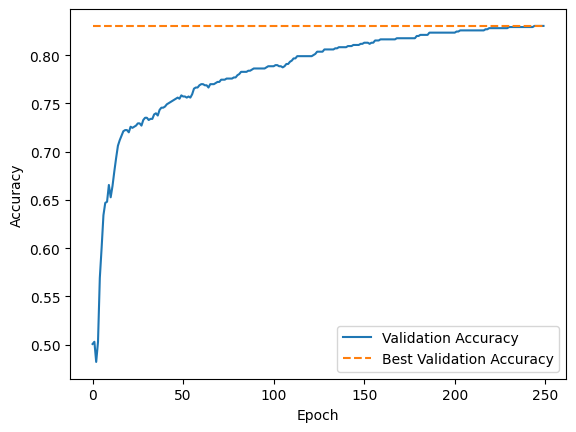

Accuracy (wide): 0.83
Epoch: 0, loss: 1.05190
Epoch: 10, loss: 0.90561
Epoch: 20, loss: 0.88360
Epoch: 30, loss: 0.83568
Epoch: 40, loss: 0.79462
Epoch: 50, loss: 0.76441
Epoch: 60, loss: 0.74290
Epoch: 70, loss: 0.72588
Epoch: 80, loss: 0.71053
Epoch: 90, loss: 0.69597
Epoch: 100, loss: 0.68212
Epoch: 110, loss: 0.66872
Epoch: 120, loss: 0.65650
Epoch: 130, loss: 0.64891
Epoch: 140, loss: 0.64189
Epoch: 150, loss: 0.63552
Epoch: 160, loss: 0.62970
Epoch: 170, loss: 0.62405
Epoch: 180, loss: 0.61879
Epoch: 190, loss: 0.61382
Epoch: 200, loss: 0.60896
Epoch: 210, loss: 0.60399
Epoch: 220, loss: 0.59914
Epoch: 230, loss: 0.59491
Epoch: 240, loss: 0.59101
Epoch: 249, loss: 0.58778


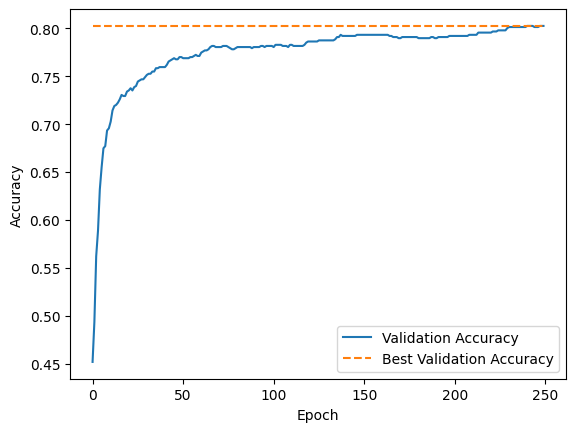

Accuracy (wide): 0.80
Epoch: 0, loss: 3.47638
Epoch: 10, loss: 1.37056
Epoch: 20, loss: 0.90026
Epoch: 30, loss: 0.84077
Epoch: 40, loss: 0.79608
Epoch: 50, loss: 0.76323
Epoch: 60, loss: 0.73868
Epoch: 70, loss: 0.71926
Epoch: 80, loss: 0.70262
Epoch: 90, loss: 0.68842
Epoch: 100, loss: 0.67648
Epoch: 110, loss: 0.66649
Epoch: 120, loss: 0.65781
Epoch: 130, loss: 0.64993
Epoch: 140, loss: 0.64251
Epoch: 150, loss: 0.63595
Epoch: 160, loss: 0.62980
Epoch: 170, loss: 0.62356
Epoch: 180, loss: 0.61711
Epoch: 190, loss: 0.61134
Epoch: 200, loss: 0.60594
Epoch: 210, loss: 0.60137
Epoch: 220, loss: 0.59670
Epoch: 230, loss: 0.59258
Epoch: 240, loss: 0.58870
Epoch: 249, loss: 0.58520


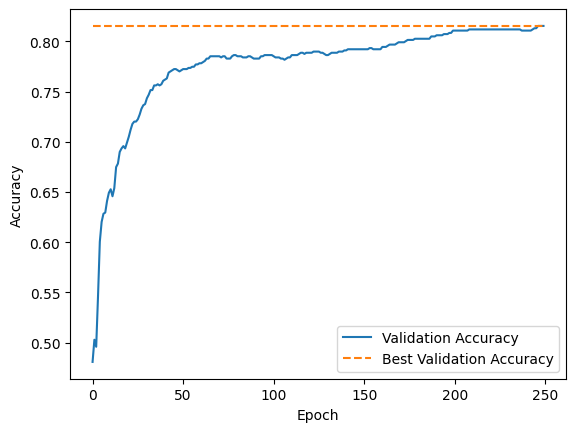

Accuracy (wide): 0.82
Epoch: 0, loss: 0.70712
Epoch: 10, loss: 0.86817
Epoch: 20, loss: 0.85212
Epoch: 30, loss: 0.83590
Epoch: 40, loss: 0.82717
Epoch: 50, loss: 0.81819
Epoch: 60, loss: 0.80663
Epoch: 70, loss: 0.79452
Epoch: 80, loss: 0.78013
Epoch: 90, loss: 0.76722
Epoch: 100, loss: 0.75323
Epoch: 110, loss: 0.74065
Epoch: 120, loss: 0.72942
Epoch: 130, loss: 0.71989
Epoch: 140, loss: 0.71166
Epoch: 150, loss: 0.70416
Epoch: 160, loss: 0.69634
Epoch: 170, loss: 0.68982
Epoch: 180, loss: 0.68127
Epoch: 190, loss: 0.67449
Epoch: 200, loss: 0.66796
Epoch: 210, loss: 0.66145
Epoch: 220, loss: 0.65550
Epoch: 230, loss: 0.65038
Epoch: 240, loss: 0.64607
Epoch: 249, loss: 0.63964


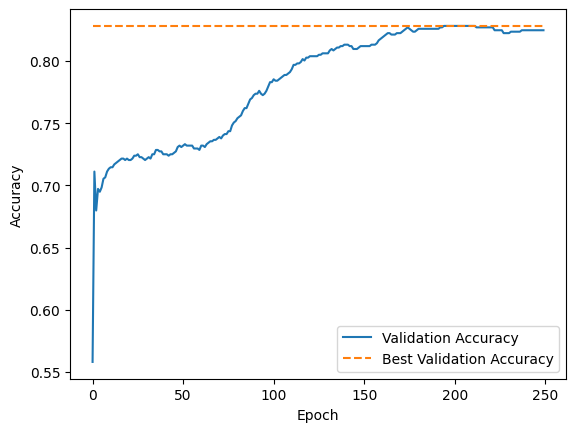

Accuracy (deep1): 0.83
Epoch: 0, loss: 0.95491
Epoch: 10, loss: 0.83611
Epoch: 20, loss: 0.82209
Epoch: 30, loss: 0.81478
Epoch: 40, loss: 0.80627
Epoch: 50, loss: 0.79670
Epoch: 60, loss: 0.78647
Epoch: 70, loss: 0.77646
Epoch: 80, loss: 0.76442
Epoch: 90, loss: 0.75694
Epoch: 100, loss: 0.74988
Epoch: 110, loss: 0.74155
Epoch: 120, loss: 0.72937
Epoch: 130, loss: 0.71815
Epoch: 140, loss: 0.70662
Epoch: 150, loss: 0.69465
Epoch: 160, loss: 0.68213
Epoch: 170, loss: 0.66994
Epoch: 180, loss: 0.65849
Epoch: 190, loss: 0.64526
Epoch: 200, loss: 0.63388
Epoch: 210, loss: 0.62367
Epoch: 220, loss: 0.61269
Epoch: 230, loss: 0.60193
Epoch: 240, loss: 0.59162
Epoch: 249, loss: 0.58337


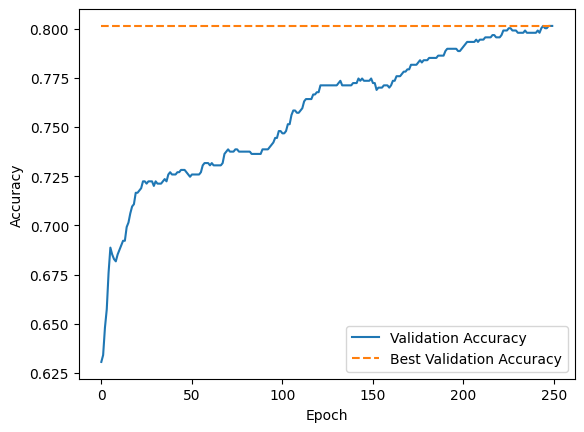

Accuracy (deep1): 0.80
Epoch: 0, loss: 0.75641
Epoch: 10, loss: 0.76838
Epoch: 20, loss: 0.76573
Epoch: 30, loss: 0.75851
Epoch: 40, loss: 0.75042
Epoch: 50, loss: 0.74050
Epoch: 60, loss: 0.73224
Epoch: 70, loss: 0.72366
Epoch: 80, loss: 0.71616
Epoch: 90, loss: 0.70934
Epoch: 100, loss: 0.70218
Epoch: 110, loss: 0.69548
Epoch: 120, loss: 0.68939
Epoch: 130, loss: 0.68354
Epoch: 140, loss: 0.67866
Epoch: 150, loss: 0.67262
Epoch: 160, loss: 0.66784
Epoch: 170, loss: 0.66286
Epoch: 180, loss: 0.65818
Epoch: 190, loss: 0.65262
Epoch: 200, loss: 0.64566
Epoch: 210, loss: 0.63881
Epoch: 220, loss: 0.63237
Epoch: 230, loss: 0.62590
Epoch: 240, loss: 0.61929
Epoch: 249, loss: 0.61355


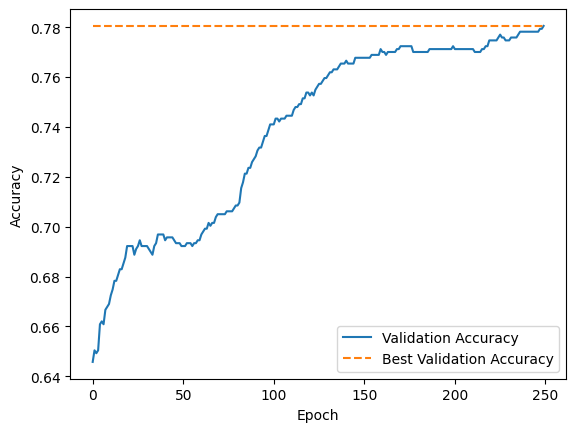

Accuracy (deep1): 0.78
Epoch: 0, loss: 1.31574
Epoch: 10, loss: 0.68914
Epoch: 20, loss: 0.67001
Epoch: 30, loss: 0.65745
Epoch: 40, loss: 0.64348
Epoch: 50, loss: 0.62968
Epoch: 60, loss: 0.61674
Epoch: 70, loss: 0.60560
Epoch: 80, loss: 0.59482
Epoch: 90, loss: 0.58350
Epoch: 100, loss: 0.57294
Epoch: 110, loss: 0.56240
Epoch: 120, loss: 0.55292
Epoch: 130, loss: 0.54431
Epoch: 140, loss: 0.53694
Epoch: 150, loss: 0.52691
Epoch: 160, loss: 0.51811
Epoch: 170, loss: 0.50979
Epoch: 180, loss: 0.50282
Epoch: 190, loss: 0.49648
Epoch: 200, loss: 0.49105
Epoch: 210, loss: 0.48587
Epoch: 220, loss: 0.48089
Epoch: 230, loss: 0.47634
Epoch: 240, loss: 0.47177
Epoch: 249, loss: 0.46773


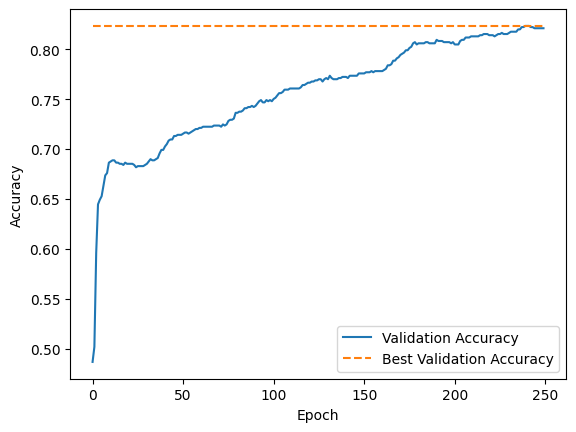

Accuracy (deep1): 0.82
Epoch: 0, loss: 1.81555
Epoch: 10, loss: 0.70895
Epoch: 20, loss: 0.72137
Epoch: 30, loss: 0.72228
Epoch: 40, loss: 0.71769
Epoch: 50, loss: 0.71714
Epoch: 60, loss: 0.71311
Epoch: 70, loss: 0.70884
Epoch: 80, loss: 0.70395
Epoch: 90, loss: 0.70100
Epoch: 100, loss: 0.69517
Epoch: 110, loss: 0.68814
Epoch: 120, loss: 0.67966
Epoch: 130, loss: 0.67295
Epoch: 140, loss: 0.66645
Epoch: 150, loss: 0.66069
Epoch: 160, loss: 0.65478
Epoch: 170, loss: 0.65021
Epoch: 180, loss: 0.64540
Epoch: 190, loss: 0.63250
Epoch: 200, loss: 0.62920
Epoch: 210, loss: 0.62401
Epoch: 220, loss: 0.61792
Epoch: 230, loss: 0.61117
Epoch: 240, loss: 0.60549
Epoch: 249, loss: 0.60105


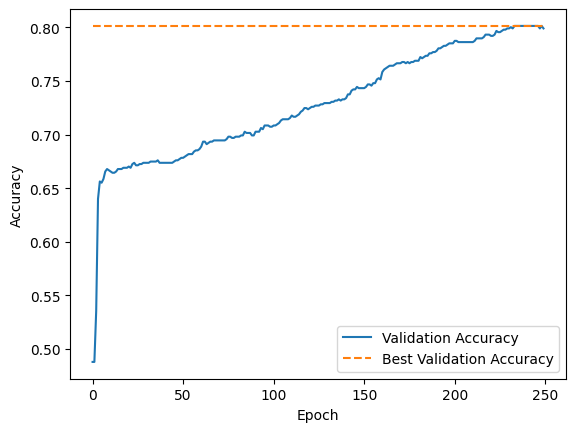

Accuracy (deep1): 0.80
Epoch: 0, loss: 0.72055
Epoch: 10, loss: 0.84495
Epoch: 20, loss: 0.83449
Epoch: 30, loss: 0.82009
Epoch: 40, loss: 0.81070
Epoch: 50, loss: 0.79490
Epoch: 60, loss: 0.78322
Epoch: 70, loss: 0.77526
Epoch: 80, loss: 0.76516
Epoch: 90, loss: 0.75248
Epoch: 100, loss: 0.73845
Epoch: 110, loss: 0.72708
Epoch: 120, loss: 0.71849
Epoch: 130, loss: 0.71074
Epoch: 140, loss: 0.70371
Epoch: 150, loss: 0.69614
Epoch: 160, loss: 0.68882
Epoch: 170, loss: 0.68235
Epoch: 180, loss: 0.67562
Epoch: 190, loss: 0.66820
Epoch: 200, loss: 0.66101
Epoch: 210, loss: 0.65540
Epoch: 220, loss: 0.64897
Epoch: 230, loss: 0.64271
Epoch: 240, loss: 0.63784
Epoch: 249, loss: 0.63363


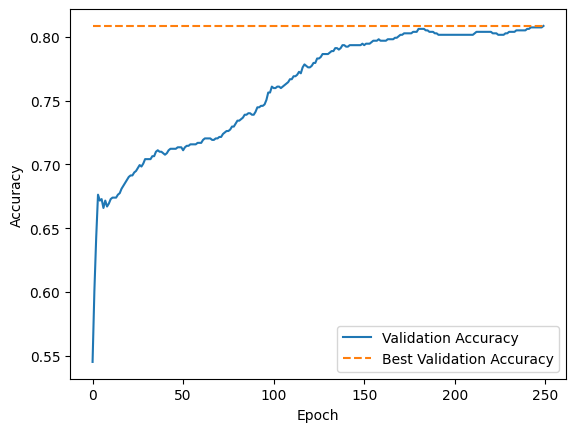

Accuracy (deep): 0.81
Epoch: 0, loss: 0.80030
Epoch: 10, loss: 0.78193
Epoch: 20, loss: 0.75026
Epoch: 30, loss: 0.73891
Epoch: 40, loss: 0.72959
Epoch: 50, loss: 0.72266
Epoch: 60, loss: 0.71714
Epoch: 70, loss: 0.71097
Epoch: 80, loss: 0.70424
Epoch: 90, loss: 0.69860
Epoch: 100, loss: 0.69223
Epoch: 110, loss: 0.68645
Epoch: 120, loss: 0.68168
Epoch: 130, loss: 0.67613
Epoch: 140, loss: 0.67203
Epoch: 150, loss: 0.66754
Epoch: 160, loss: 0.66242
Epoch: 170, loss: 0.65777
Epoch: 180, loss: 0.65346
Epoch: 190, loss: 0.64856
Epoch: 200, loss: 0.64413
Epoch: 210, loss: 0.64111
Epoch: 220, loss: 0.63723
Epoch: 230, loss: 0.63375
Epoch: 240, loss: 0.63074
Epoch: 249, loss: 0.62939


Accuracy (deep): 0.79
Epoch: 0, loss: 0.68167
Epoch: 10, loss: 0.74565
Epoch: 20, loss: 0.74505
Epoch: 30, loss: 0.72957
Epoch: 40, loss: 0.71182
Epoch: 50, loss: 0.69373
Epoch: 60, loss: 0.67384
Epoch: 70, loss: 0.65716
Epoch: 80, loss: 0.64083
Epoch: 90, loss: 0.62487
Epoch: 100, loss: 0.60979
Epoch: 110, loss: 0.59420
Epoch: 120, loss: 0.57707
Epoch: 130, loss: 0.56201
Epoch: 140, loss: 0.54708
Epoch: 150, loss: 0.53506
Epoch: 160, loss: 0.52480
Epoch: 170, loss: 0.51410
Epoch: 180, loss: 0.50403
Epoch: 190, loss: 0.49471
Epoch: 200, loss: 0.48637
Epoch: 210, loss: 0.47899
Epoch: 220, loss: 0.47158
Epoch: 230, loss: 0.46603
Epoch: 240, loss: 0.46076
Epoch: 249, loss: 0.45575


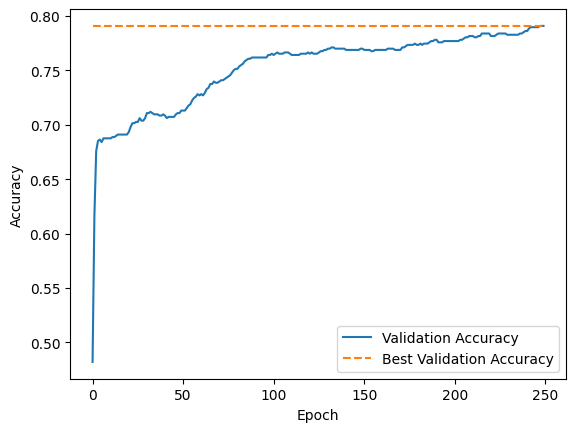

Accuracy (deep): 0.79
Epoch: 0, loss: 0.80420
Epoch: 10, loss: 0.81640
Epoch: 20, loss: 0.78454
Epoch: 30, loss: 0.76746
Epoch: 40, loss: 0.75225
Epoch: 50, loss: 0.73322
Epoch: 60, loss: 0.71043
Epoch: 70, loss: 0.69047
Epoch: 80, loss: 0.67241
Epoch: 90, loss: 0.65643
Epoch: 100, loss: 0.64220
Epoch: 110, loss: 0.62847
Epoch: 120, loss: 0.61556
Epoch: 130, loss: 0.60283
Epoch: 140, loss: 0.59049
Epoch: 150, loss: 0.57879
Epoch: 160, loss: 0.56924
Epoch: 170, loss: 0.56025
Epoch: 180, loss: 0.55044
Epoch: 190, loss: 0.54139
Epoch: 200, loss: 0.53332
Epoch: 210, loss: 0.52449
Epoch: 220, loss: 0.51550
Epoch: 230, loss: 0.50659
Epoch: 240, loss: 0.49814
Epoch: 249, loss: 0.49105


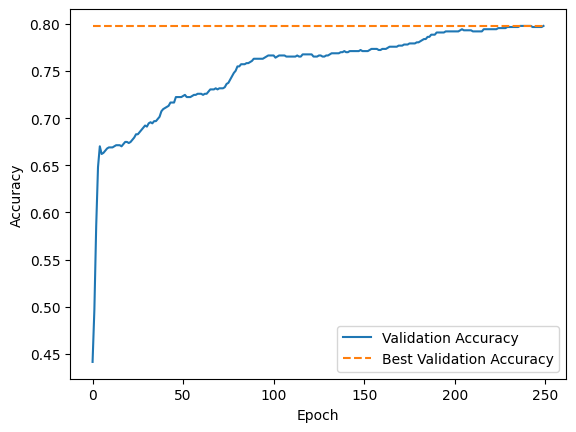

Accuracy (deep): 0.80
Epoch: 0, loss: 0.74195
Epoch: 10, loss: 0.80600
Epoch: 20, loss: 0.81662
Epoch: 30, loss: 0.81263
Epoch: 40, loss: 0.80690
Epoch: 50, loss: 0.79897
Epoch: 60, loss: 0.78871
Epoch: 70, loss: 0.78124
Epoch: 80, loss: 0.77244
Epoch: 90, loss: 0.76442
Epoch: 100, loss: 0.75605
Epoch: 110, loss: 0.74912
Epoch: 120, loss: 0.74224
Epoch: 130, loss: 0.73624
Epoch: 140, loss: 0.72977
Epoch: 150, loss: 0.72279
Epoch: 160, loss: 0.71609
Epoch: 170, loss: 0.70797
Epoch: 180, loss: 0.70304
Epoch: 190, loss: 0.69618
Epoch: 200, loss: 0.69065
Epoch: 210, loss: 0.68541
Epoch: 220, loss: 0.68044
Epoch: 230, loss: 0.67595
Epoch: 240, loss: 0.67217
Epoch: 249, loss: 0.66883


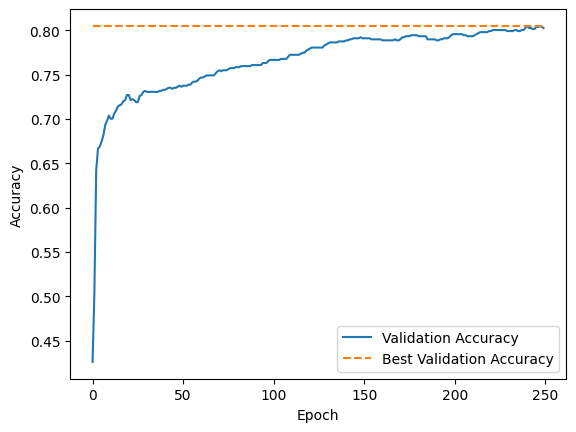

Accuracy (deep): 0.80
Epoch: 0, loss: 1.52926
Epoch: 10, loss: 0.75076
Epoch: 20, loss: 0.68492
Epoch: 30, loss: 0.67873
Epoch: 40, loss: 0.67967
Epoch: 50, loss: 0.67997
Epoch: 60, loss: 0.67964
Epoch: 70, loss: 0.67921
Epoch: 80, loss: 0.67891
Epoch: 90, loss: 0.67881
Epoch: 100, loss: 0.67894
Epoch: 110, loss: 0.67929
Epoch: 120, loss: 0.67985
Epoch: 130, loss: 0.68055
Epoch: 140, loss: 0.68134
Epoch: 150, loss: 0.68219
Epoch: 160, loss: 0.68307
Epoch: 170, loss: 0.68395
Epoch: 180, loss: 0.68483
Epoch: 190, loss: 0.68569
Epoch: 200, loss: 0.68654
Epoch: 210, loss: 0.68738
Epoch: 220, loss: 0.68819
Epoch: 230, loss: 0.68898
Epoch: 240, loss: 0.68975
Epoch: 249, loss: 0.69042


Accuracy (pbm): 0.60
Epoch: 0, loss: 1.51046
Epoch: 10, loss: 0.83403
Epoch: 20, loss: 0.70356
Epoch: 30, loss: 0.66598
Epoch: 40, loss: 0.65227
Epoch: 50, loss: 0.64529
Epoch: 60, loss: 0.64134
Epoch: 70, loss: 0.63954
Epoch: 80, loss: 0.63923
Epoch: 90, loss: 0.63977
Epoch: 100, loss: 0.64071
Epoch: 110, loss: 0.64180
Epoch: 120, loss: 0.64294
Epoch: 130, loss: 0.64408
Epoch: 140, loss: 0.64520
Epoch: 150, loss: 0.64628
Epoch: 160, loss: 0.64733
Epoch: 170, loss: 0.64833
Epoch: 180, loss: 0.64929
Epoch: 190, loss: 0.65021
Epoch: 200, loss: 0.65108
Epoch: 210, loss: 0.65192
Epoch: 220, loss: 0.65272
Epoch: 230, loss: 0.65348
Epoch: 240, loss: 0.65421
Epoch: 249, loss: 0.65483


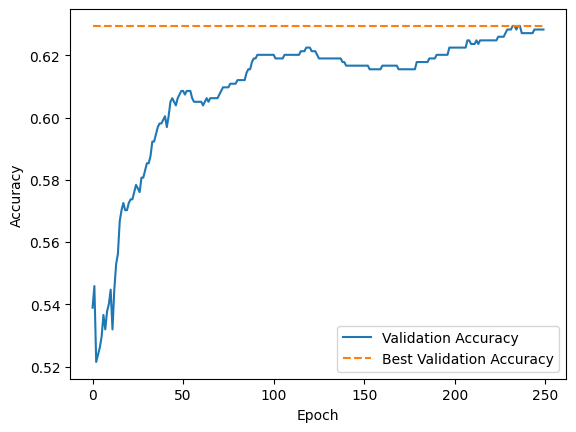

Accuracy (pbm): 0.63
Epoch: 0, loss: 1.28019
Epoch: 10, loss: 0.80887
Epoch: 20, loss: 0.77788
Epoch: 30, loss: 0.77626
Epoch: 40, loss: 0.77434
Epoch: 50, loss: 0.76886
Epoch: 60, loss: 0.76118
Epoch: 70, loss: 0.75346
Epoch: 80, loss: 0.74714
Epoch: 90, loss: 0.74225
Epoch: 100, loss: 0.73832
Epoch: 110, loss: 0.73492
Epoch: 120, loss: 0.73189
Epoch: 130, loss: 0.72914
Epoch: 140, loss: 0.72665
Epoch: 150, loss: 0.72439
Epoch: 160, loss: 0.72233
Epoch: 170, loss: 0.72046
Epoch: 180, loss: 0.71874
Epoch: 190, loss: 0.71716
Epoch: 200, loss: 0.71572
Epoch: 210, loss: 0.71439
Epoch: 220, loss: 0.71316
Epoch: 230, loss: 0.71202
Epoch: 240, loss: 0.71097
Epoch: 249, loss: 0.71009


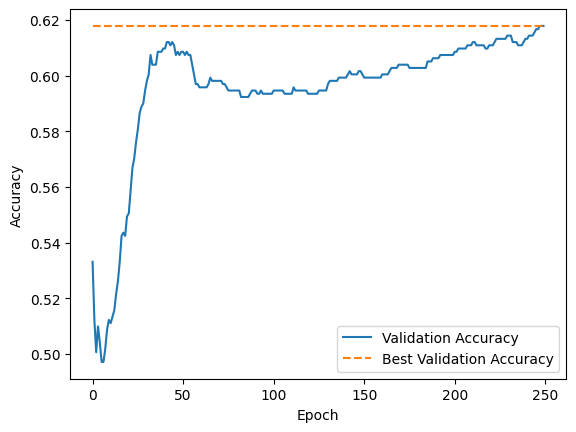

Accuracy (pbm): 0.62
Epoch: 0, loss: 1.53298
Epoch: 10, loss: 0.83727
Epoch: 20, loss: 0.73226
Epoch: 30, loss: 0.69565
Epoch: 40, loss: 0.68006
Epoch: 50, loss: 0.67171
Epoch: 60, loss: 0.66615
Epoch: 70, loss: 0.66171
Epoch: 80, loss: 0.65782
Epoch: 90, loss: 0.65464
Epoch: 100, loss: 0.65268
Epoch: 110, loss: 0.65210
Epoch: 120, loss: 0.65253
Epoch: 130, loss: 0.65351
Epoch: 140, loss: 0.65471
Epoch: 150, loss: 0.65597
Epoch: 160, loss: 0.65722
Epoch: 170, loss: 0.65844
Epoch: 180, loss: 0.65963
Epoch: 190, loss: 0.66077
Epoch: 200, loss: 0.66187
Epoch: 210, loss: 0.66292
Epoch: 220, loss: 0.66393
Epoch: 230, loss: 0.66490
Epoch: 240, loss: 0.66583
Epoch: 249, loss: 0.66663


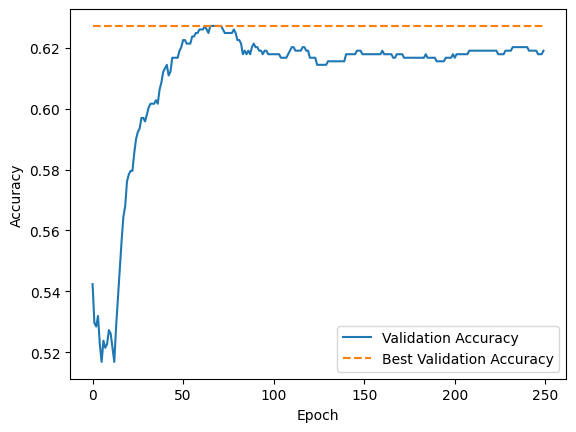

Accuracy (pbm): 0.63
Epoch: 0, loss: 0.94604
Epoch: 10, loss: 0.69684
Epoch: 20, loss: 0.67850
Epoch: 30, loss: 0.68047
Epoch: 40, loss: 0.68104
Epoch: 50, loss: 0.67891
Epoch: 60, loss: 0.67528
Epoch: 70, loss: 0.67105
Epoch: 80, loss: 0.66671
Epoch: 90, loss: 0.66265
Epoch: 100, loss: 0.65933
Epoch: 110, loss: 0.65698
Epoch: 120, loss: 0.65548
Epoch: 130, loss: 0.65456
Epoch: 140, loss: 0.65398
Epoch: 150, loss: 0.65362
Epoch: 160, loss: 0.65340
Epoch: 170, loss: 0.65329
Epoch: 180, loss: 0.65328
Epoch: 190, loss: 0.65334
Epoch: 200, loss: 0.65346
Epoch: 210, loss: 0.65363
Epoch: 220, loss: 0.65385
Epoch: 230, loss: 0.65409
Epoch: 240, loss: 0.65437
Epoch: 249, loss: 0.65463


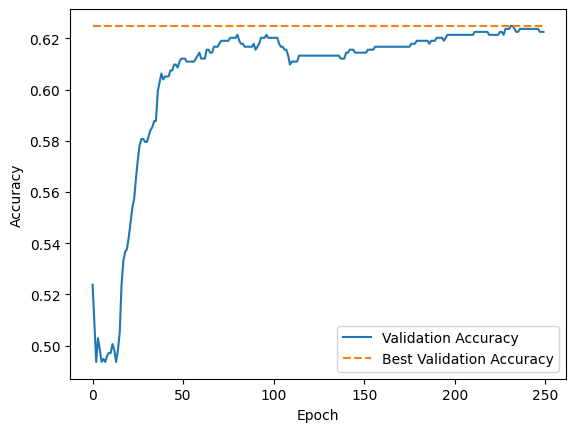

Accuracy (pbm): 0.62


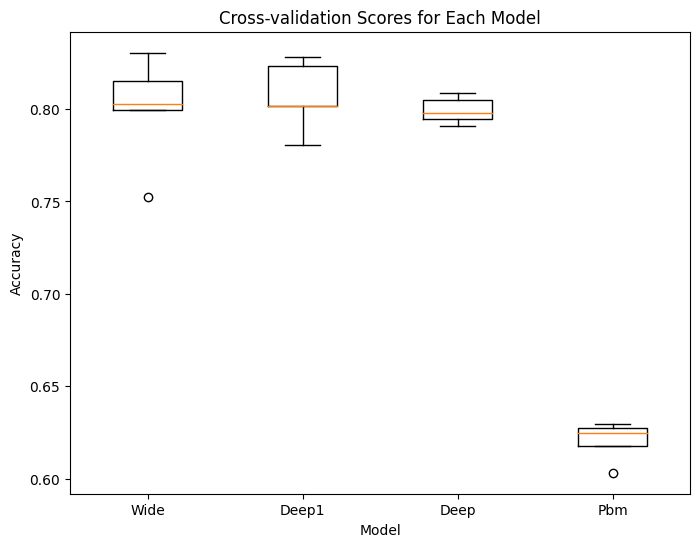

Wide: 80.00% (+/- 2.61%)
Deep1: 80.70% (+/- 1.73%)
Deep: 79.93% (+/- 0.65%)
Pbm: 62.05% (+/- 0.95%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




90%: Wide: 79.70% (+/- 0.87%)
Deep1: 81.33% (+/- 1.74%)
Deep: 80.26% (+/- 2.17%)
Pbm: 61.84% (+/- 1.50%)

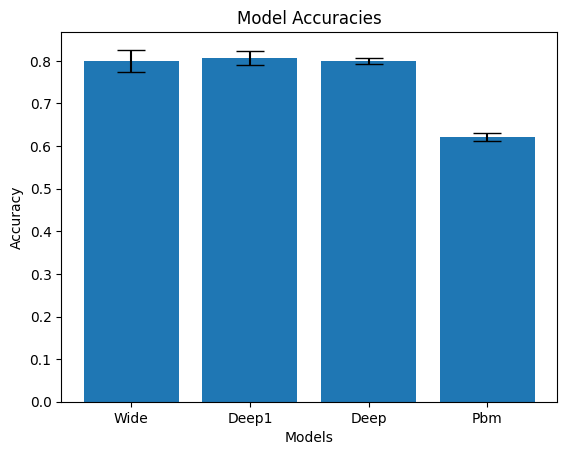

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
import pandas as pd

# Read data
data = pd.read_csv("GapSimLKLCrandsmall_20.csv")
print(data)
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]
print(X)
print(y)

           DV1       DV2       DV3          V         G1         G2  \
0     0.338328  5.669280  0.231648  11.999976   5.961583  40.393315   
1     0.167640  5.367528 -0.073152  12.100560   5.947258  39.836750   
2     0.088392  5.013960 -0.085344  12.146280   5.938418  39.313714   
3     0.042672  4.645152 -0.067056  12.170664   5.933237  38.833044   
4     4.349000  0.018000 -1.533000  12.180000  38.392400   5.932600   
...        ...       ...       ...        ...        ...        ...   
7225 -0.871728  9.448800  5.599176   5.455920  10.931957  33.089393   
7226 -0.969264  9.217152  5.660136   5.620512  11.023397  32.158534   
7227 -1.054608  9.058656  5.562600   5.815584  11.126419  31.256630   
7228 -1.103376  9.015984  4.687824   5.980176  11.239805  30.364786   
7229 -1.109472  9.079992  4.593336   6.074664  11.353800  29.467454   

              G3        Dend     Carid  label_targetlane  
0      20.260361  159.195516  0.827646                 0  
1       5.966460  160.407706 

In [ ]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
print(X.shape)
print(y.shape)

torch.Size([7230, 9])
torch.Size([7230, 1])


In [ ]:
import torch.nn as nn
class PBM(nn.Module):
    def __init__(self):
        super(PBM, self).__init__()
        
        # Define the trainable parameters
        #self.interceptfo = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlead = nn.Parameter(torch.tensor(100., requires_grad = True))
        #self.interceptlag = nn.Parameter(torch.tensor(100., requires_grad = True))
        self.betaDV1fo = nn.Parameter(torch.tensor(-0.0784, requires_grad = True))
        self.betaDV2lead = nn.Parameter(torch.tensor(-0.0289, requires_grad = True))
        self.betaDV3lag = nn.Parameter(torch.tensor(0.1461, requires_grad = True))
        self.betaV = nn.Parameter(torch.tensor(0.0225, requires_grad = True))
        self.betaG1 = nn.Parameter(torch.tensor(0.0355, requires_grad = True))
        self.betaG2 = nn.Parameter(torch.tensor(0.0189, requires_grad = True))
        self.betaG3 = nn.Parameter(torch.tensor(0.0058, requires_grad = True))
        
        self.alphaveh = nn.Parameter(torch.tensor(1., requires_grad = True))
        self.betaD = nn.Parameter(torch.tensor(-0.0003, requires_grad = True))

        

    def forward(self, X):
        # Compute the utilities
        U_fo =  self.betaDV1fo * X[:, 0] + self.betaG1 * X[:, 4] + self.betaD * X[:, 7]
        U_lead =  self.betaDV2lead * X[:, 1] + self.betaG2 * X[:, 5] + self.betaD * X[:, 7]
        U_lag =  self.betaDV3lag * X[:, 2] + self.betaG3 * X[:, 6]  + self.betaD * X[:, 7]
        
        # Compute the gaps and probabilities
        Gfo = torch.log(X[:, 4]) - U_fo
        Glead = torch.log(X[:, 5]) - U_lead
        Glag = torch.log(X[:, 6]) - U_lag
        

        Gaplead = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glead / self.alphaveh)
        Gaplag = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Glag / self.alphaveh)
        Gapfo = torch.distributions.normal.Normal(loc=0, scale=self.alphaveh).cdf(Gfo / self.alphaveh)
        P_LC = Gaplead * Gaplag * Gapfo
        
        # Generate the acceptance probabilities
        #rand_num = torch.rand(X.shape[0]).to(self.device)
        #P = torch.where(rand_num > P_LC, torch.ones_like(rand_num), torch.zeros_like(rand_num))
        
        return P_LC.reshape(-1, 1)


Epoch: 0, loss: 27.90670
Epoch: 10, loss: 0.58681
Epoch: 20, loss: 0.52032
Epoch: 30, loss: 0.48444
Epoch: 40, loss: 0.45325
Epoch: 50, loss: 0.43064
Epoch: 60, loss: 0.41666
Epoch: 70, loss: 0.40878
Epoch: 80, loss: 0.40427
Epoch: 90, loss: 0.40158
Epoch: 100, loss: 0.39963
Epoch: 110, loss: 0.39873
Epoch: 120, loss: 0.39842
Epoch: 130, loss: 0.39740
Epoch: 140, loss: 0.39672
Epoch: 150, loss: 0.39696
Epoch: 160, loss: 0.39779
Epoch: 170, loss: 0.39768
Epoch: 180, loss: 0.39707
Epoch: 190, loss: 0.39649
Epoch: 200, loss: 0.39562
Epoch: 210, loss: 0.39371
Epoch: 220, loss: 0.39206
Epoch: 230, loss: 0.38995
Epoch: 240, loss: 0.38822
Epoch: 249, loss: 0.38743


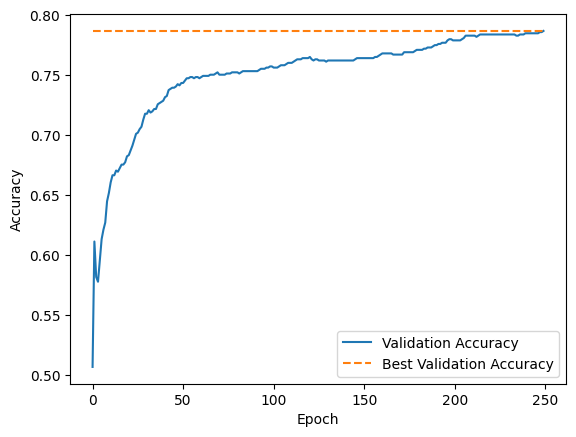

Accuracy (wide): 0.79
Epoch: 0, loss: 7.25873
Epoch: 10, loss: 0.58766
Epoch: 20, loss: 0.43465
Epoch: 30, loss: 0.39454
Epoch: 40, loss: 0.37873
Epoch: 50, loss: 0.37037
Epoch: 60, loss: 0.36594
Epoch: 70, loss: 0.36171
Epoch: 80, loss: 0.35756
Epoch: 90, loss: 0.35399
Epoch: 100, loss: 0.35065
Epoch: 110, loss: 0.34692
Epoch: 120, loss: 0.34272
Epoch: 130, loss: 0.33794
Epoch: 140, loss: 0.33441
Epoch: 150, loss: 0.33211
Epoch: 160, loss: 0.33103
Epoch: 170, loss: 0.33053
Epoch: 180, loss: 0.33016
Epoch: 190, loss: 0.33043
Epoch: 200, loss: 0.33054
Epoch: 210, loss: 0.32972
Epoch: 220, loss: 0.33014
Epoch: 230, loss: 0.33138
Epoch: 240, loss: 0.33260
Epoch: 249, loss: 0.33350


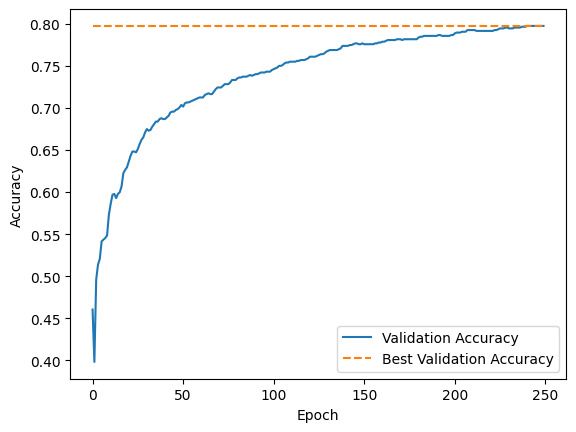

Accuracy (wide): 0.80
Epoch: 0, loss: 1.09950
Epoch: 10, loss: 0.39429
Epoch: 20, loss: 0.39284
Epoch: 30, loss: 0.39511
Epoch: 40, loss: 0.39360
Epoch: 50, loss: 0.39134
Epoch: 60, loss: 0.39003
Epoch: 70, loss: 0.38813
Epoch: 80, loss: 0.38577
Epoch: 90, loss: 0.38225
Epoch: 100, loss: 0.37839
Epoch: 110, loss: 0.37534
Epoch: 120, loss: 0.37263
Epoch: 130, loss: 0.36957
Epoch: 140, loss: 0.36582
Epoch: 150, loss: 0.36123
Epoch: 160, loss: 0.35628
Epoch: 170, loss: 0.35263
Epoch: 180, loss: 0.34994
Epoch: 190, loss: 0.34778
Epoch: 200, loss: 0.34384
Epoch: 210, loss: 0.33986
Epoch: 220, loss: 0.33689
Epoch: 230, loss: 0.33412
Epoch: 240, loss: 0.33118
Epoch: 249, loss: 0.32849


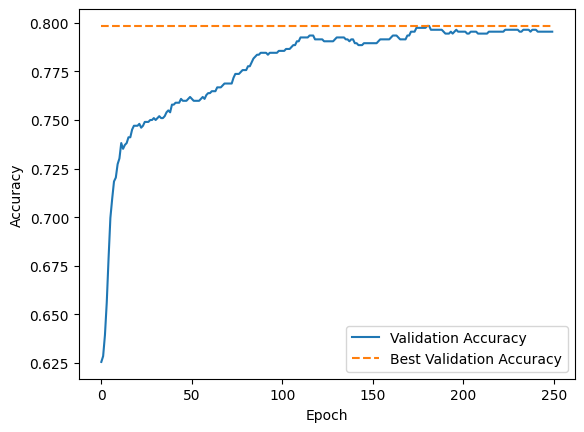

Accuracy (wide): 0.80
Epoch: 0, loss: 1.93727
Epoch: 10, loss: 0.66062
Epoch: 20, loss: 0.55927
Epoch: 30, loss: 0.51811
Epoch: 40, loss: 0.49580
Epoch: 50, loss: 0.48205
Epoch: 60, loss: 0.47330
Epoch: 70, loss: 0.46737
Epoch: 80, loss: 0.46288
Epoch: 90, loss: 0.45938
Epoch: 100, loss: 0.45648
Epoch: 110, loss: 0.45403
Epoch: 120, loss: 0.45189
Epoch: 130, loss: 0.45008
Epoch: 140, loss: 0.44865
Epoch: 150, loss: 0.44742
Epoch: 160, loss: 0.44672
Epoch: 170, loss: 0.44554
Epoch: 180, loss: 0.44410
Epoch: 190, loss: 0.44272
Epoch: 200, loss: 0.44090
Epoch: 210, loss: 0.43958
Epoch: 220, loss: 0.43815
Epoch: 230, loss: 0.43682
Epoch: 240, loss: 0.43531
Epoch: 249, loss: 0.43383


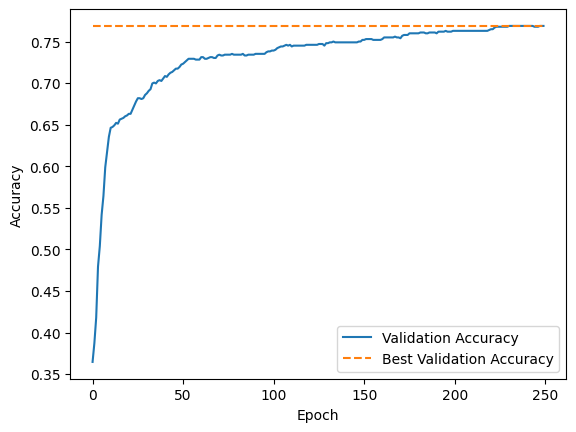

Accuracy (wide): 0.77
Epoch: 0, loss: 1.25676
Epoch: 10, loss: 0.41771
Epoch: 20, loss: 0.41263
Epoch: 30, loss: 0.41189
Epoch: 40, loss: 0.41004
Epoch: 50, loss: 0.40859
Epoch: 60, loss: 0.40850
Epoch: 70, loss: 0.40865
Epoch: 80, loss: 0.40865
Epoch: 90, loss: 0.40845
Epoch: 100, loss: 0.40813
Epoch: 110, loss: 0.40803
Epoch: 120, loss: 0.40824
Epoch: 130, loss: 0.40883
Epoch: 140, loss: 0.40922
Epoch: 150, loss: 0.40921
Epoch: 160, loss: 0.40901
Epoch: 170, loss: 0.40864
Epoch: 180, loss: 0.40812
Epoch: 190, loss: 0.40753
Epoch: 200, loss: 0.40715
Epoch: 210, loss: 0.40700
Epoch: 220, loss: 0.40700
Epoch: 230, loss: 0.40664
Epoch: 240, loss: 0.40625
Epoch: 249, loss: 0.40545


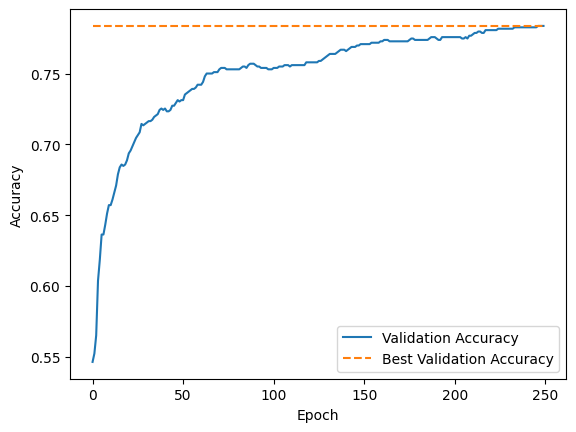

Accuracy (wide): 0.78
Epoch: 0, loss: 0.56648
Epoch: 10, loss: 0.47678
Epoch: 20, loss: 0.46425
Epoch: 30, loss: 0.45561
Epoch: 40, loss: 0.45467
Epoch: 50, loss: 0.45292
Epoch: 60, loss: 0.45070
Epoch: 70, loss: 0.44622
Epoch: 80, loss: 0.44383
Epoch: 90, loss: 0.44178
Epoch: 100, loss: 0.43994
Epoch: 110, loss: 0.44080
Epoch: 120, loss: 0.43979
Epoch: 130, loss: 0.43675
Epoch: 140, loss: 0.43393
Epoch: 150, loss: 0.43173
Epoch: 160, loss: 0.43022
Epoch: 170, loss: 0.42886
Epoch: 180, loss: 0.42756
Epoch: 190, loss: 0.42644
Epoch: 200, loss: 0.42558
Epoch: 210, loss: 0.42456
Epoch: 220, loss: 0.42242
Epoch: 230, loss: 0.42098
Epoch: 240, loss: 0.41943
Epoch: 249, loss: 0.41883


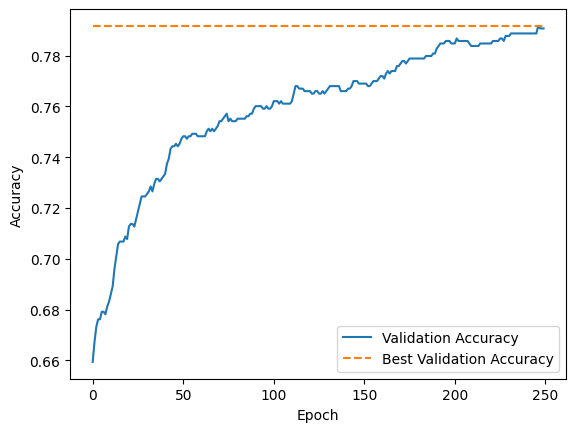

Accuracy (deep1): 0.79
Epoch: 0, loss: 0.58511
Epoch: 10, loss: 0.48106
Epoch: 20, loss: 0.46120
Epoch: 30, loss: 0.44913
Epoch: 40, loss: 0.44058
Epoch: 50, loss: 0.43351
Epoch: 60, loss: 0.42735
Epoch: 70, loss: 0.41997
Epoch: 80, loss: 0.41215
Epoch: 90, loss: 0.40471
Epoch: 100, loss: 0.39818
Epoch: 110, loss: 0.39220
Epoch: 120, loss: 0.38726
Epoch: 130, loss: 0.38343
Epoch: 140, loss: 0.37876
Epoch: 150, loss: 0.37385
Epoch: 160, loss: 0.36997
Epoch: 170, loss: 0.36025
Epoch: 180, loss: 0.35841
Epoch: 190, loss: 0.35568
Epoch: 200, loss: 0.35135
Epoch: 210, loss: 0.34782
Epoch: 220, loss: 0.34547
Epoch: 230, loss: 0.34214
Epoch: 240, loss: 0.33887
Epoch: 249, loss: 0.33564


Accuracy (deep1): 0.78
Epoch: 0, loss: 0.58626
Epoch: 10, loss: 0.50041
Epoch: 20, loss: 0.47596
Epoch: 30, loss: 0.45642
Epoch: 40, loss: 0.44132
Epoch: 50, loss: 0.42991
Epoch: 60, loss: 0.42148
Epoch: 70, loss: 0.41375
Epoch: 80, loss: 0.40688
Epoch: 90, loss: 0.40069
Epoch: 100, loss: 0.39545
Epoch: 110, loss: 0.39060
Epoch: 120, loss: 0.38777
Epoch: 130, loss: 0.38500
Epoch: 140, loss: 0.38009
Epoch: 150, loss: 0.37288
Epoch: 160, loss: 0.36795
Epoch: 170, loss: 0.36476
Epoch: 180, loss: 0.36119
Epoch: 190, loss: 0.35860
Epoch: 200, loss: 0.35569
Epoch: 210, loss: 0.35262
Epoch: 220, loss: 0.34948
Epoch: 230, loss: 0.34647
Epoch: 240, loss: 0.34346
Epoch: 249, loss: 0.34095


Accuracy (deep1): 0.78
Epoch: 0, loss: 0.60580
Epoch: 10, loss: 0.52569
Epoch: 20, loss: 0.48696
Epoch: 30, loss: 0.46653
Epoch: 40, loss: 0.45399
Epoch: 50, loss: 0.44397
Epoch: 60, loss: 0.43681
Epoch: 70, loss: 0.43071
Epoch: 80, loss: 0.42487
Epoch: 90, loss: 0.41683
Epoch: 100, loss: 0.40910
Epoch: 110, loss: 0.40327
Epoch: 120, loss: 0.39808
Epoch: 130, loss: 0.39082
Epoch: 140, loss: 0.37950
Epoch: 150, loss: 0.37341
Epoch: 160, loss: 0.36916
Epoch: 170, loss: 0.36574
Epoch: 180, loss: 0.36359
Epoch: 190, loss: 0.36152
Epoch: 200, loss: 0.35994
Epoch: 210, loss: 0.35845
Epoch: 220, loss: 0.35824
Epoch: 230, loss: 0.35691
Epoch: 240, loss: 0.35508
Epoch: 249, loss: 0.35258


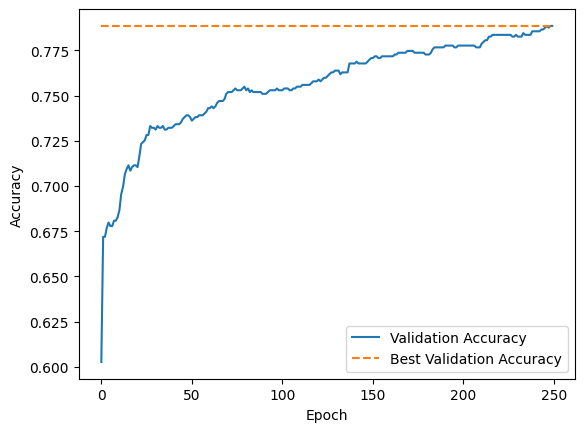

Accuracy (deep1): 0.79
Epoch: 0, loss: 0.64956
Epoch: 10, loss: 0.41917
Epoch: 20, loss: 0.38571
Epoch: 30, loss: 0.36816
Epoch: 40, loss: 0.35605
Epoch: 50, loss: 0.34741
Epoch: 60, loss: 0.34203
Epoch: 70, loss: 0.33708
Epoch: 80, loss: 0.33297
Epoch: 90, loss: 0.33032
Epoch: 100, loss: 0.32874
Epoch: 110, loss: 0.32650
Epoch: 120, loss: 0.32464
Epoch: 130, loss: 0.32288
Epoch: 140, loss: 0.32169
Epoch: 150, loss: 0.32024
Epoch: 160, loss: 0.31824
Epoch: 170, loss: 0.31700
Epoch: 180, loss: 0.31552
Epoch: 190, loss: 0.31373
Epoch: 200, loss: 0.31241
Epoch: 210, loss: 0.31208
Epoch: 220, loss: 0.31156
Epoch: 230, loss: 0.31095
Epoch: 240, loss: 0.30983
Epoch: 249, loss: 0.30906


Accuracy (deep1): 0.78
Epoch: 0, loss: 0.94769
Epoch: 10, loss: 0.53990
Epoch: 20, loss: 0.49927
Epoch: 30, loss: 0.47522
Epoch: 40, loss: 0.46273
Epoch: 50, loss: 0.45139
Epoch: 60, loss: 0.44272
Epoch: 70, loss: 0.43560
Epoch: 80, loss: 0.42975
Epoch: 90, loss: 0.42368
Epoch: 100, loss: 0.41693
Epoch: 110, loss: 0.40987
Epoch: 120, loss: 0.40460
Epoch: 130, loss: 0.39984
Epoch: 140, loss: 0.39426
Epoch: 150, loss: 0.38936
Epoch: 160, loss: 0.38460
Epoch: 170, loss: 0.37982
Epoch: 180, loss: 0.37551
Epoch: 190, loss: 0.37104
Epoch: 200, loss: 0.36729
Epoch: 210, loss: 0.36411
Epoch: 220, loss: 0.36223
Epoch: 230, loss: 0.36174
Epoch: 240, loss: 0.36095
Epoch: 249, loss: 0.35867


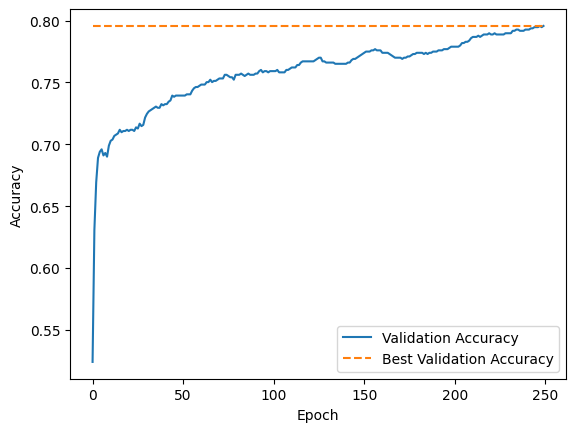

Accuracy (deep): 0.80
Epoch: 0, loss: 0.82292
Epoch: 10, loss: 0.52024
Epoch: 20, loss: 0.49269
Epoch: 30, loss: 0.47834
Epoch: 40, loss: 0.46783
Epoch: 50, loss: 0.45781
Epoch: 60, loss: 0.44898
Epoch: 70, loss: 0.44161
Epoch: 80, loss: 0.43558
Epoch: 90, loss: 0.43112
Epoch: 100, loss: 0.42541
Epoch: 110, loss: 0.42312
Epoch: 120, loss: 0.42168
Epoch: 130, loss: 0.42005
Epoch: 140, loss: 0.41620
Epoch: 150, loss: 0.41175
Epoch: 160, loss: 0.40829
Epoch: 170, loss: 0.40536
Epoch: 180, loss: 0.40245
Epoch: 190, loss: 0.39978
Epoch: 200, loss: 0.39722
Epoch: 210, loss: 0.39429
Epoch: 220, loss: 0.39159
Epoch: 230, loss: 0.38927
Epoch: 240, loss: 0.38683
Epoch: 249, loss: 0.38464


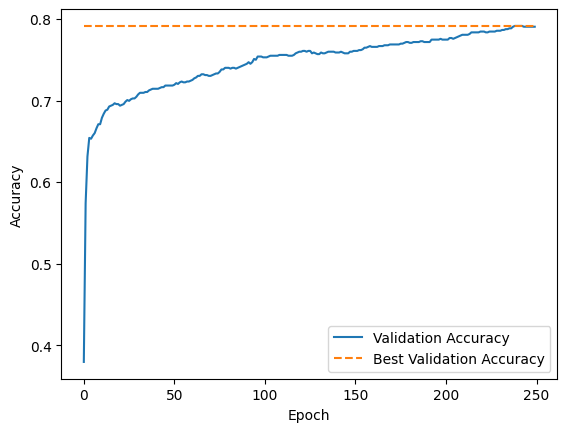

Accuracy (deep): 0.79
Epoch: 0, loss: 0.76794
Epoch: 10, loss: 0.41170
Epoch: 20, loss: 0.38631
Epoch: 30, loss: 0.37154
Epoch: 40, loss: 0.36317
Epoch: 50, loss: 0.35935
Epoch: 60, loss: 0.35544
Epoch: 70, loss: 0.35282
Epoch: 80, loss: 0.34972
Epoch: 90, loss: 0.34665
Epoch: 100, loss: 0.34298
Epoch: 110, loss: 0.33847
Epoch: 120, loss: 0.33384
Epoch: 130, loss: 0.32949
Epoch: 140, loss: 0.32630
Epoch: 150, loss: 0.32310
Epoch: 160, loss: 0.31904
Epoch: 170, loss: 0.31539
Epoch: 180, loss: 0.31182
Epoch: 190, loss: 0.30863
Epoch: 200, loss: 0.30595
Epoch: 210, loss: 0.30303
Epoch: 220, loss: 0.30110
Epoch: 230, loss: 0.29916
Epoch: 240, loss: 0.29785
Epoch: 249, loss: 0.29637


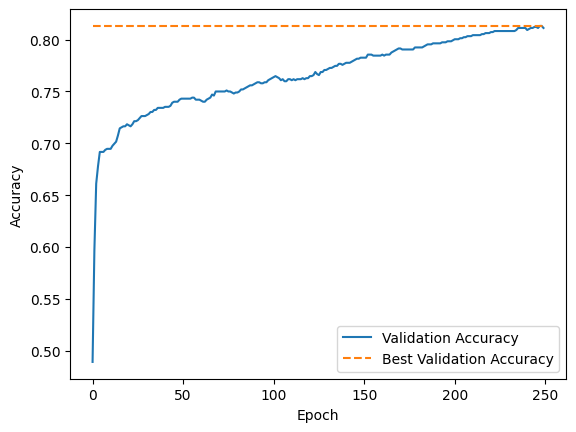

Accuracy (deep): 0.81
Epoch: 0, loss: 0.68862
Epoch: 10, loss: 0.45724
Epoch: 20, loss: 0.43992
Epoch: 30, loss: 0.42302
Epoch: 40, loss: 0.41140
Epoch: 50, loss: 0.40314
Epoch: 60, loss: 0.39510
Epoch: 70, loss: 0.38736
Epoch: 80, loss: 0.38035
Epoch: 90, loss: 0.37514
Epoch: 100, loss: 0.36948
Epoch: 110, loss: 0.36408
Epoch: 120, loss: 0.35999
Epoch: 130, loss: 0.35512
Epoch: 140, loss: 0.34792
Epoch: 150, loss: 0.34347
Epoch: 160, loss: 0.33869
Epoch: 170, loss: 0.33428
Epoch: 180, loss: 0.33030
Epoch: 190, loss: 0.32690
Epoch: 200, loss: 0.32181
Epoch: 210, loss: 0.31715
Epoch: 220, loss: 0.31097
Epoch: 230, loss: 0.30518
Epoch: 240, loss: 0.30168
Epoch: 249, loss: 0.29977


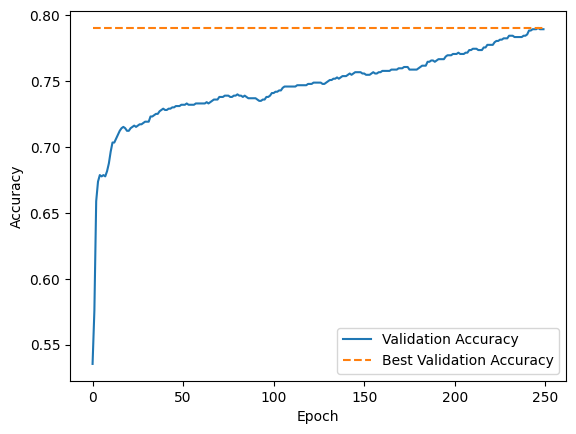

Accuracy (deep): 0.79
Epoch: 0, loss: 0.63708
Epoch: 10, loss: 0.47713
Epoch: 20, loss: 0.45618
Epoch: 30, loss: 0.44274
Epoch: 40, loss: 0.43199
Epoch: 50, loss: 0.42086
Epoch: 60, loss: 0.41074
Epoch: 70, loss: 0.40312
Epoch: 80, loss: 0.39804
Epoch: 90, loss: 0.39270
Epoch: 100, loss: 0.38791
Epoch: 110, loss: 0.38337
Epoch: 120, loss: 0.38048
Epoch: 130, loss: 0.37860
Epoch: 140, loss: 0.37468
Epoch: 150, loss: 0.36978
Epoch: 160, loss: 0.36123
Epoch: 170, loss: 0.35731
Epoch: 180, loss: 0.34739
Epoch: 190, loss: 0.34152
Epoch: 200, loss: 0.33565
Epoch: 210, loss: 0.33225
Epoch: 220, loss: 0.32836
Epoch: 230, loss: 0.32408
Epoch: 240, loss: 0.31847
Epoch: 249, loss: 0.31580


Accuracy (deep): 0.80
Epoch: 0, loss: 1.41191
Epoch: 10, loss: 0.84447
Epoch: 20, loss: 0.76406
Epoch: 30, loss: 0.73381
Epoch: 40, loss: 0.72092
Epoch: 50, loss: 0.71278
Epoch: 60, loss: 0.70636
Epoch: 70, loss: 0.70089
Epoch: 80, loss: 0.69606
Epoch: 90, loss: 0.69168
Epoch: 100, loss: 0.68767
Epoch: 110, loss: 0.68395
Epoch: 120, loss: 0.68048
Epoch: 130, loss: 0.67724
Epoch: 140, loss: 0.67420
Epoch: 150, loss: 0.67136
Epoch: 160, loss: 0.66868
Epoch: 170, loss: 0.66617
Epoch: 180, loss: 0.66381
Epoch: 190, loss: 0.66159
Epoch: 200, loss: 0.65950
Epoch: 210, loss: 0.65753
Epoch: 220, loss: 0.65568
Epoch: 230, loss: 0.65394
Epoch: 240, loss: 0.65229
Epoch: 249, loss: 0.65090


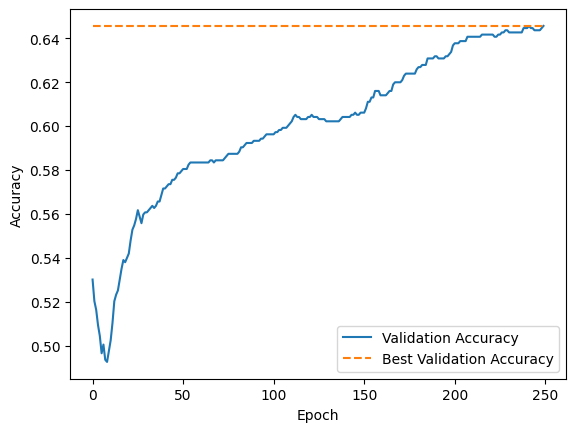

Accuracy (pbm): 0.65
Epoch: 0, loss: 1.18247
Epoch: 10, loss: 0.85583
Epoch: 20, loss: 0.79371
Epoch: 30, loss: 0.76721
Epoch: 40, loss: 0.75476
Epoch: 50, loss: 0.74654
Epoch: 60, loss: 0.73966
Epoch: 70, loss: 0.73346
Epoch: 80, loss: 0.72776
Epoch: 90, loss: 0.72246
Epoch: 100, loss: 0.71749
Epoch: 110, loss: 0.71283
Epoch: 120, loss: 0.70844
Epoch: 130, loss: 0.70431
Epoch: 140, loss: 0.70040
Epoch: 150, loss: 0.69672
Epoch: 160, loss: 0.69323
Epoch: 170, loss: 0.68994
Epoch: 180, loss: 0.68682
Epoch: 190, loss: 0.68387
Epoch: 200, loss: 0.68107
Epoch: 210, loss: 0.67842
Epoch: 220, loss: 0.67591
Epoch: 230, loss: 0.67352
Epoch: 240, loss: 0.67125
Epoch: 249, loss: 0.66931


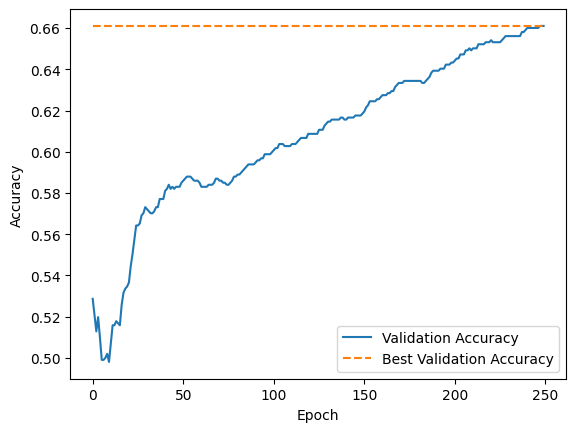

Accuracy (pbm): 0.66
Epoch: 0, loss: 1.24886
Epoch: 10, loss: 0.93171
Epoch: 20, loss: 0.82580
Epoch: 30, loss: 0.77921
Epoch: 40, loss: 0.75791
Epoch: 50, loss: 0.74509
Epoch: 60, loss: 0.73519
Epoch: 70, loss: 0.72668
Epoch: 80, loss: 0.71902
Epoch: 90, loss: 0.71200
Epoch: 100, loss: 0.70547
Epoch: 110, loss: 0.69937
Epoch: 120, loss: 0.69364
Epoch: 130, loss: 0.68825
Epoch: 140, loss: 0.68318
Epoch: 150, loss: 0.67840
Epoch: 160, loss: 0.67389
Epoch: 170, loss: 0.66964
Epoch: 180, loss: 0.66562
Epoch: 190, loss: 0.66182
Epoch: 200, loss: 0.65823
Epoch: 210, loss: 0.65484
Epoch: 220, loss: 0.65162
Epoch: 230, loss: 0.64857
Epoch: 240, loss: 0.64569
Epoch: 249, loss: 0.64321


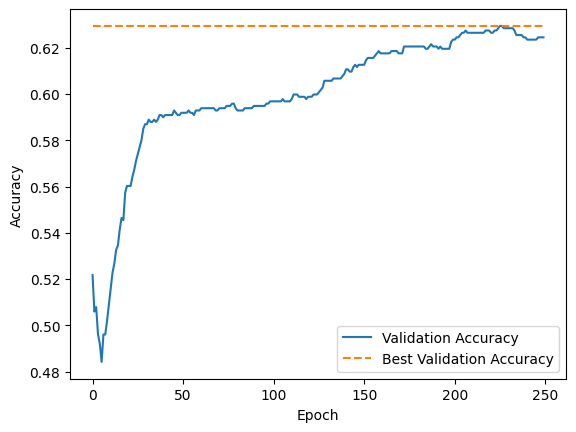

Accuracy (pbm): 0.63
Epoch: 0, loss: 1.33011
Epoch: 10, loss: 0.91447
Epoch: 20, loss: 0.80567
Epoch: 30, loss: 0.75617
Epoch: 40, loss: 0.73456
Epoch: 50, loss: 0.72301
Epoch: 60, loss: 0.71491
Epoch: 70, loss: 0.70828
Epoch: 80, loss: 0.70248
Epoch: 90, loss: 0.69725
Epoch: 100, loss: 0.69244
Epoch: 110, loss: 0.68797
Epoch: 120, loss: 0.68380
Epoch: 130, loss: 0.67988
Epoch: 140, loss: 0.67619
Epoch: 150, loss: 0.67271
Epoch: 160, loss: 0.66944
Epoch: 170, loss: 0.66635
Epoch: 180, loss: 0.66343
Epoch: 190, loss: 0.66068
Epoch: 200, loss: 0.65808
Epoch: 210, loss: 0.65562
Epoch: 220, loss: 0.65329
Epoch: 230, loss: 0.65109
Epoch: 240, loss: 0.64900
Epoch: 249, loss: 0.64722


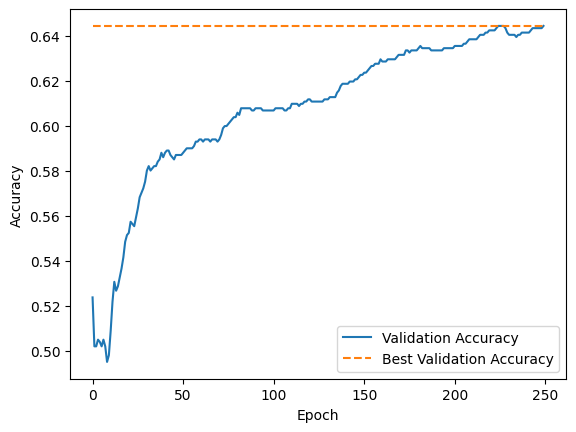

Accuracy (pbm): 0.64
Epoch: 0, loss: 1.26537
Epoch: 10, loss: 0.87829
Epoch: 20, loss: 0.75817
Epoch: 30, loss: 0.69857
Epoch: 40, loss: 0.67308
Epoch: 50, loss: 0.66021
Epoch: 60, loss: 0.65200
Epoch: 70, loss: 0.64574
Epoch: 80, loss: 0.64048
Epoch: 90, loss: 0.63580
Epoch: 100, loss: 0.63152
Epoch: 110, loss: 0.62755
Epoch: 120, loss: 0.62382
Epoch: 130, loss: 0.62031
Epoch: 140, loss: 0.61700
Epoch: 150, loss: 0.61387
Epoch: 160, loss: 0.61091
Epoch: 170, loss: 0.60810
Epoch: 180, loss: 0.60545
Epoch: 190, loss: 0.60293
Epoch: 200, loss: 0.60054
Epoch: 210, loss: 0.59828
Epoch: 220, loss: 0.59613
Epoch: 230, loss: 0.59410
Epoch: 240, loss: 0.59216
Epoch: 249, loss: 0.59050


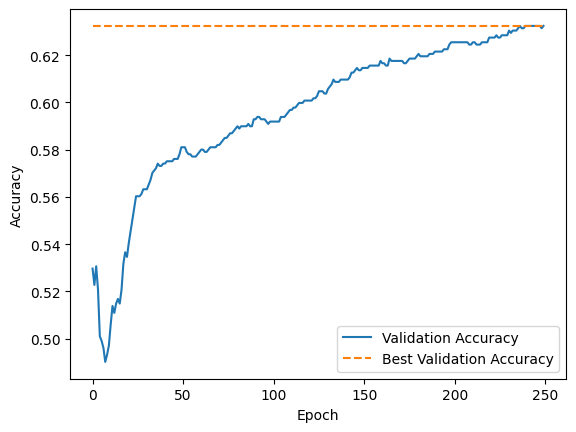

Accuracy (pbm): 0.63


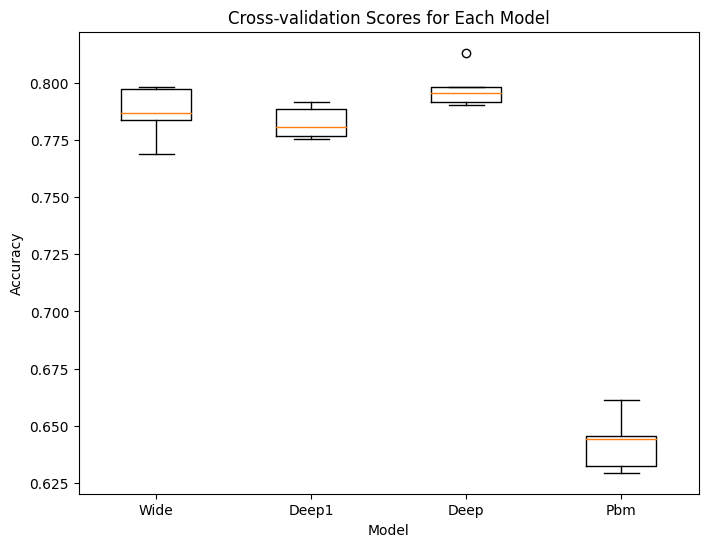

Wide: 78.70% (+/- 1.08%)
Deep1: 78.26% (+/- 0.64%)
Deep: 79.79% (+/- 0.82%)
Pbm: 64.26% (+/- 1.12%)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep1 = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep1()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep1): %.2f" % acc)
    cv_scores_deep1.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
cv_scores_pbm = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    lr = 0.00001
    model = PBM()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr)
    print("Accuracy (pbm): %.2f" % acc)
    cv_scores_pbm.append(acc)

# plot the cross-validation scores for each fold
plt.figure(figsize=(8, 6))
plt.boxplot([cv_scores_wide, cv_scores_deep1, cv_scores_deep, cv_scores_pbm], labels=['Wide', 'Deep1', 'Deep', 'Pbm'])
plt.title('Cross-validation Scores for Each Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep1_acc = np.mean(cv_scores_deep1)
deep1_std = np.std(cv_scores_deep1)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
pbm_acc = np.mean(cv_scores_pbm)
pbm_std = np.std(cv_scores_pbm)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep1: %.2f%% (+/- %.2f%%)" % (deep1_acc*100, deep1_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
print("Pbm: %.2f%% (+/- %.2f%%)" % (pbm_acc*100, pbm_std*100))
import matplotlib.pyplot as plt

models = ['Wide', 'Deep1', 'Deep', 'Pbm']
accuracies = [wide_acc, deep1_acc, deep_acc, pbm_acc]
std_devs = [wide_std, deep1_std, deep_std, pbm_std]




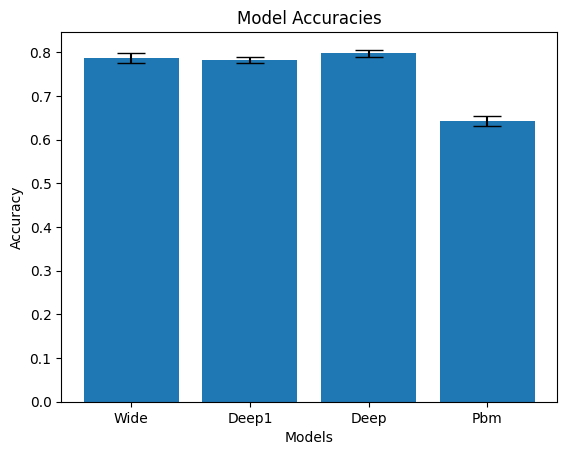

In [ ]:
# plot the bar plot for model accuracies
plt.bar(models, accuracies, yerr=std_devs, capsize=10)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()
